In [1]:
%load_ext autoreload
%autoreload 2

In [205]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm
import sklearn.neighbors as skln
import gc
import pickle
import os
import pandas as pd
import scipy

from lshexperiment import *

DATA_DIR = 'data'
FIG_DIR = "figs"

if DATA_DIR is not None and not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
if FIG_DIR is not None and not os.path.exists(FIG_DIR):
    os.makedirs(FIG_DIR)

def save_fig(name):
    plt.savefig(os.path.join(FIG_DIR, name + ".png"), bbox_inches='tight')
    
# rng = np.random.default_rng(seed=67)
plt.rcParams["figure.figsize"] = (8,3)
plt.rcParams['figure.dpi'] = 300

In [3]:
def plot_data(data, plot_prob=False, plot_queries=False, **kwargs):
    grid, prob_data, query_data = data
    if plot_prob:
        plt.errorbar(grid, prob_data[0], yerr=prob_data[1], **kwargs)
    if plot_queries:
        plt.errorbar(grid, query_data[0], yerr=query_data[1], **kwargs)

In [21]:
def make_double_plots(data, dataset_name=None, savefig=True, xlabel="Starting distance", suffix="starting-distance"):
    assert dataset_name
    # xlims = (np.min(mushroom_dist_grid) - 1, np.max(mushroom_dist_grid) + 1)
    plot_data(data, plot_prob=True)
    # plt.xlim(xlims)
    plt.title(f"Success probability vs {xlabel}, {dataset_name}")
    plt.xlabel(xlabel)
    plt.ylabel("Success probability")
    if savefig:
        save_fig(f"{dataset_name}-prob-{suffix}")
    plt.show()

    plot_data(data, plot_queries=True)
    # plt.xlim(xlims)
    plt.title(f"Mean number of queries vs {xlabel}, {dataset_name}")
    plt.xlabel(xlabel)
    plt.ylabel("Number of queries")
    if savefig:
        save_fig(f"{dataset_name}-queries-{suffix}")
    plt.show()

In [5]:
from sklearn.datasets import fetch_openml

In [6]:
points = np.random.binomial(1, 1/15, size=(1000, 300))

In [8]:
distances = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(points, metric='cityblock'))
val = (distances + np.eye(distances.shape[0]) * distances.max()).min(axis=0)

# Variability tests

In [254]:
env = Environment()

point_params = {
    'n': 1000,
    'd': 150,
    'point_type': "random",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/16,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'change_points': True,
    'iter_num': 100,
    'seed_offset': 0,
    'target_distance': None,
}

In [24]:
grid = np.geomspace(100, 8000, num=20, dtype=int)
res = run_basic_grid_experiment(grid, 'n', env, point_params, lsh_params, exp_params, target='points', data_dir=DATA_DIR)

  0%|          | 0/20 [00:00<?, ?it/s]

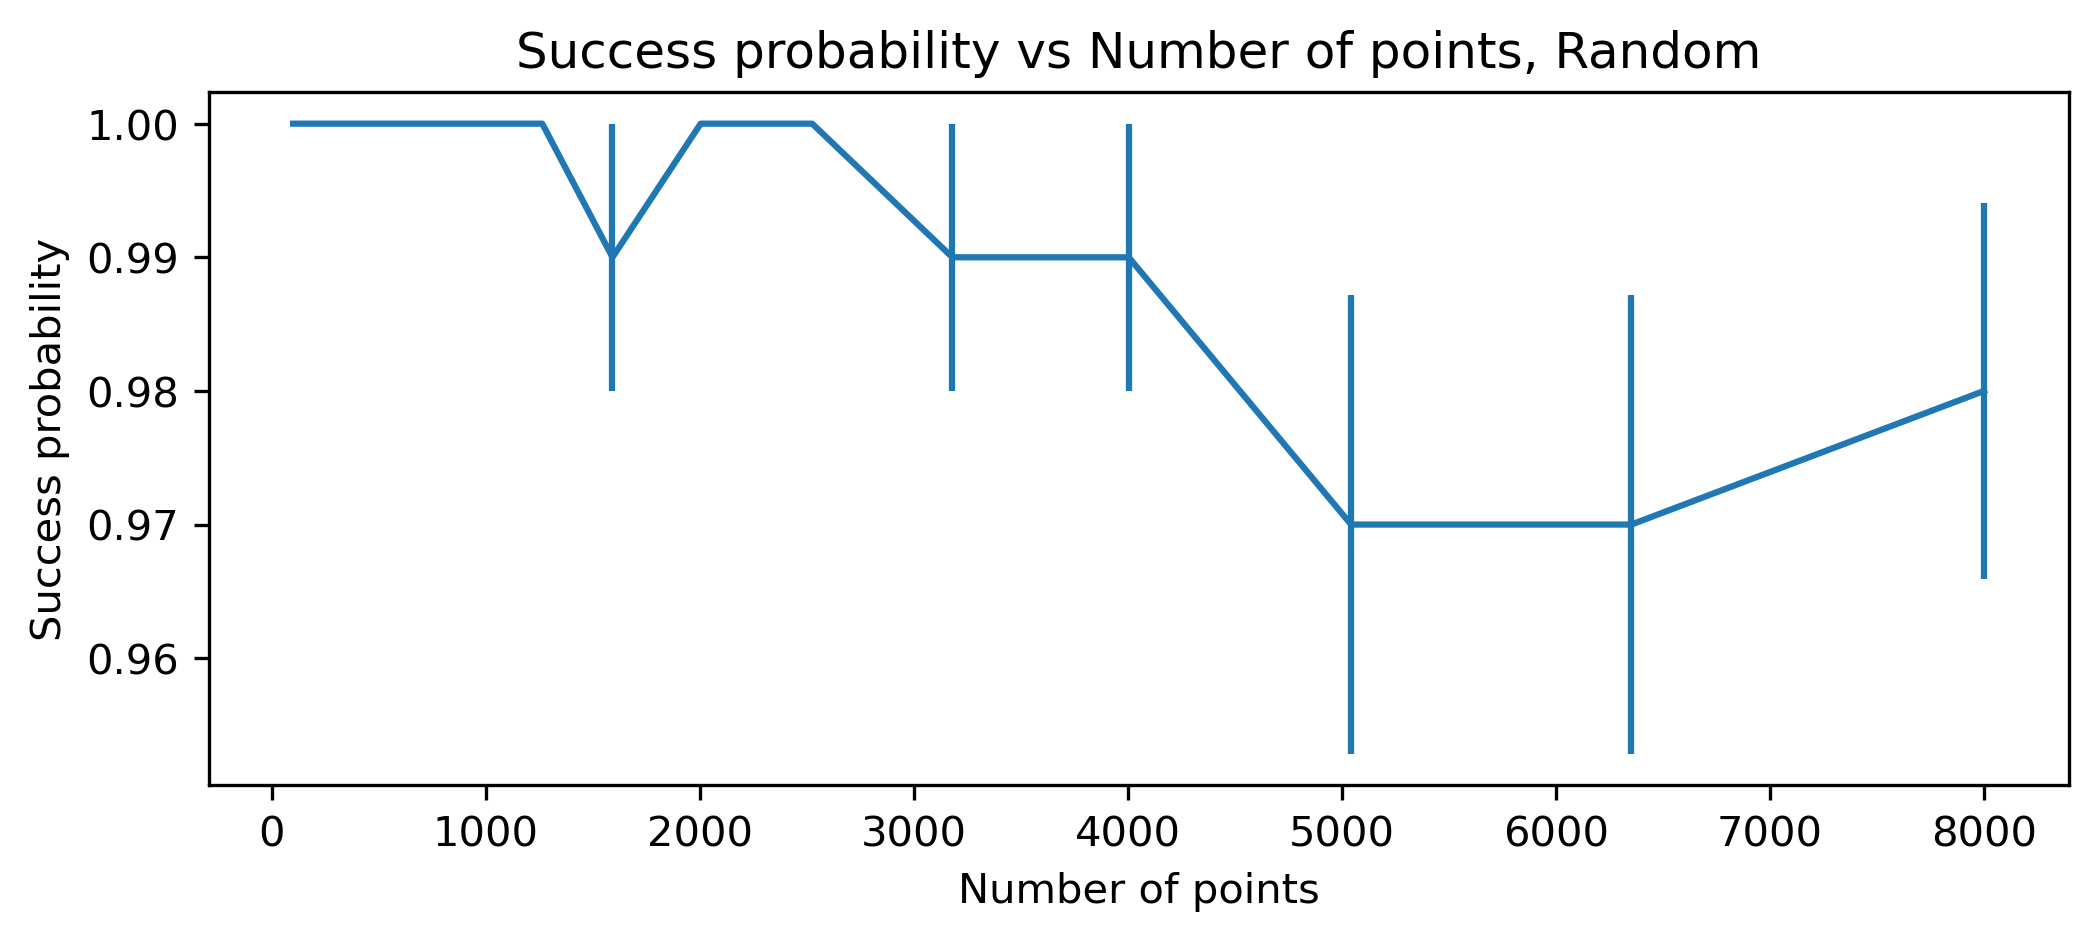

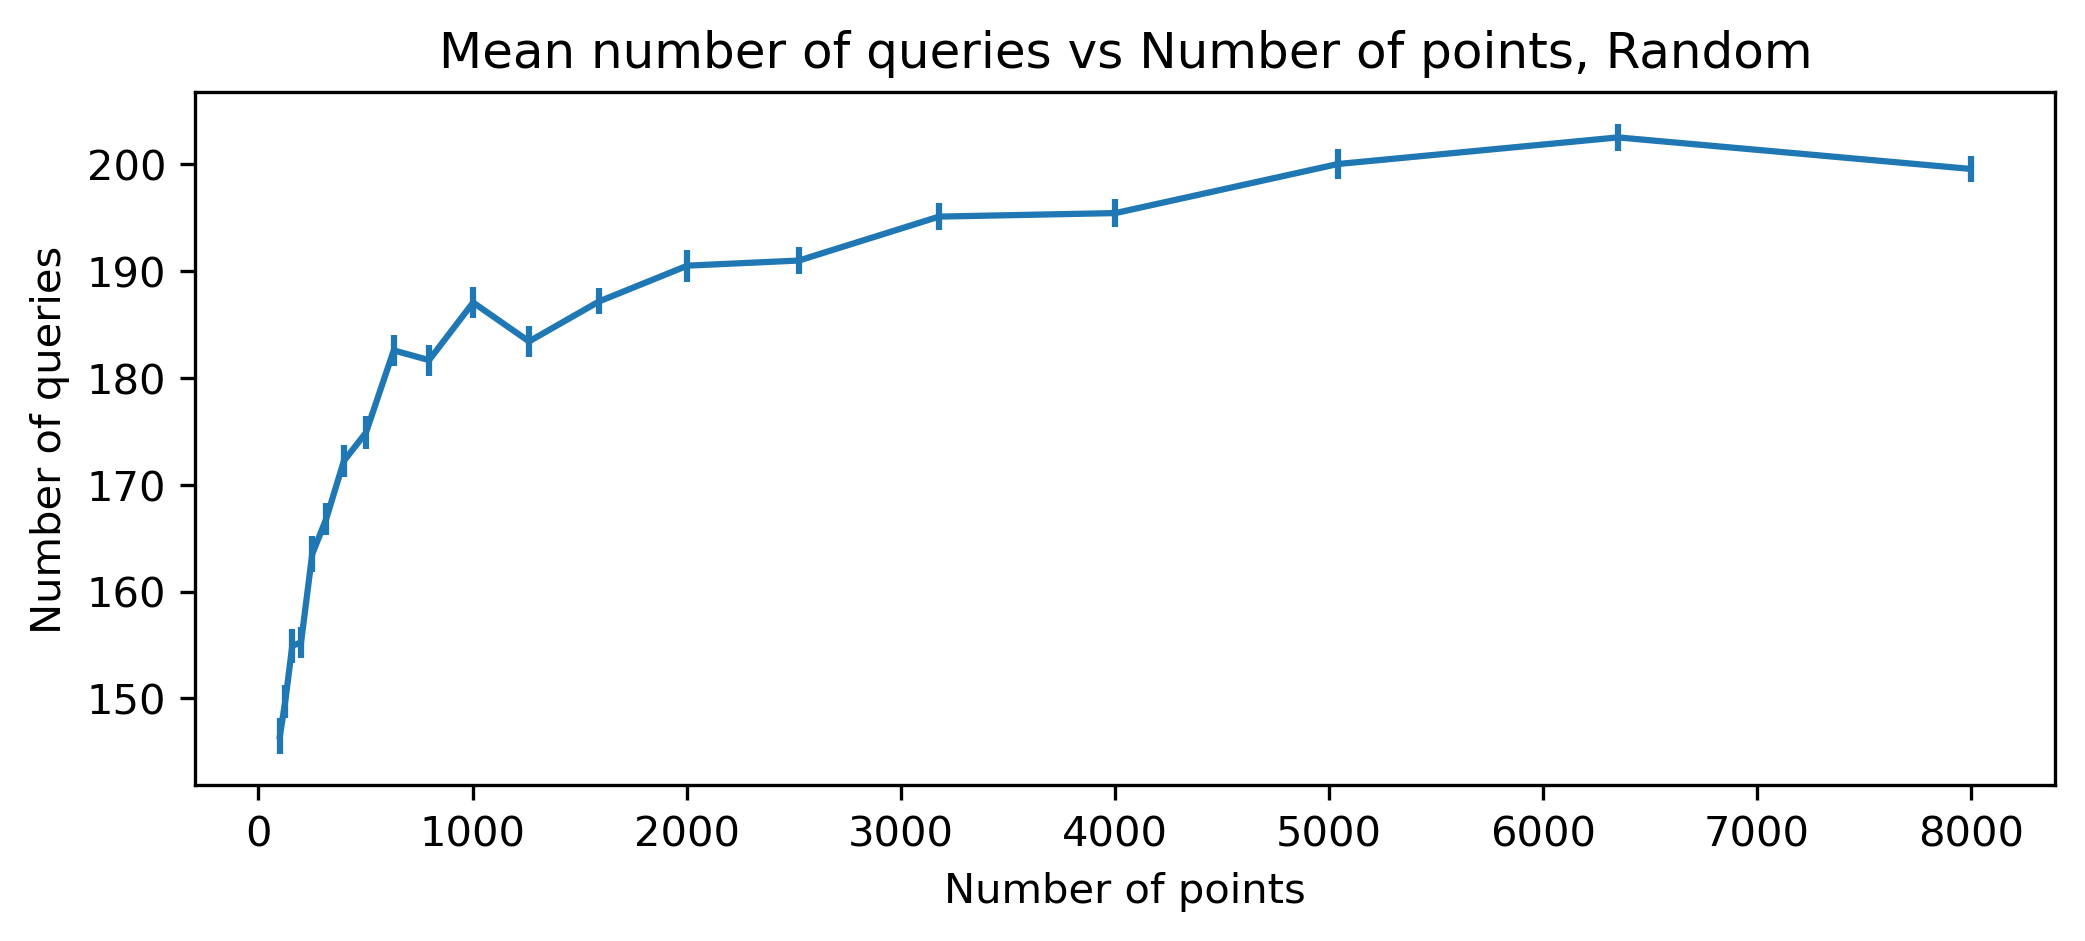

In [25]:
data_succ_prob, data_queries = process_results(res)
points_var_data = prepare_plot_data(res, grid, lsh_params)
make_double_plots(points_var_data, 'Random', xlabel="Number of points", suffix="point-number")

In [255]:
grid = np.linspace(70, 150, num=20, dtype=int)
res = run_advanced_grid_experiment([grid], ['d'], ['points'], env, point_params, lsh_params, exp_params, data_dir=DATA_DIR)

  0%|          | 0/20 [00:00<?, ?it/s]

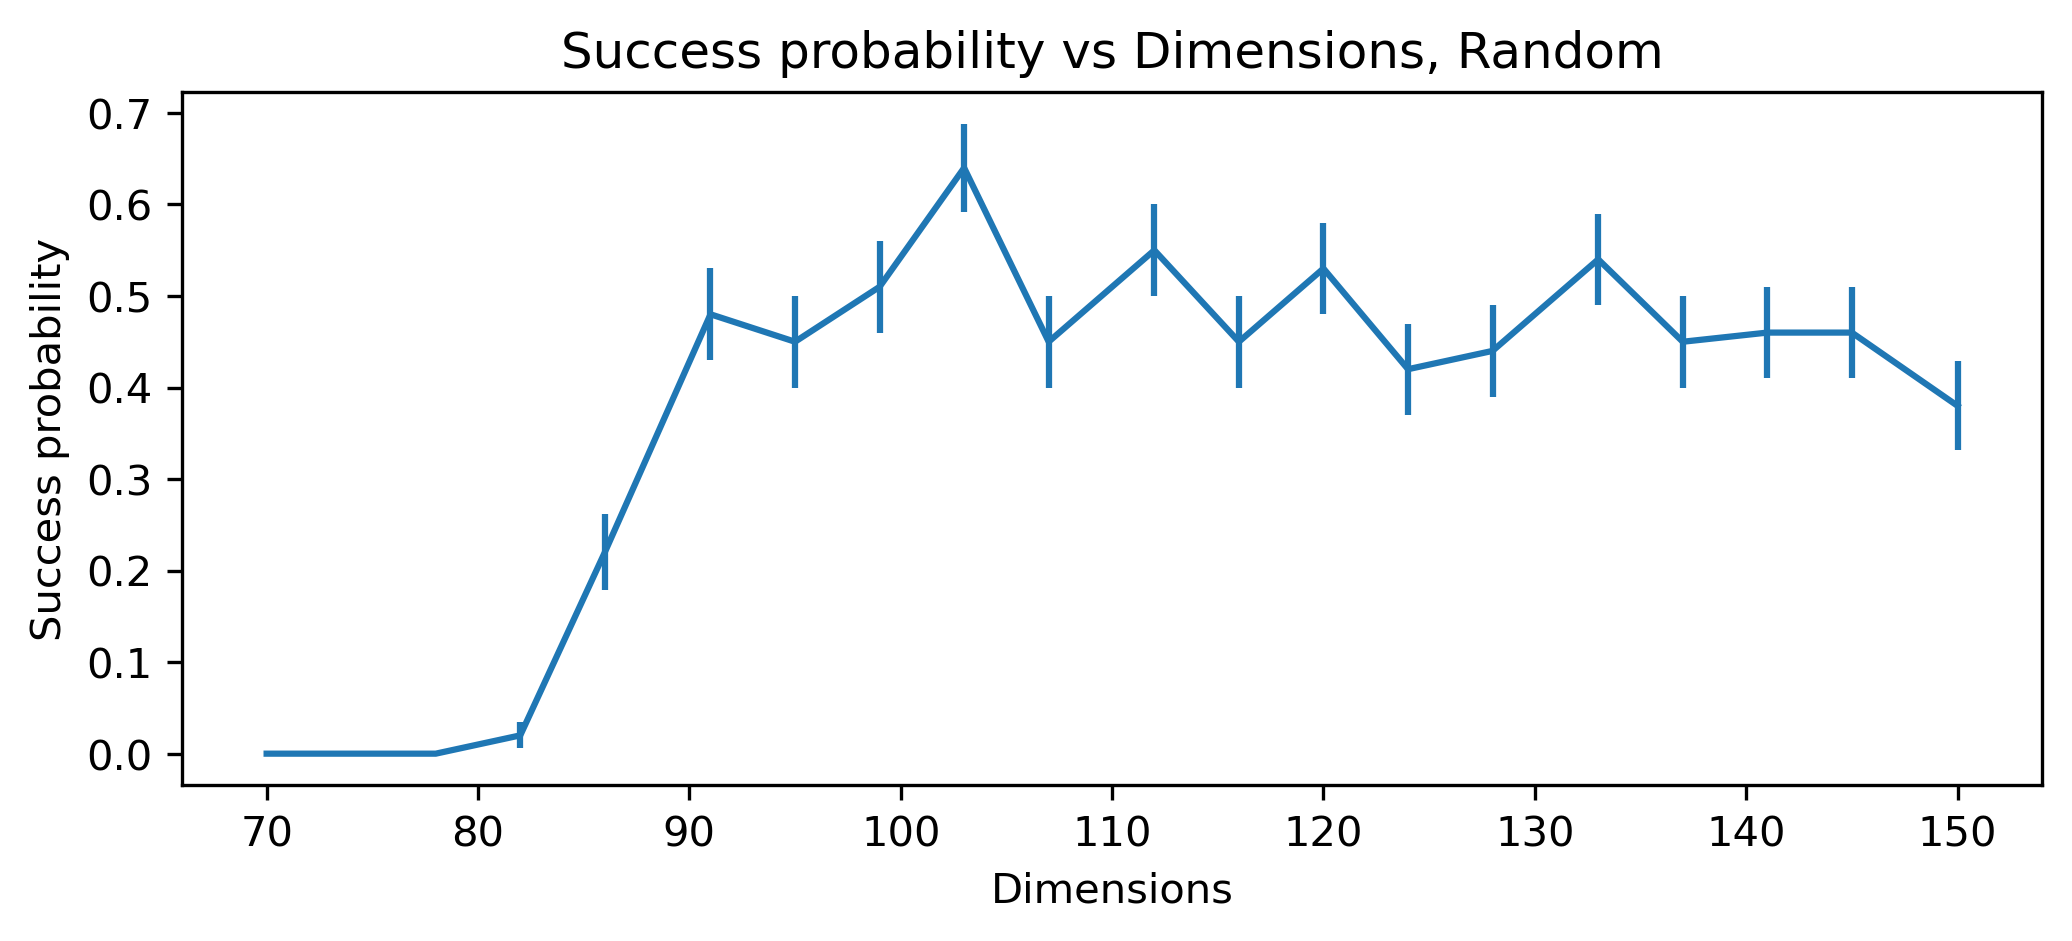

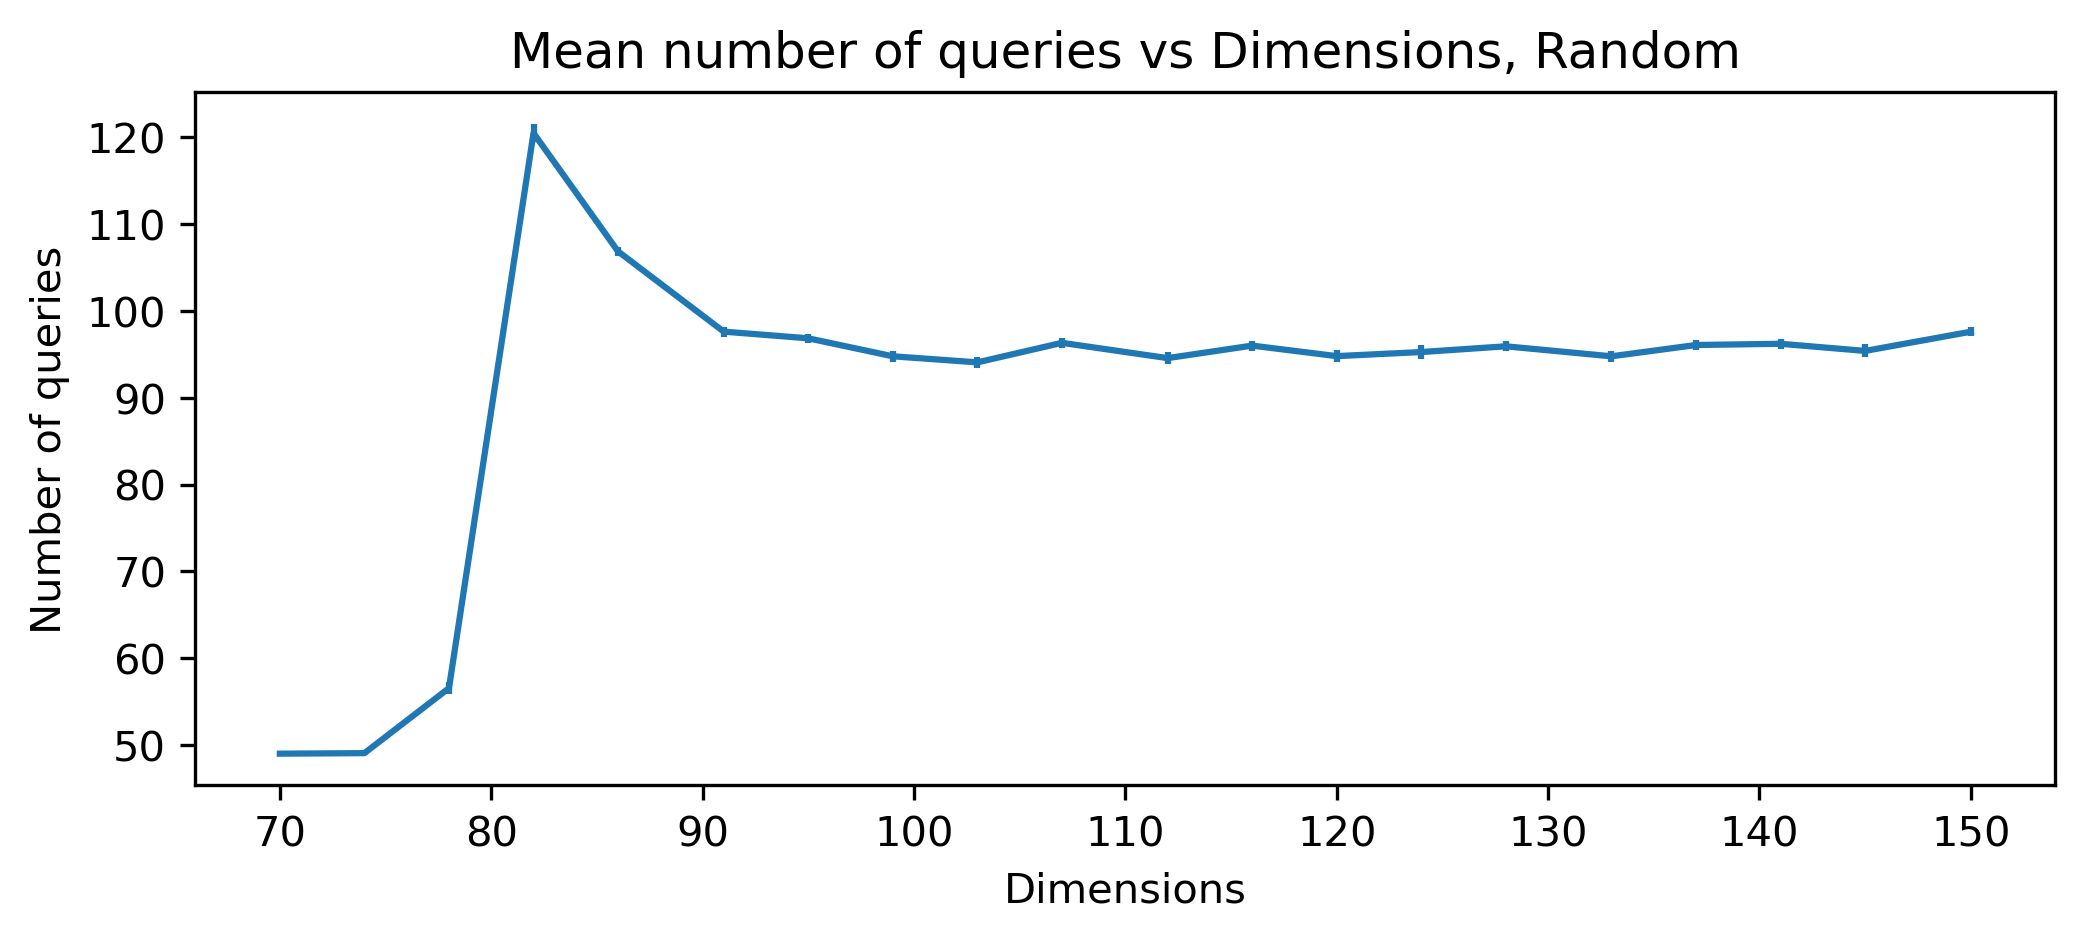

In [256]:
data_succ_prob, data_queries = process_results(res)
points_var_data = prepare_plot_data(res, grid, lsh_params)
make_double_plots(points_var_data, 'Random', xlabel="Dimensions", suffix="dimensions")

In [136]:
r1_grid = np.linspace(1, 70, num=20, dtype=int)
r2_grid = r1_grid * 2

res = run_advanced_grid_experiment([r1_grid, r2_grid], ['r1', 'r2'], ['lsh', 'lsh'], env, point_params, lsh_params, exp_params, data_dir=DATA_DIR)

  0%|          | 0/20 [00:00<?, ?it/s]

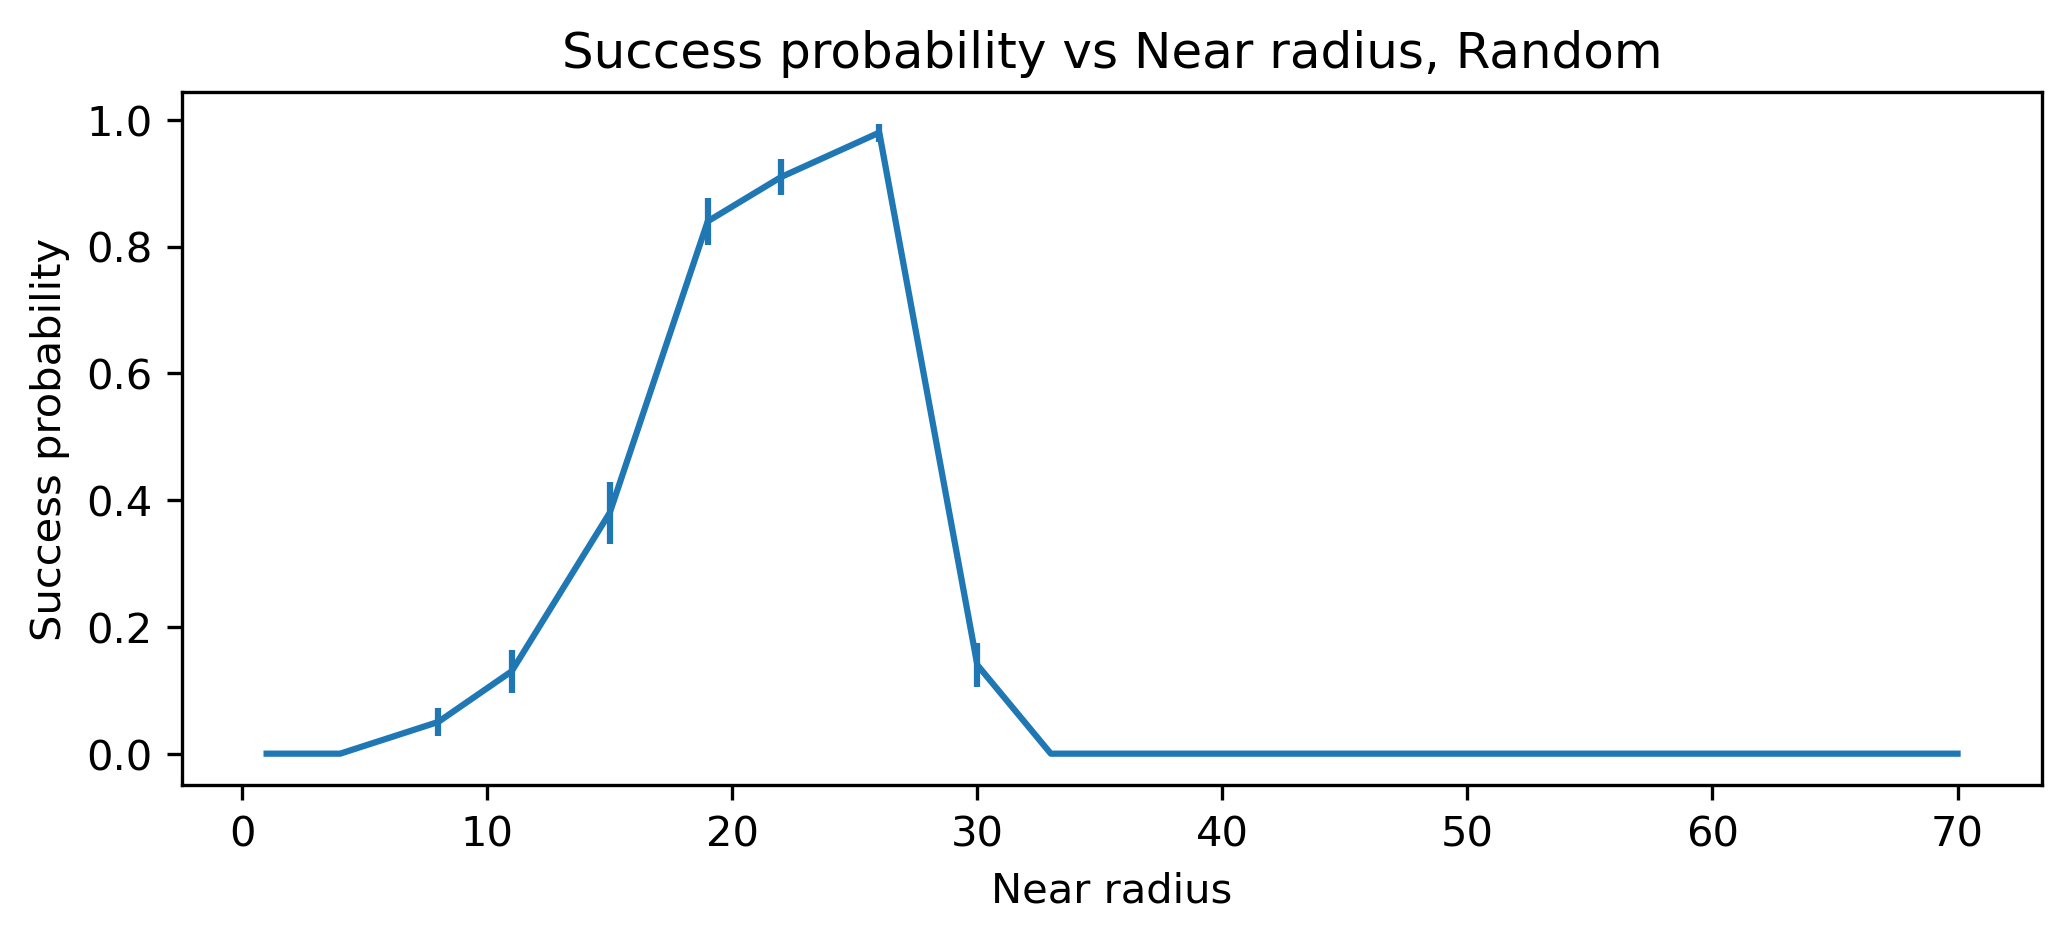

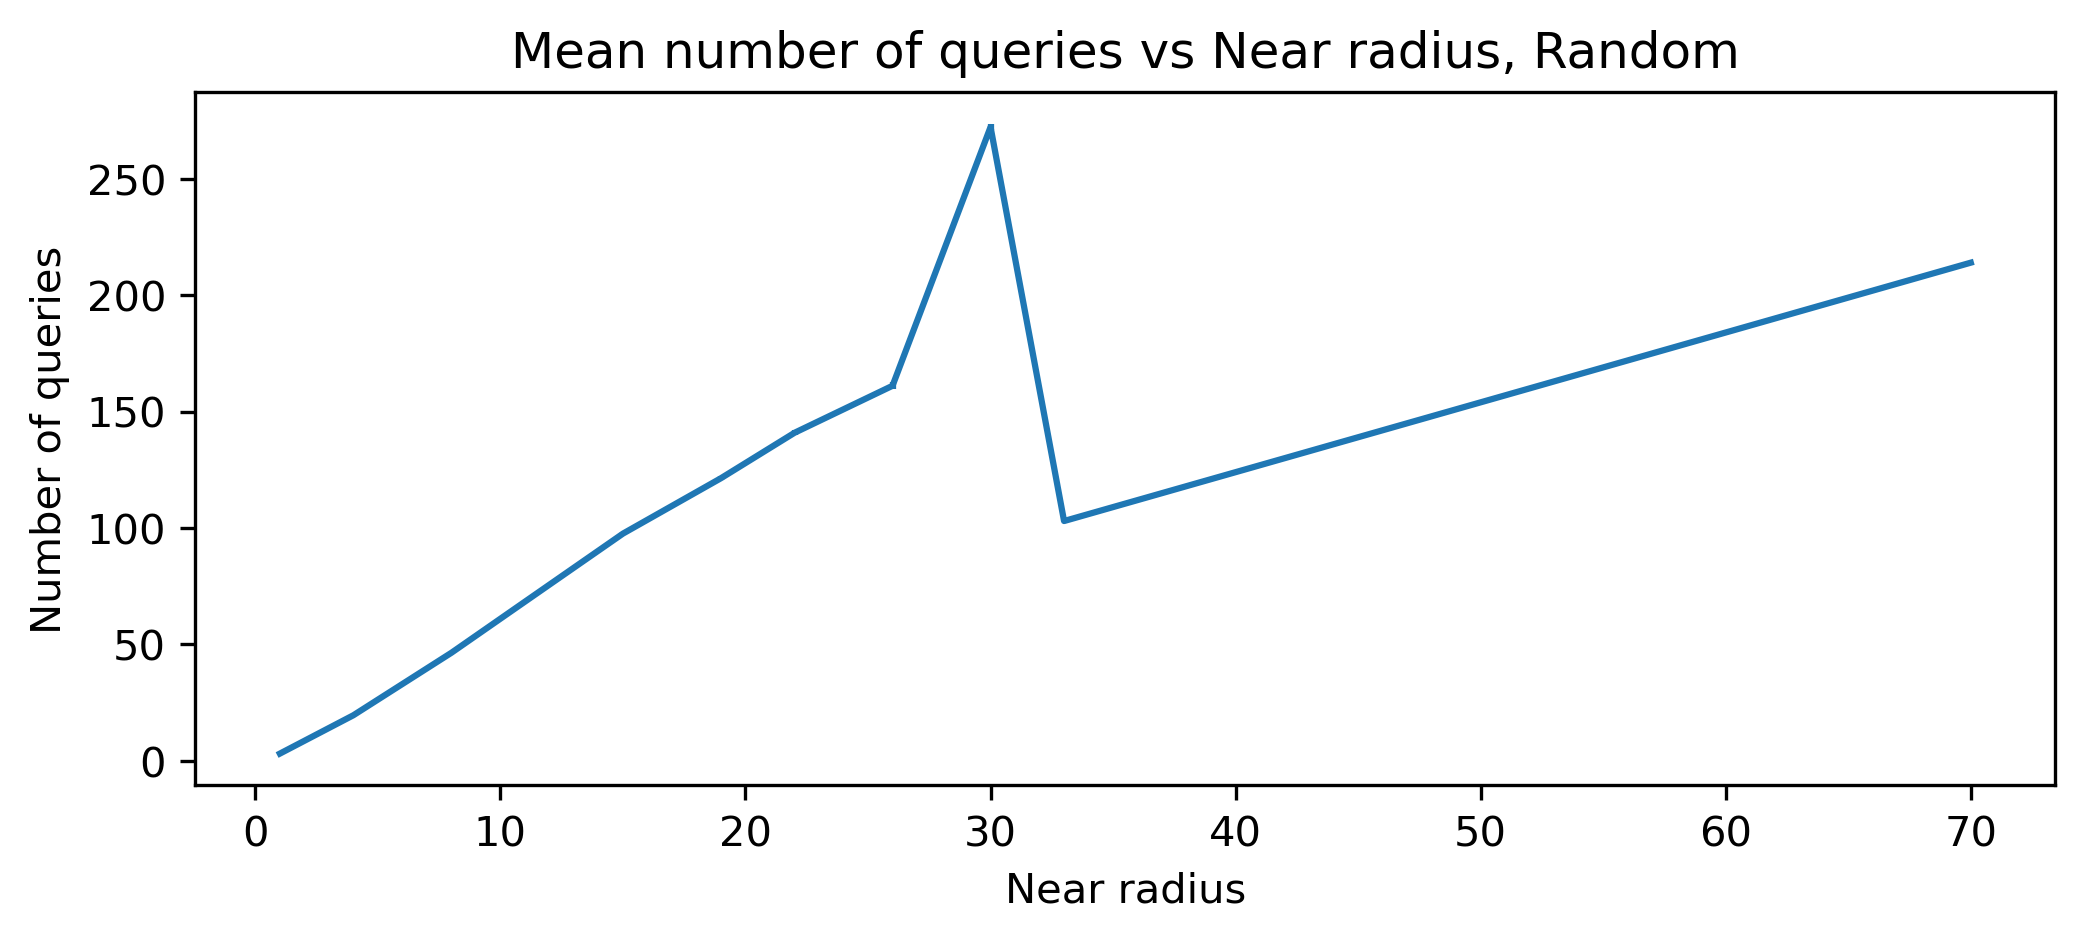

In [137]:
data_succ_prob, data_queries = process_results(res)
points_var_data = prepare_plot_data(res, r1_grid, lsh_params)
make_double_plots(points_var_data, 'Random', xlabel="Near radius", suffix="near-radius")

In [144]:
d_grid = np.linspace(50, 300, num=10, dtype=int)

r1_grid = np.ceil(d_grid * 0.1)
r1_grid = np.maximum(r1_grid, 1).astype(int)

r2_grid = r1_grid * 2
r2_grid = np.minimum(r2_grid, d_grid - 1)

res = run_advanced_grid_experiment([d_grid, r1_grid, r2_grid], ['d', 'r1', 'r2'], ['points', 'lsh', 'lsh'], env, point_params, lsh_params, exp_params, data_dir=DATA_DIR)

  0%|          | 0/10 [00:00<?, ?it/s]

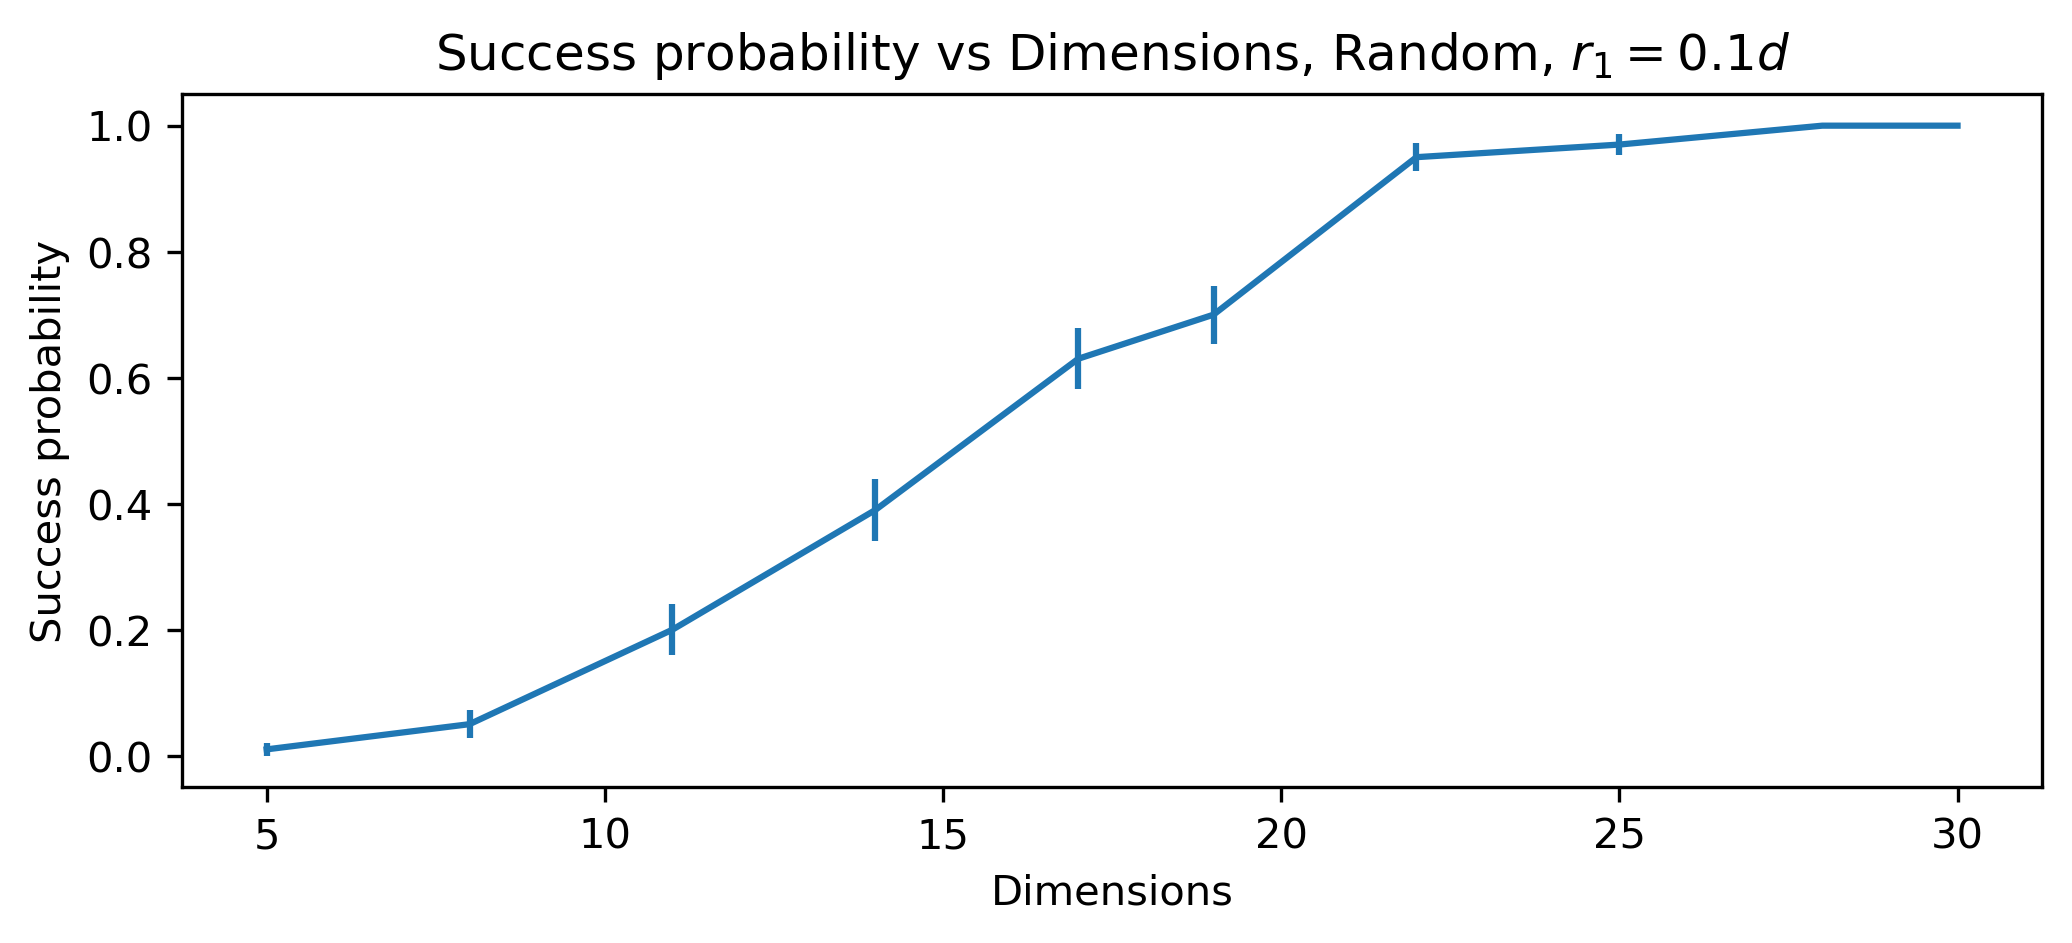

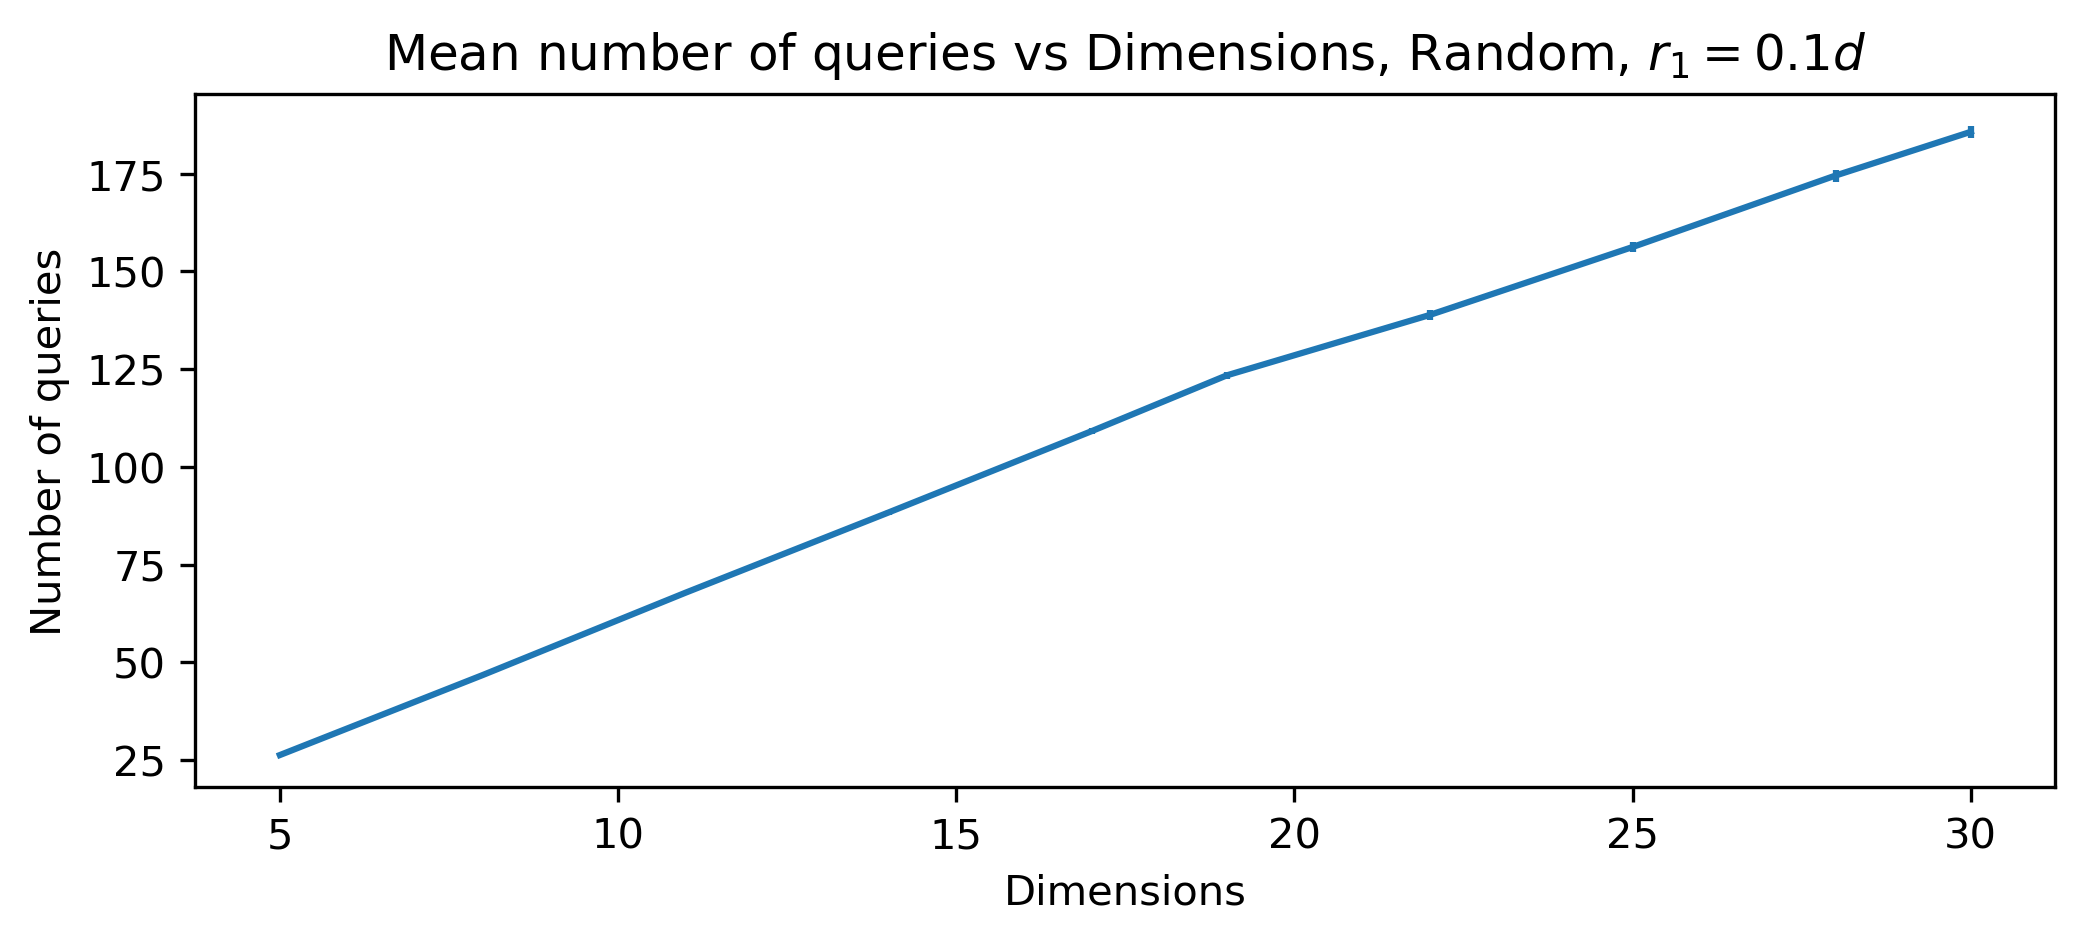

In [145]:
data_succ_prob, data_queries = process_results(res)
points_var_data = prepare_plot_data(res, r1_grid, lsh_params)
make_double_plots(points_var_data, 'Random, $r_1 = 0.1 d$', xlabel="Dimensions", suffix="dimensions-adapt")

In [243]:
d_grid_size = 30
r_grid_size = 30
d_grid_1d = np.linspace(50, 300, num=d_grid_size, dtype=int)
frac_grid = np.linspace(0, 0.3, num=r_grid_size)
d_grid, frac_grid = np.meshgrid(d_grid_1d, frac_grid)

r1_grid = np.ceil(d_grid * frac_grid)
r1_grid = np.maximum(r1_grid, 1).astype(int)

r2_grid = r1_grid * 2
r2_grid = np.minimum(r2_grid, d_grid - 1)

res = run_advanced_grid_experiment([d_grid.flatten(), r1_grid.flatten(), r2_grid.flatten()], ['d', 'r1', 'r2'], ['points', 'lsh', 'lsh'], env, point_params, lsh_params, exp_params, data_dir=DATA_DIR)

In [189]:
prob_data, queries_data = process_results(res)

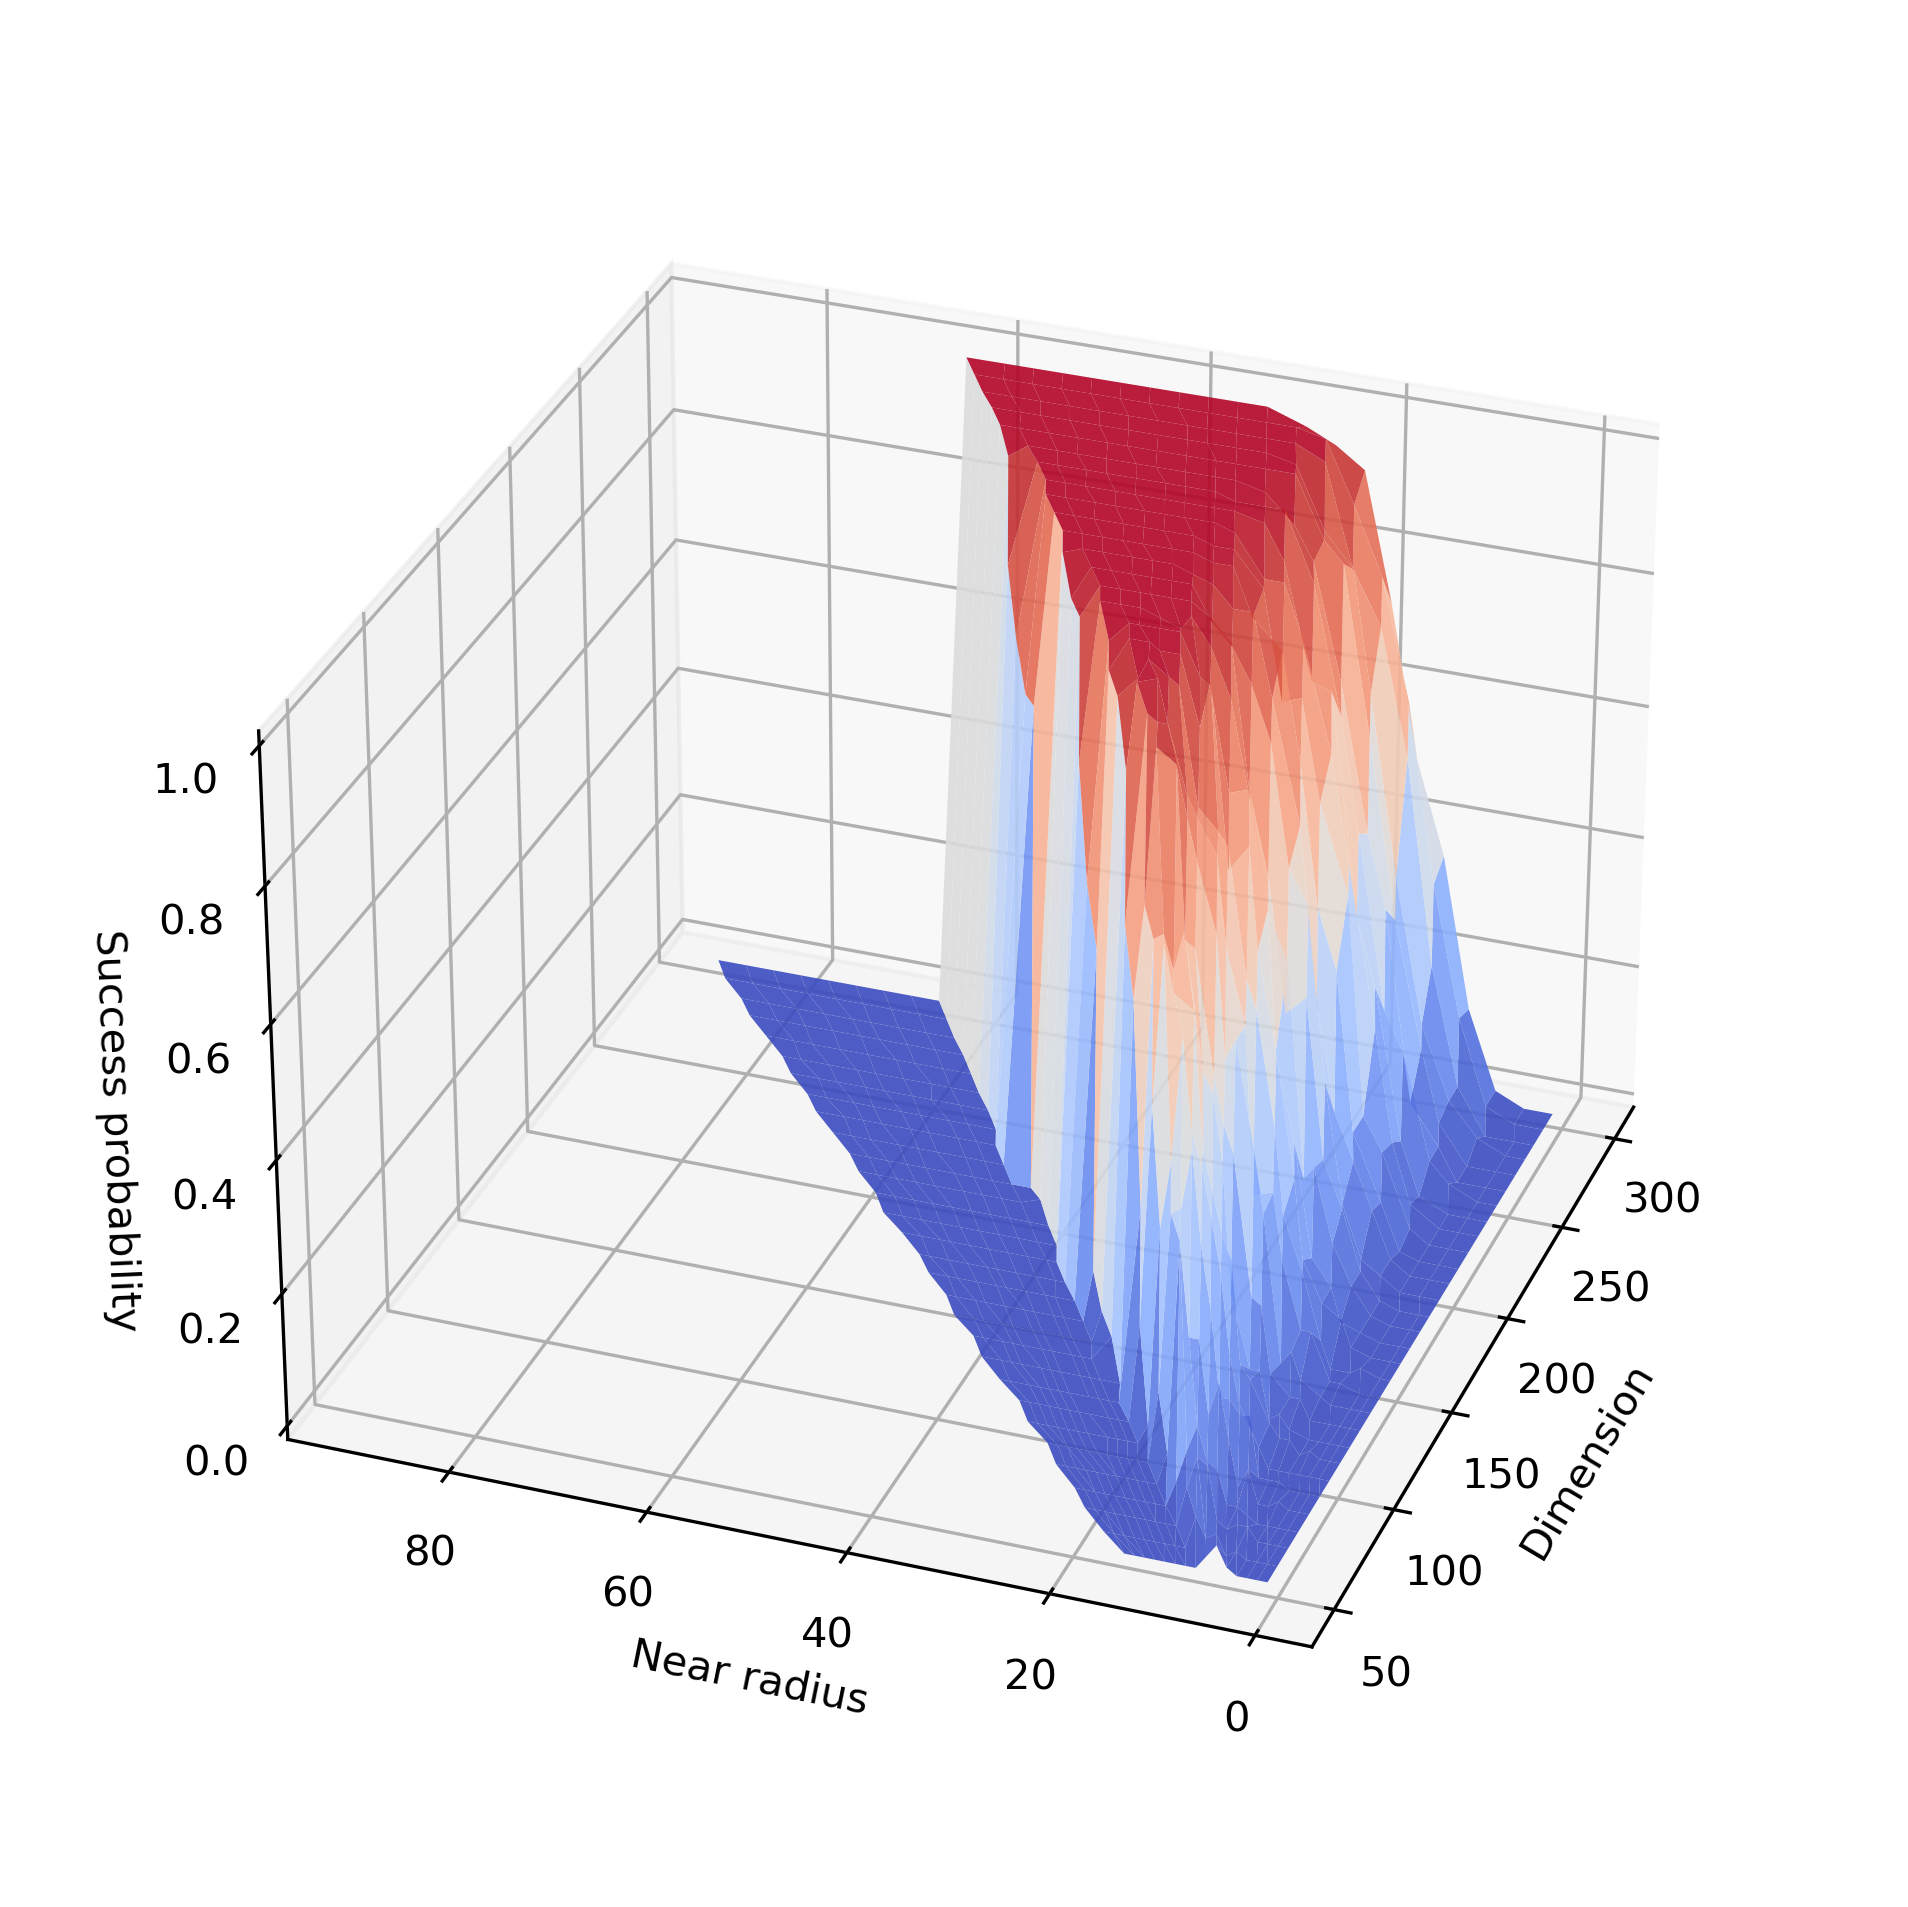

In [251]:
%matplotlib inline

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

prob_2d = np.reshape(prob_data[0], (d_grid_size, r_grid_size))

ax.plot_surface(d_grid, r1_grid, prob_2d, cmap=cm.coolwarm, alpha=0.9)
ax.view_init(elev=30, azim=200)
ax.set_xlabel("Dimension")
ax.set_ylabel("Near radius")
ax.set_zlabel("Success probability")
ax.set_box_aspect(aspect=None, zoom=0.9)
save_fig(f"radius-vs-dimension-3d")
plt.show()

In [246]:
prob_2d = np.reshape(prob_data[0], (d_grid_size, r_grid_size))
cutoff = 0.8

min_r_vals = np.zeros(d_grid_size)
max_r_vals = np.zeros(d_grid_size)
for i in range(d_grid_size):
    min_r_vals[i] = r1_grid[i].max()
    for j, v in enumerate(prob_2d[:, i]):
        if v > cutoff:
            min_r_vals[i] = np.min((min_r_vals[i], r1_grid[i, j]))
            max_r_vals[i] = r1_grid[i, j]

# min_r_vals[min_r_vals > max_r_vals] = 0

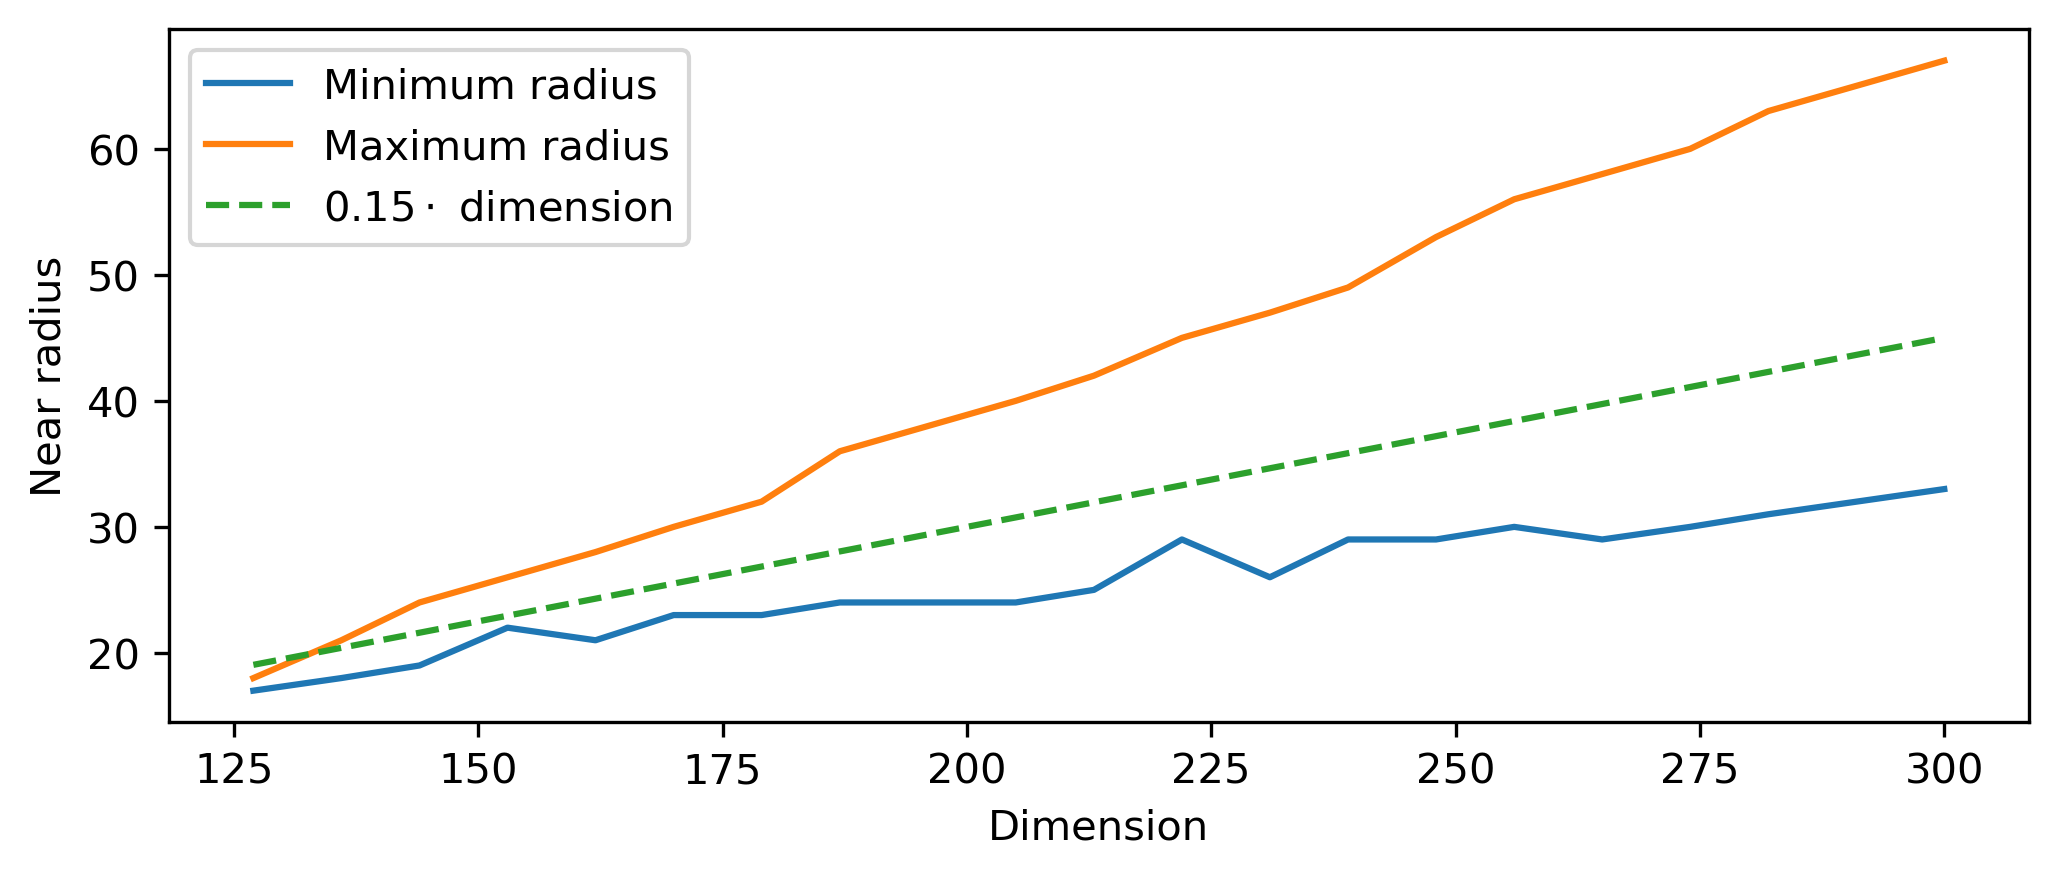

In [262]:
mask = min_r_vals <= max_r_vals
plt.plot(d_grid_1d[mask], min_r_vals[mask], label='Minimum radius')
plt.plot(d_grid_1d[mask], max_r_vals[mask], label="Maximum radius")
plt.plot(d_grid_1d[mask], d_grid_1d[mask] * 0.15, linestyle='dashed', label="$0.15 \cdot $ dimension")
plt.xlabel("Dimension")
plt.ylabel("Near radius")
plt.legend()
save_fig(f"radius-vs-dimension")

plt.show()

## Success chance tests

In [3]:
points = np.zeros((n, d), dtype=int)

lsh = HammingLSH(points, r1, r2, delta)

NameError: name 'n' is not defined

In [4]:
grid = np.arange(r2 + 2)
vals = np.zeros(r2 + 2)
for dist in tqdm(grid):
    repeats = 100
    success = 0
    for j in range(repeats):
        for j in range(300):
            q = np.zeros(d, dtype=int)
            q[rng.choice(d, dist, replace=False)] = 1
            res = lsh.query(q)
            if res is None:
                success += 1
                break
    vals[dist] = success / repeats

NameError: name 'r2' is not defined

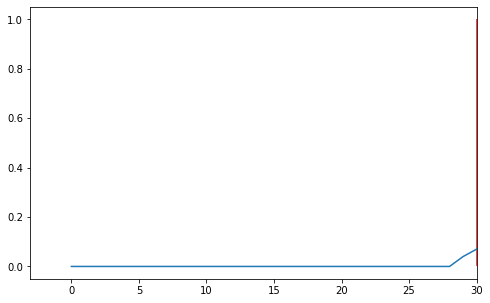

In [28]:
plt.plot(grid, vals)
plt.vlines([r1], 0, 1, colors=['red'])
plt.xlim(None, 30)
plt.show()

In [10]:
print("Success rate at r1:", vals[r1])

Success rate at r1: 1.0


## MNIST

In [275]:
env = Environment()

# d_mnist_eff = 300

point_params = {
    'n': 8000,
    'd': 784,
    'point_type': "mnist_binary",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/16,
    'seed_offset': 0,
    'r1': int(point_params['d'] * 0.15),
    'r2': int(point_params['d'] * 0.3)
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 100,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
    'origin': 'random',
}

### Analysing dependance on t

In [ ]:
t_grid = np.linspace(0, lsh_params['r1'] + 1, num=30, dtype=int)
new_exp_param = exp_params.copy()
res = run_basic_grid_experiment(t_grid, 't', env, point_params, lsh_params, new_exp_param, DATA_DIR)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
mnist_data = process_results_with_grid(res, t_grid, lsh_params)

In [ ]:
make_double_plots(mnist_data, 'MNIST')

## Anonymous Microsoft Web Data

In [267]:
env = Environment()


point_params = {
    'n': 8000,
    'd': 294,
    'point_type': "msweb",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/16,
    'seed_offset': 0,
    'r1': int(point_params['d'] * 0.15),
    'r2': int(point_params['d'] * 0.3)
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 100,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
    'origin': 'random',
}

### Analysing dependance on t

In [268]:
t_grid = np.arange(0, lsh_params['r1'] + 1, 1)
new_exp_param = exp_params.copy()
res = run_basic_grid_experiment(t_grid, 't', env, point_params, lsh_params, new_exp_param, DATA_DIR)

  0%|          | 0/31 [00:00<?, ?it/s]

In [269]:
msweb_data = process_results_with_grid(res, t_grid, lsh_params)

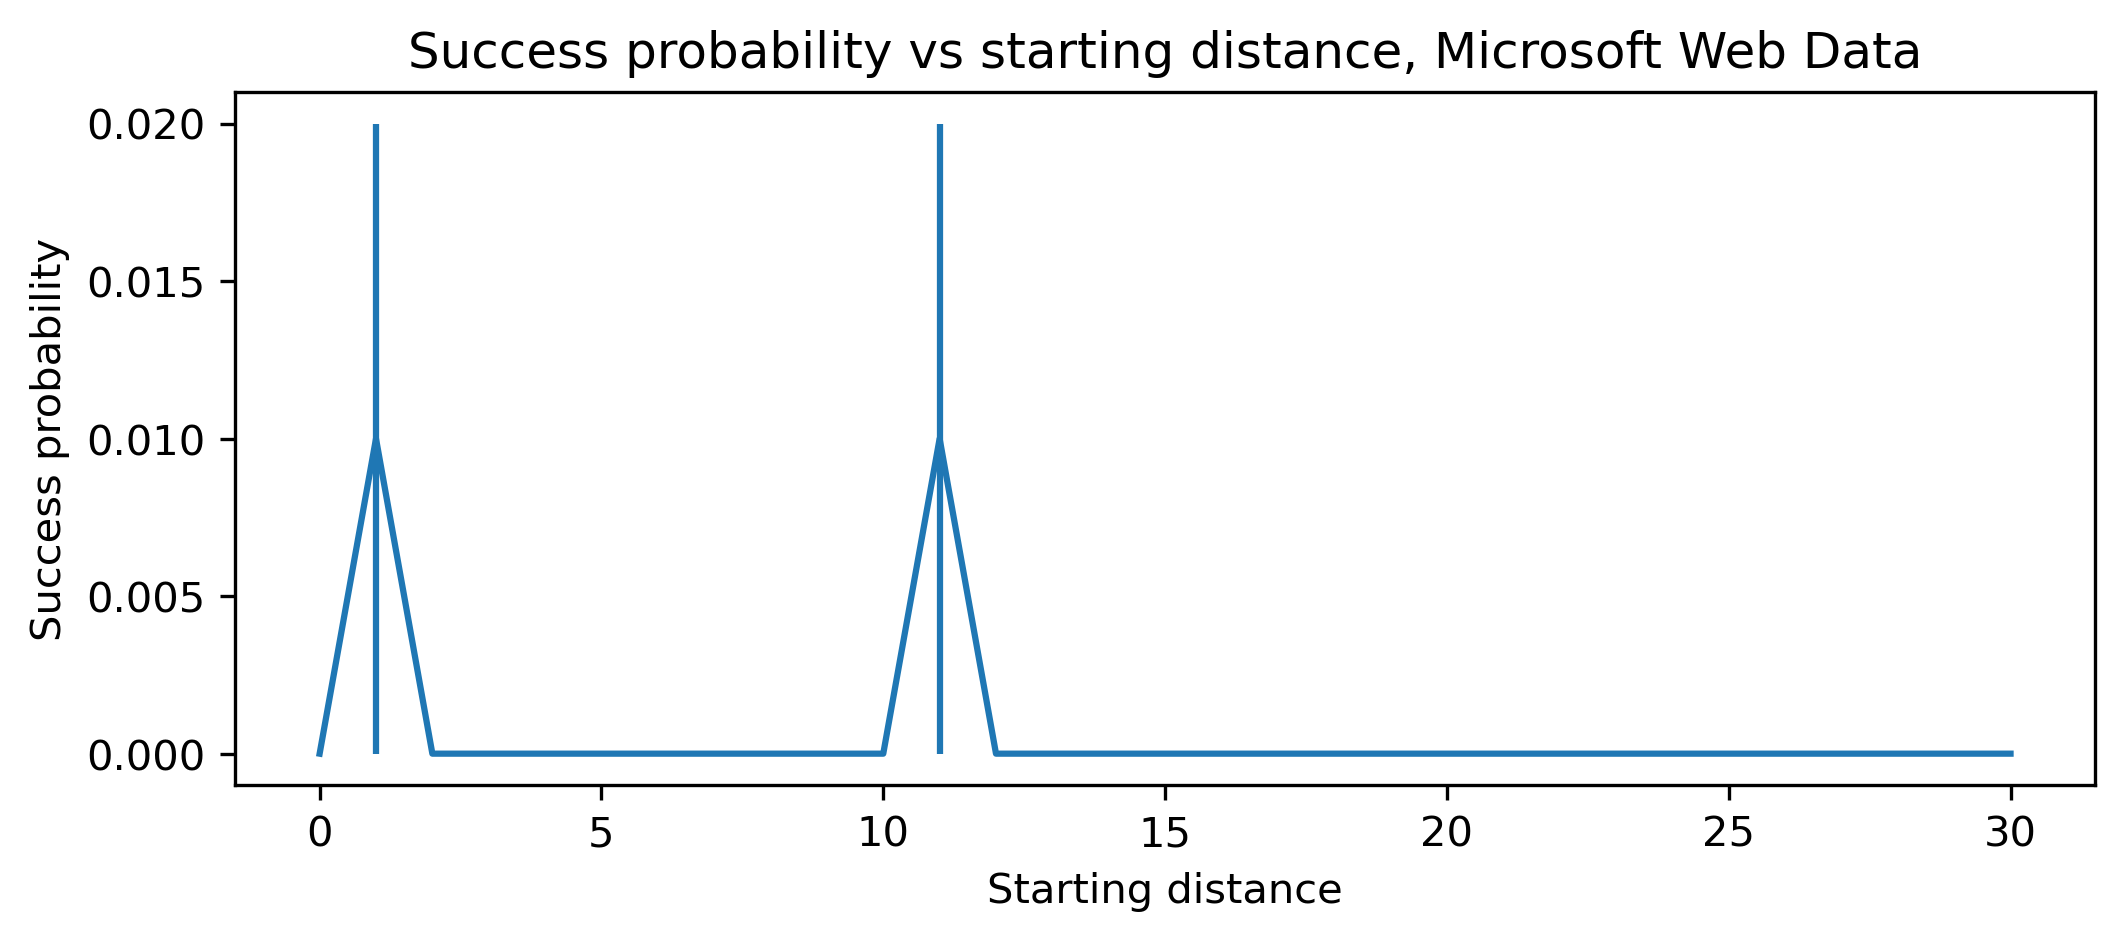

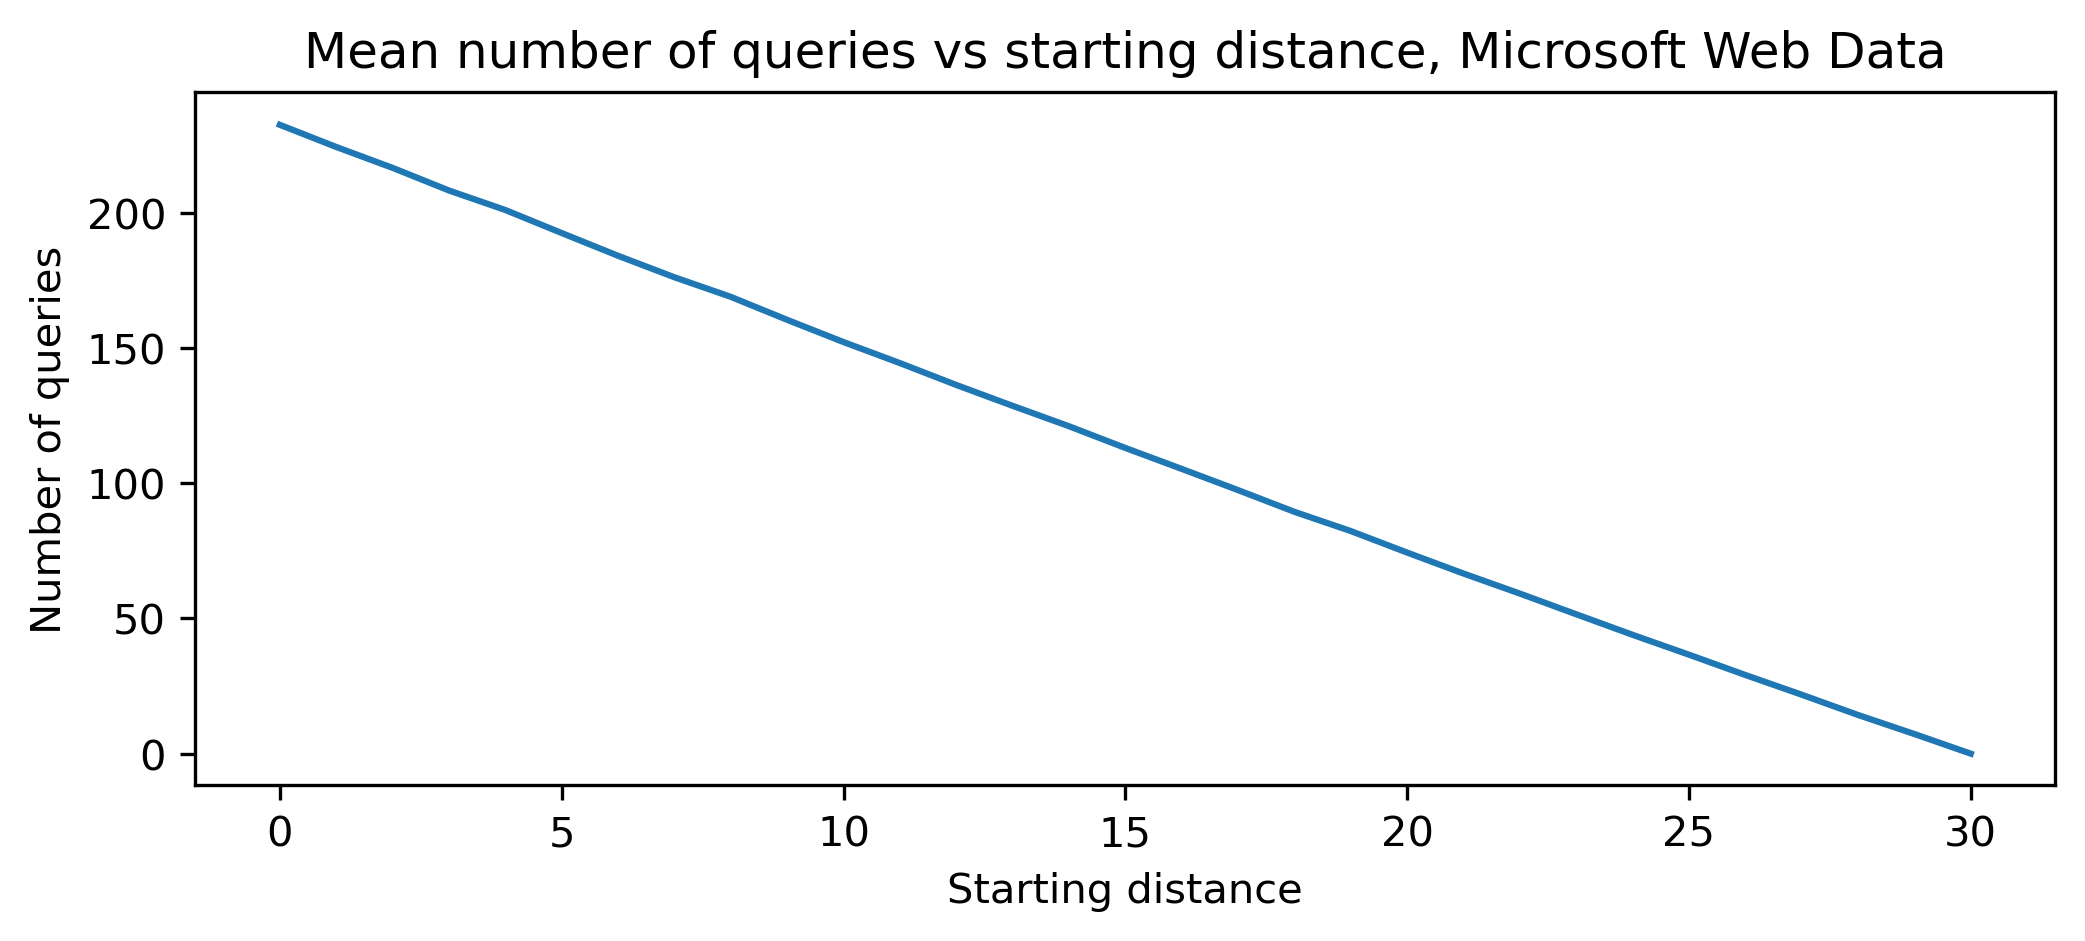

In [270]:
make_double_plots(msweb_data, 'Microsoft Web Data')

## Mushroom

In [271]:
env = Environment()


point_params = {
    'n': 8000,
    'd': 116,
    'point_type': "mushroom",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/16,
    'seed_offset': 0,
    'r1': int(point_params['d'] * 0.15),
    'r2': int(point_params['d'] * 0.3)
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 100,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
    'origin': 'random',
}

### Analysing dependance on t

In [272]:
t_grid = np.arange(0, lsh_params['r1'] + 1, 1)
new_exp_param = exp_params.copy()
res = run_basic_grid_experiment(t_grid, 't', env, point_params, lsh_params, new_exp_param, DATA_DIR)

  0%|          | 0/31 [00:00<?, ?it/s]

In [273]:
mushroom_data = process_results_with_grid(res, t_grid, lsh_params)

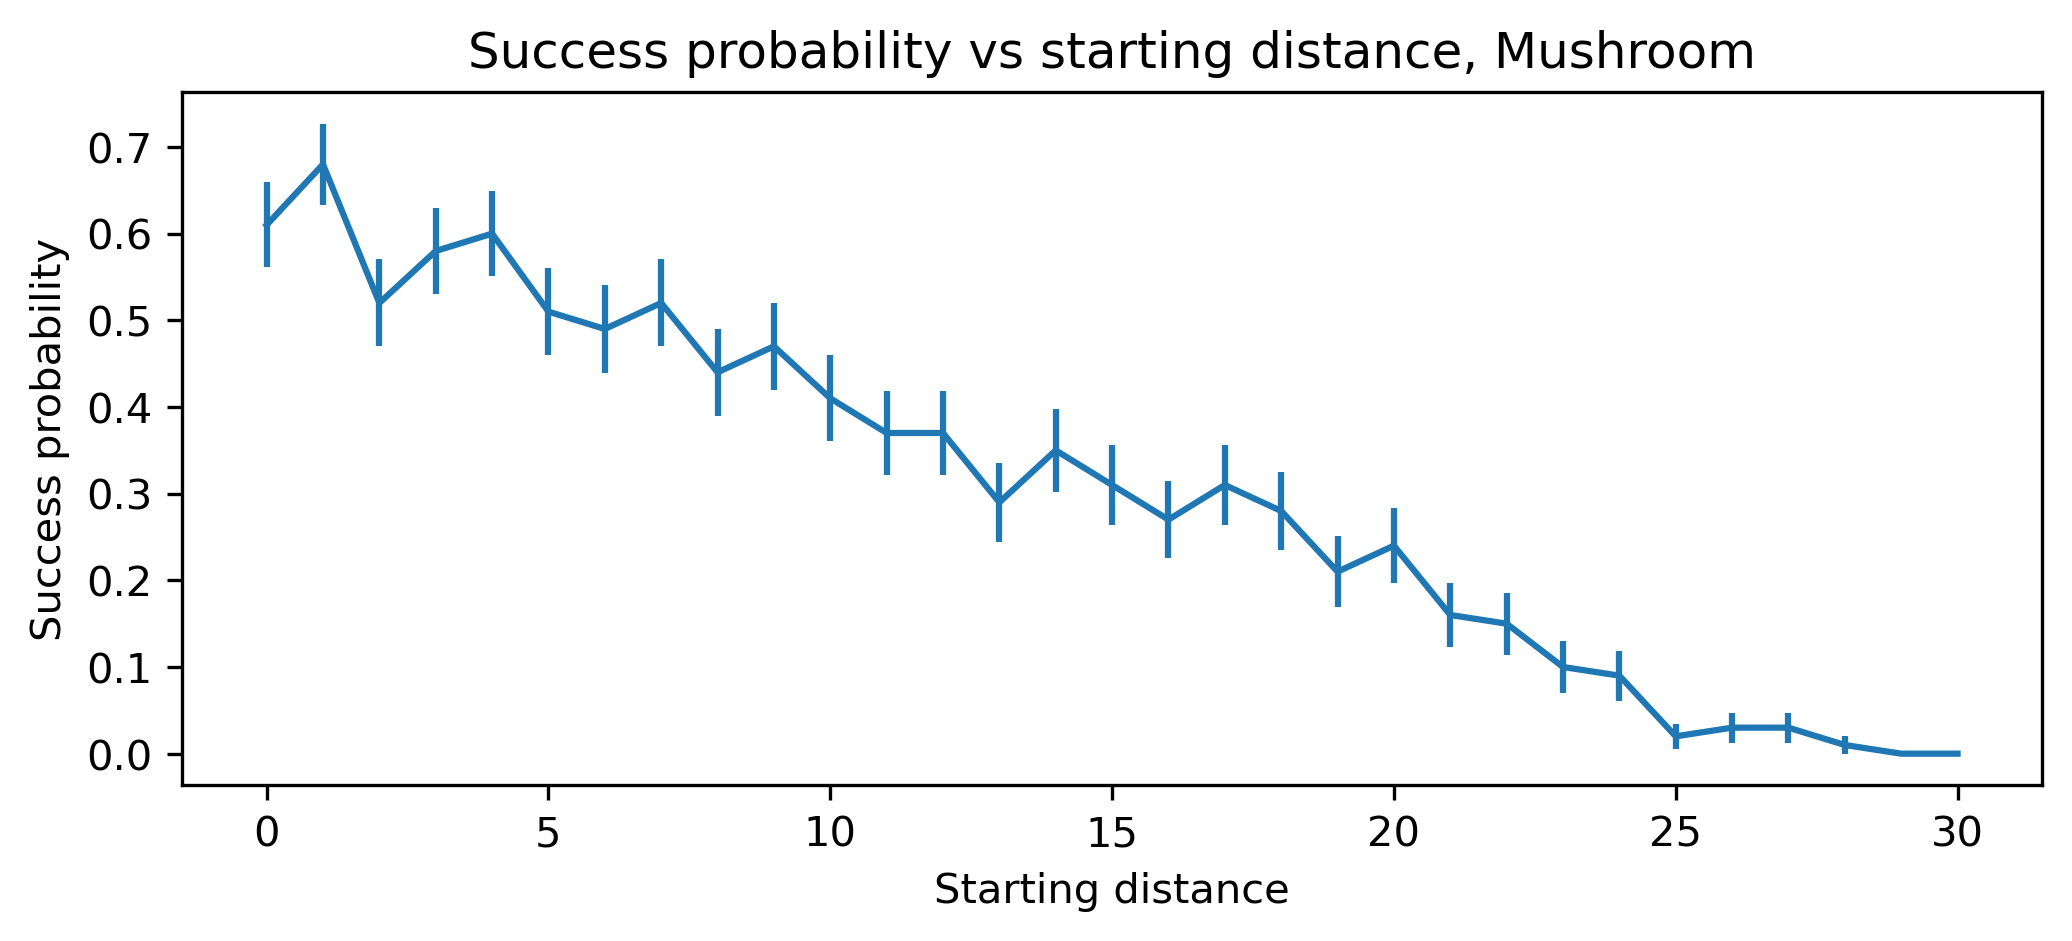

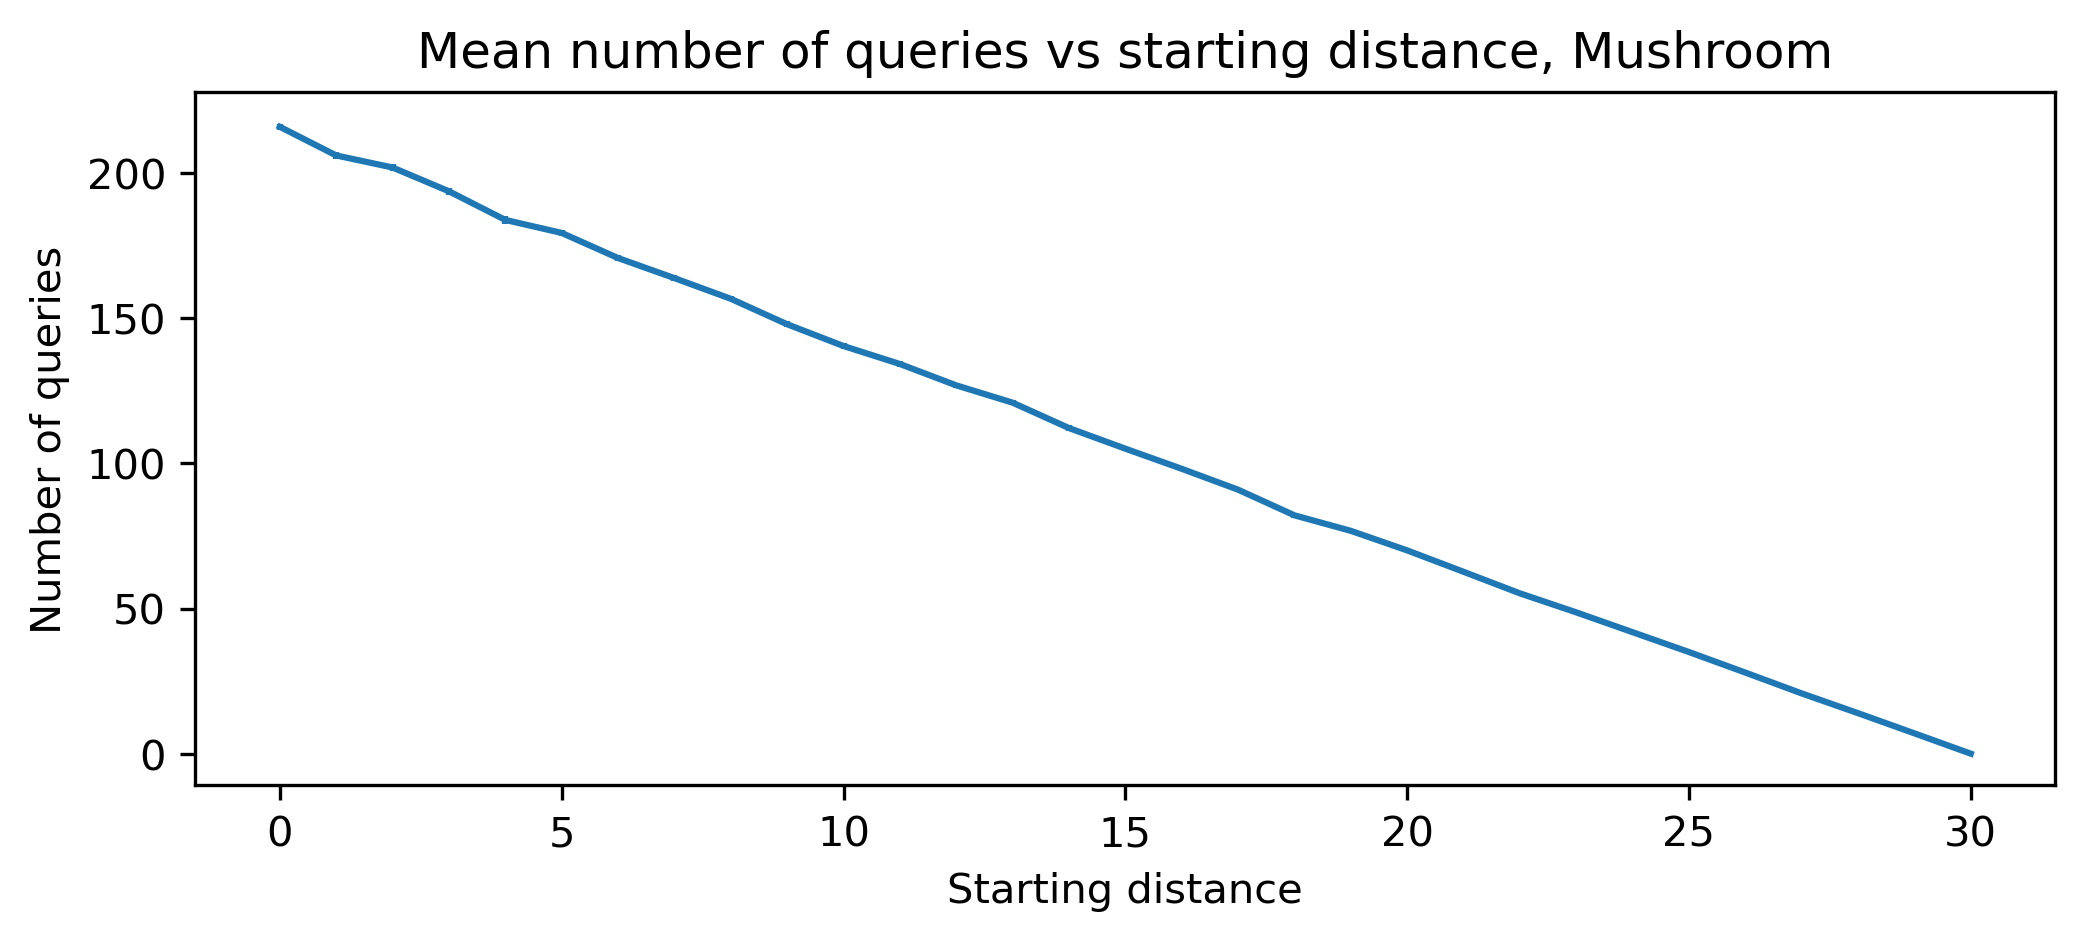

In [275]:
make_double_plots(mushroom_data, 'Mushroom')

## Sparse random points

In [276]:
env = Environment()

point_params = {
    'n': 8000,
    'd': 300,
    'point_type': "random",
    'sample_probability': 1/15,
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/16,
    'seed_offset': 0,
    'r1': int(point_params['d'] * 0.15),
    'r2': int(point_params['d'] * 0.3)
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 100,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
    'origin': 'random',
}

### Analysing dependance on t

In [277]:
t_grid = np.arange(0, lsh_params['r1'] + 1, 1)
new_exp_param = exp_params.copy()
res = run_basic_grid_experiment(t_grid, 't', env, point_params, lsh_params, new_exp_param, DATA_DIR)

  0%|          | 0/31 [00:00<?, ?it/s]

In [278]:
sparse_data = process_results_with_grid(res, t_grid, lsh_params)

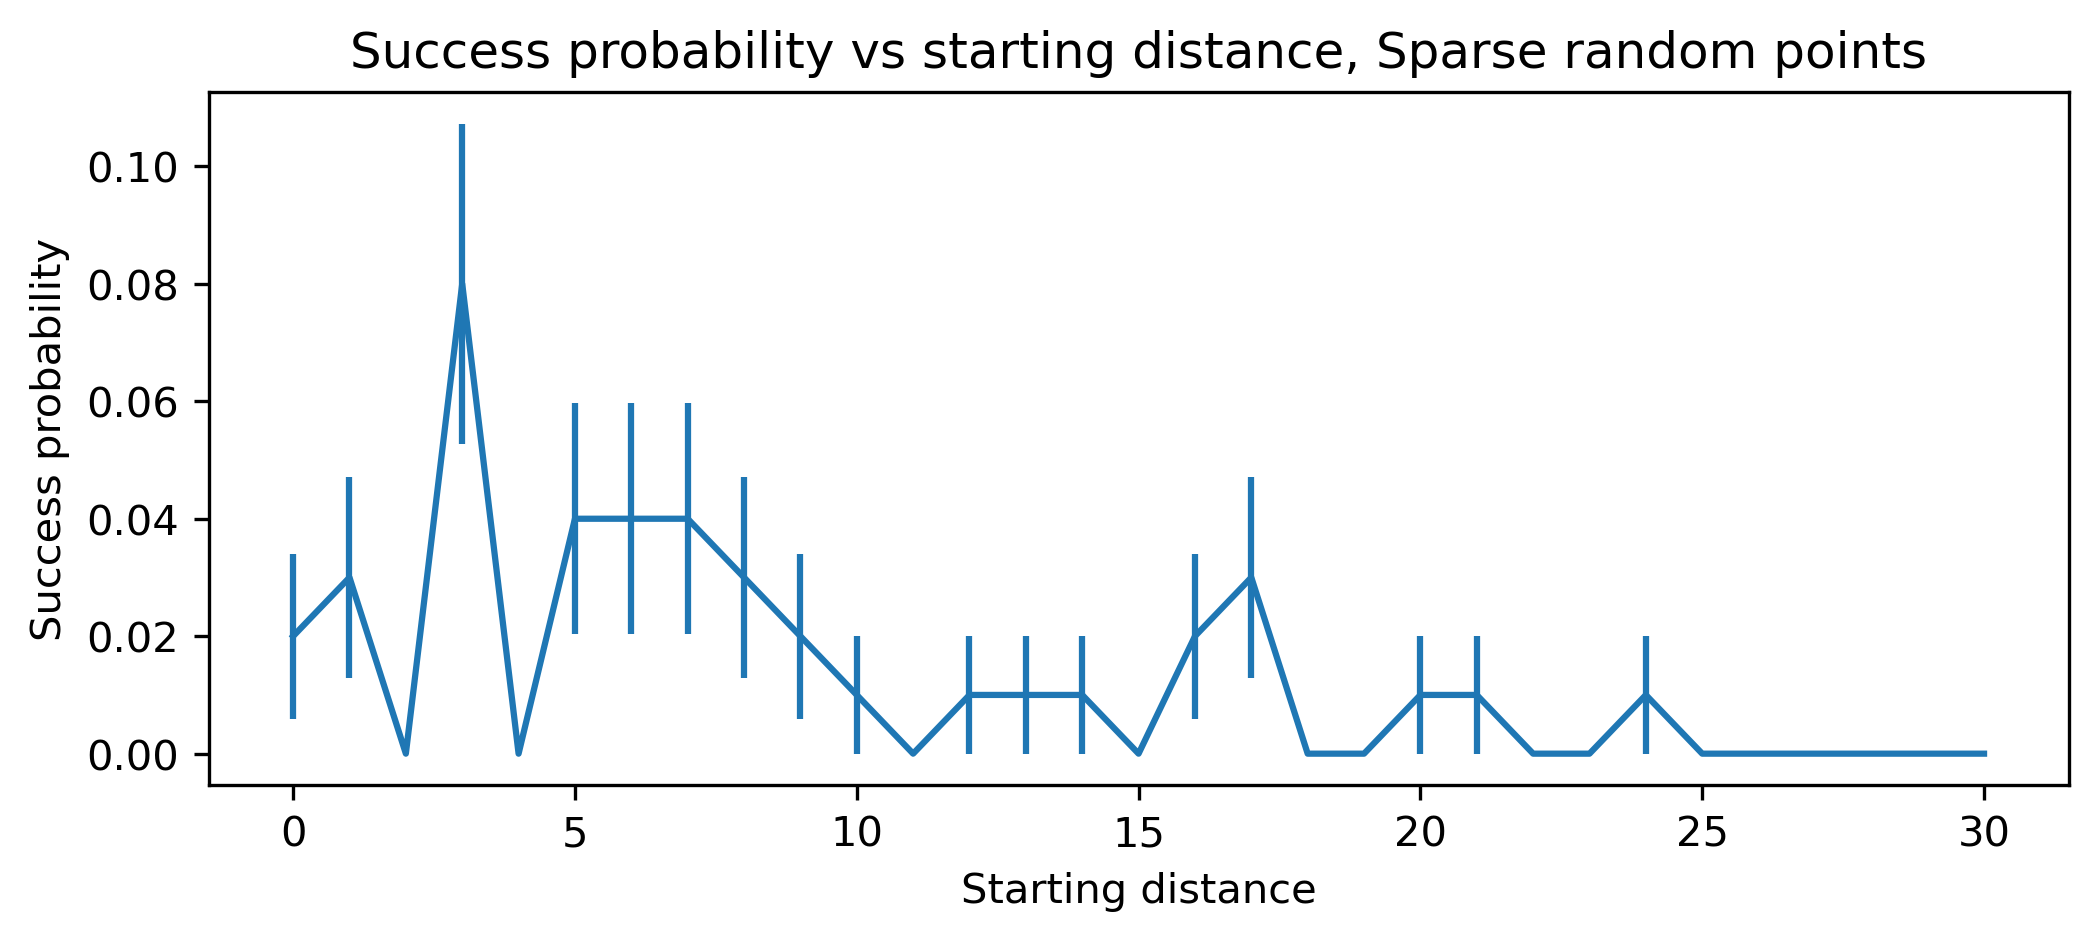

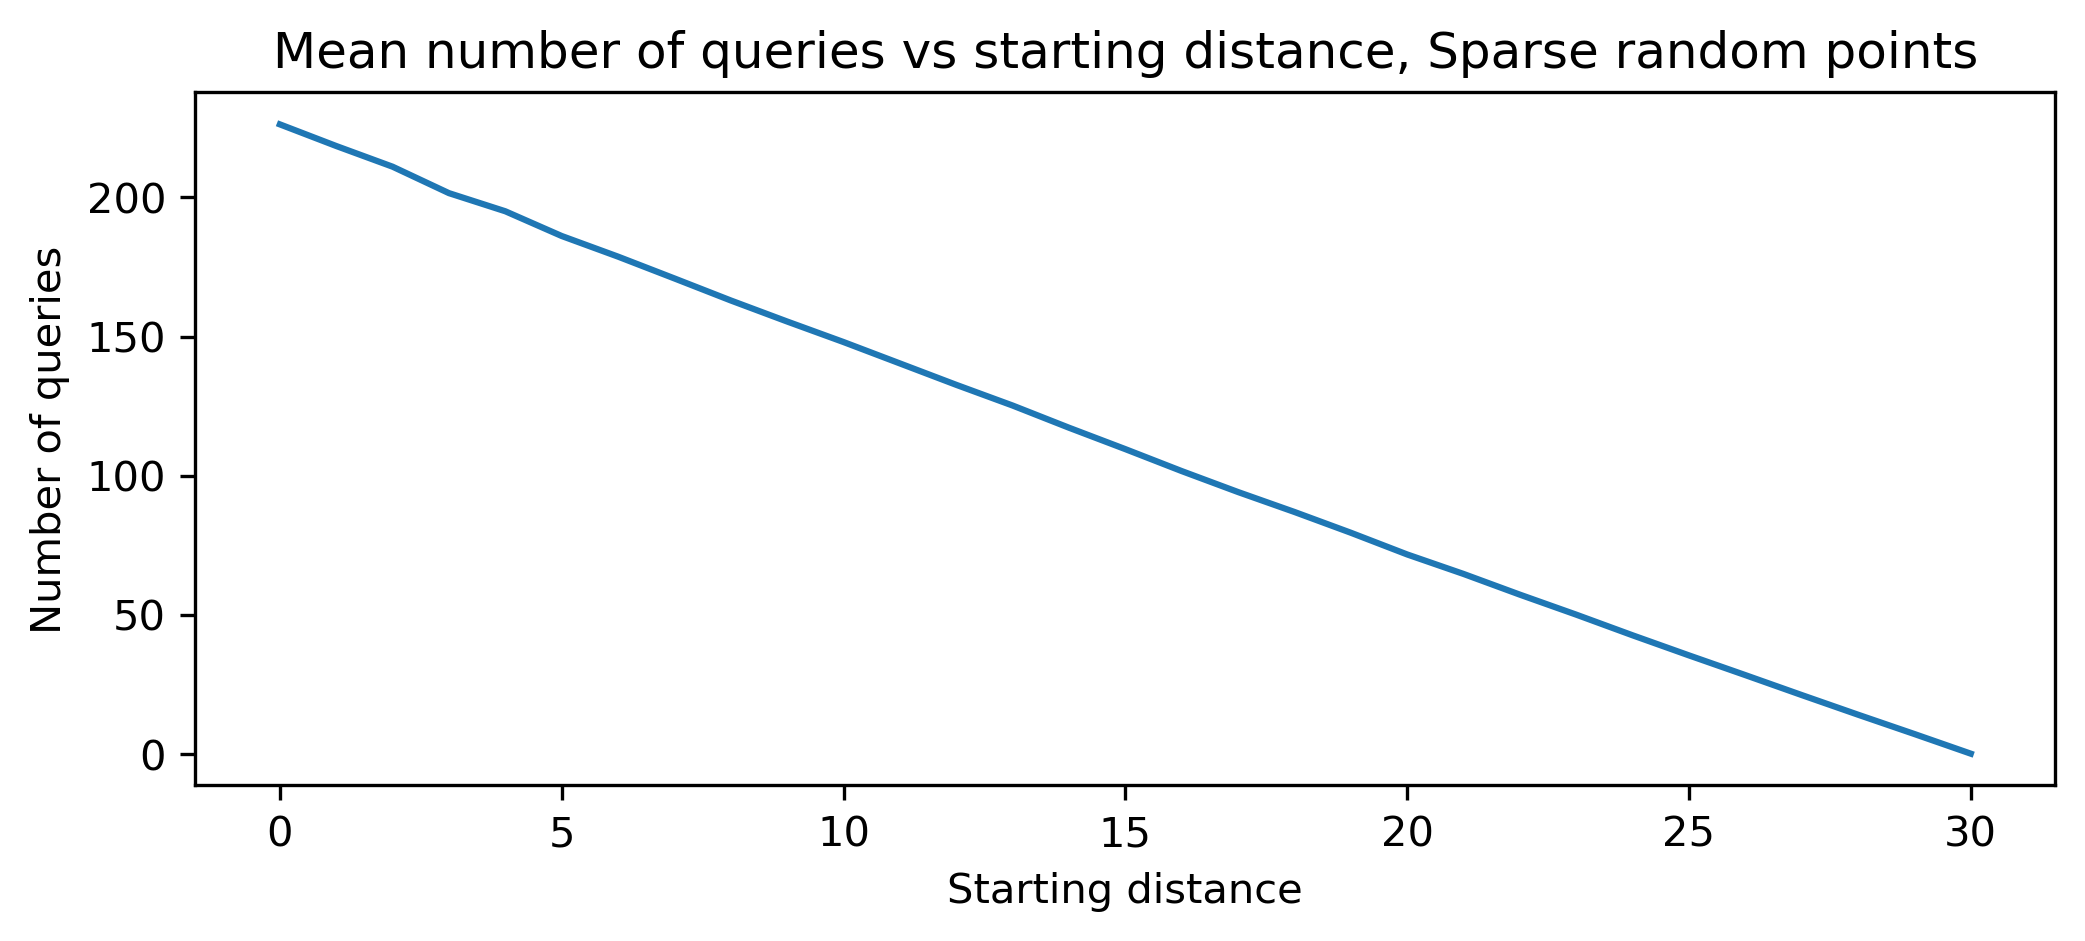

In [279]:
make_double_plots(sparse_data, 'Sparse random points')

# Breaking hamming LSH faster

In [245]:
env = Environment()

point_params = {
    'n': 8000,
    'd': 300,
    'point_type': "zero",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/16,
    'seed_offset': 0,
    'r1': int(point_params['d'] * 0.15),
    'r2': int(point_params['d'] * 0.3)
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 100,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
}

### Analysing dependance on t

In [246]:
t_grid = np.arange(0, lsh_params['r1'] + 1, 1)
new_exp_param = exp_params.copy()
res = run_basic_grid_experiment(t_grid, 't', env, point_params, lsh_params, new_exp_param, DATA_DIR)

  0%|          | 0/31 [00:00<?, ?it/s]

In [247]:
zero_data = process_results_with_grid(res, t_grid, lsh_params)

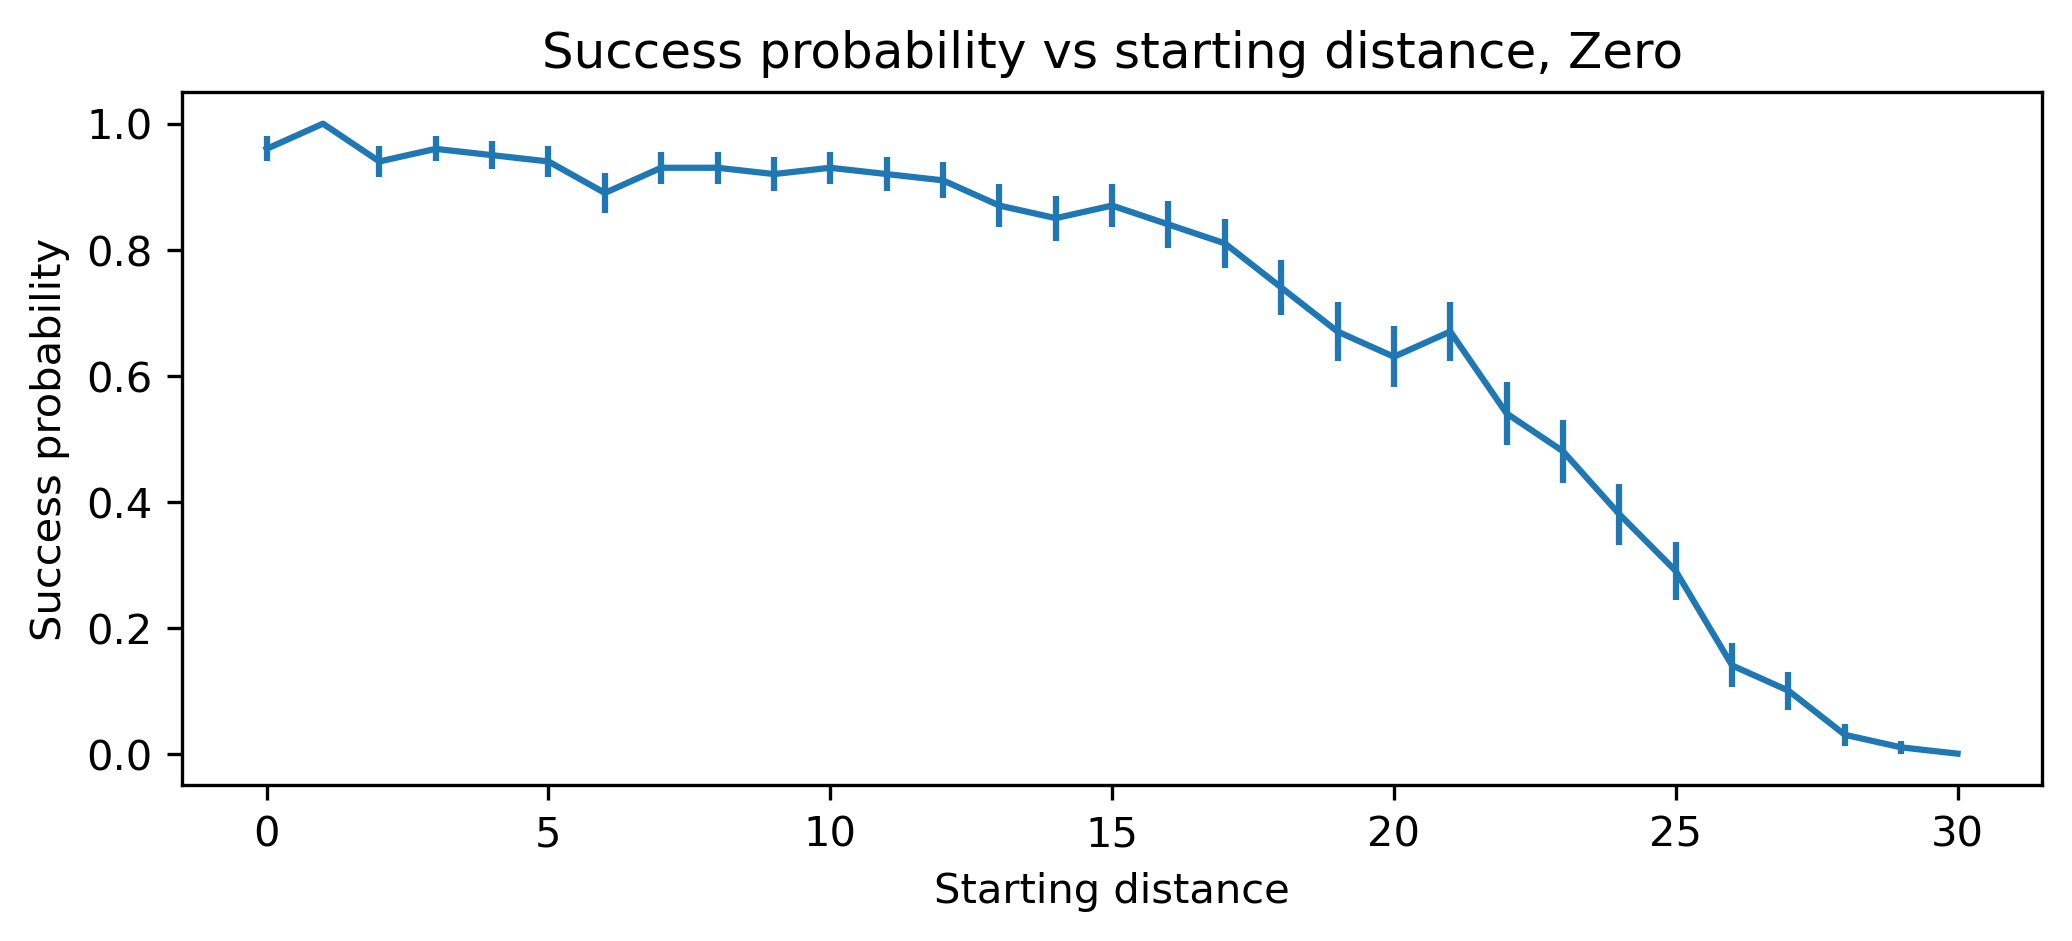

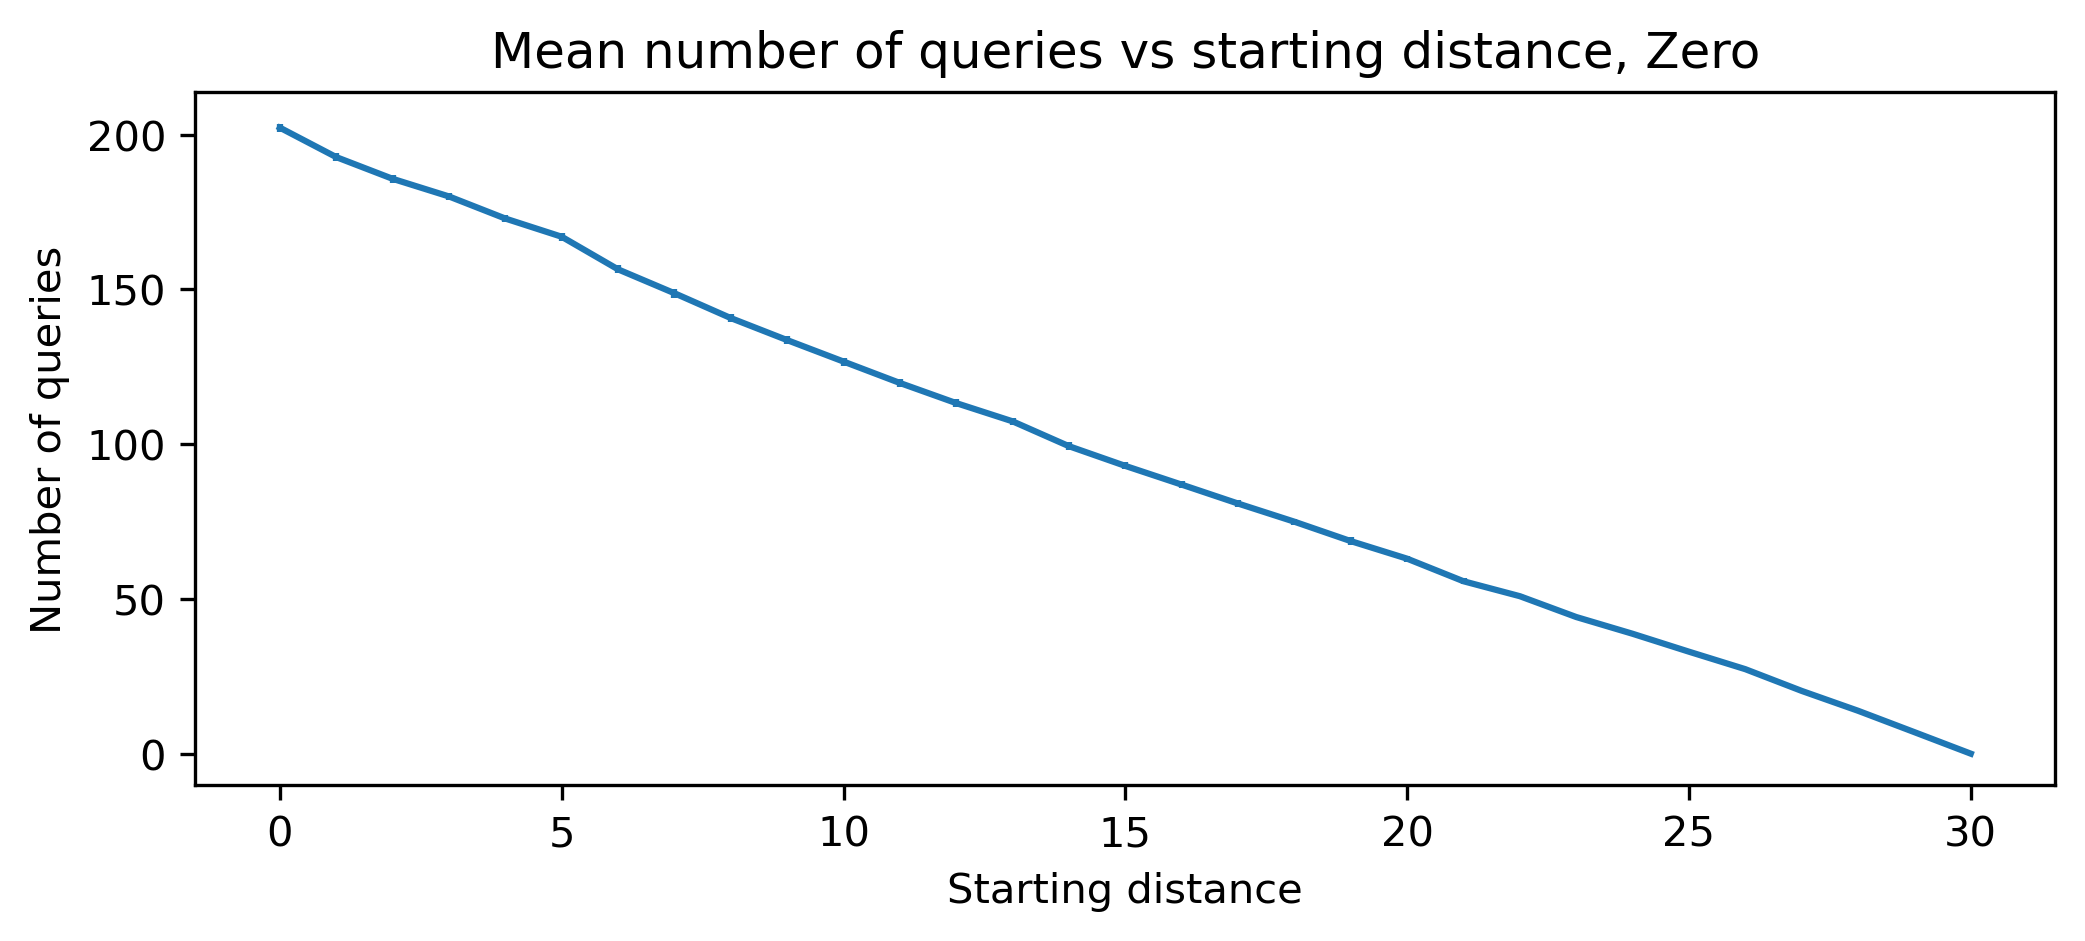

In [248]:
make_double_plots(zero_data, 'Zero')

### Dependance on $t$ with random points

In [251]:
env = Environment()

point_params = {
    'n': 8000,
    'd': 300,
    'point_type': "random",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/16,
    'seed_offset': 0,
    'r1': int(point_params['d'] * 0.15),
    'r2': int(point_params['d'] * 0.3)
}

exp_params = {
    'alg_type': 'adaptive',
    'change_points': True,
    'iter_num': 100,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
}

In [252]:
t_grid = np.arange(0, lsh_params['r1'] + 1, 1)
res = run_basic_grid_experiment(t_grid, 't', env, point_params, lsh_params, exp_params, data_dir=DATA_DIR)

  0%|          | 0/31 [00:00<?, ?it/s]

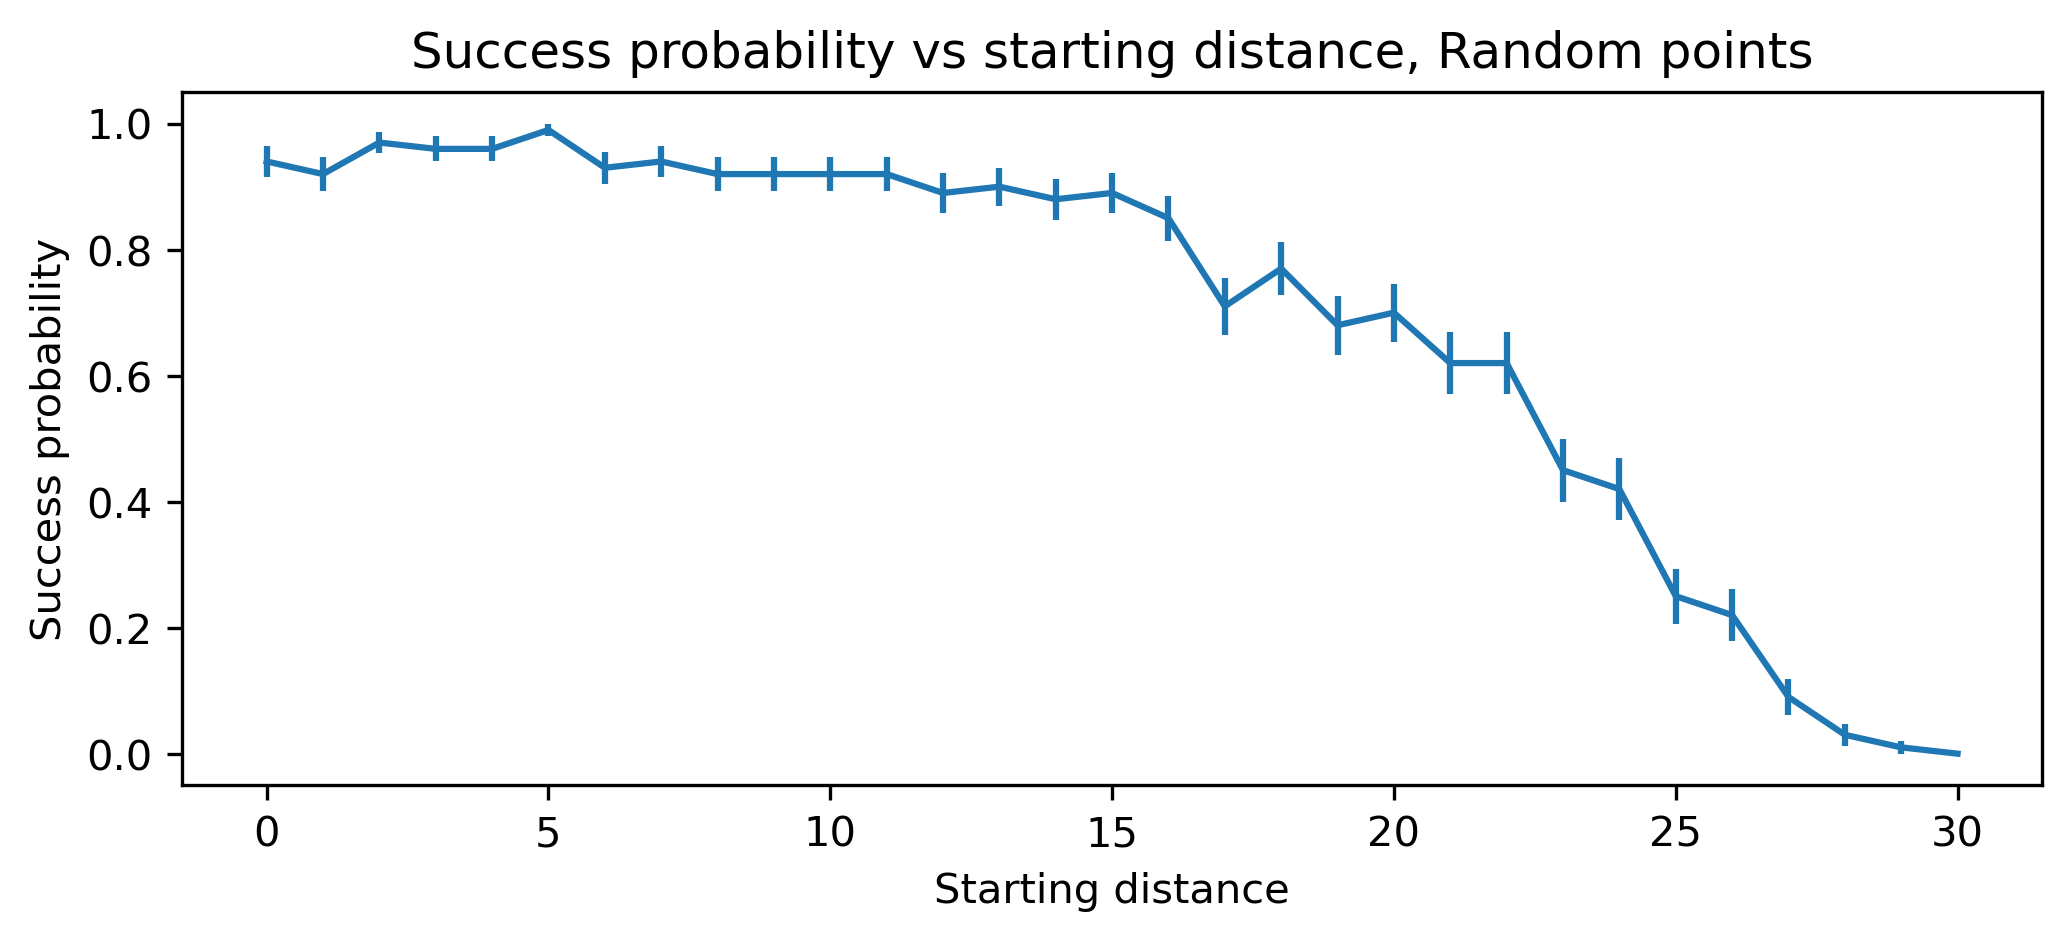

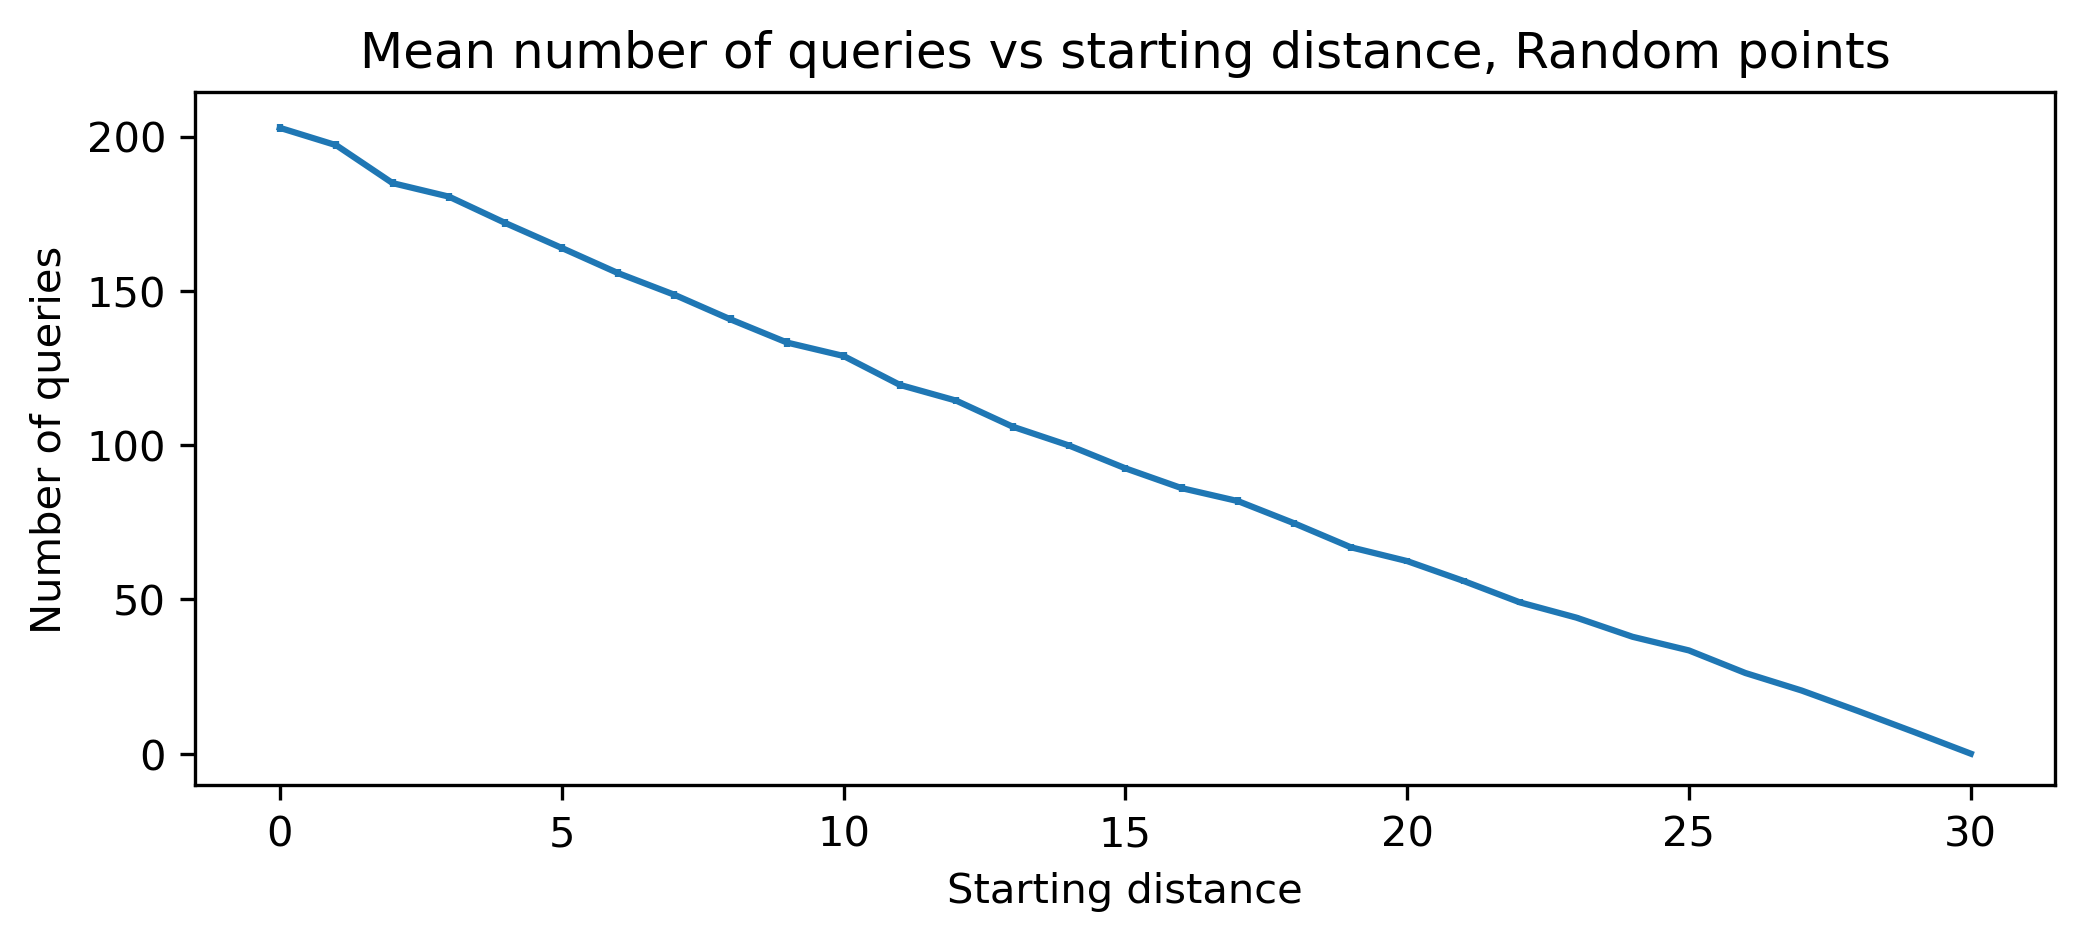

In [253]:
data_succ_prob, data_queries = process_results(res)
rand_data = process_results_with_grid(res, t_grid, lsh_params)
make_double_plots(rand_data, 'Random points')

NameError: name 'rand_data_succ_prob' is not defined

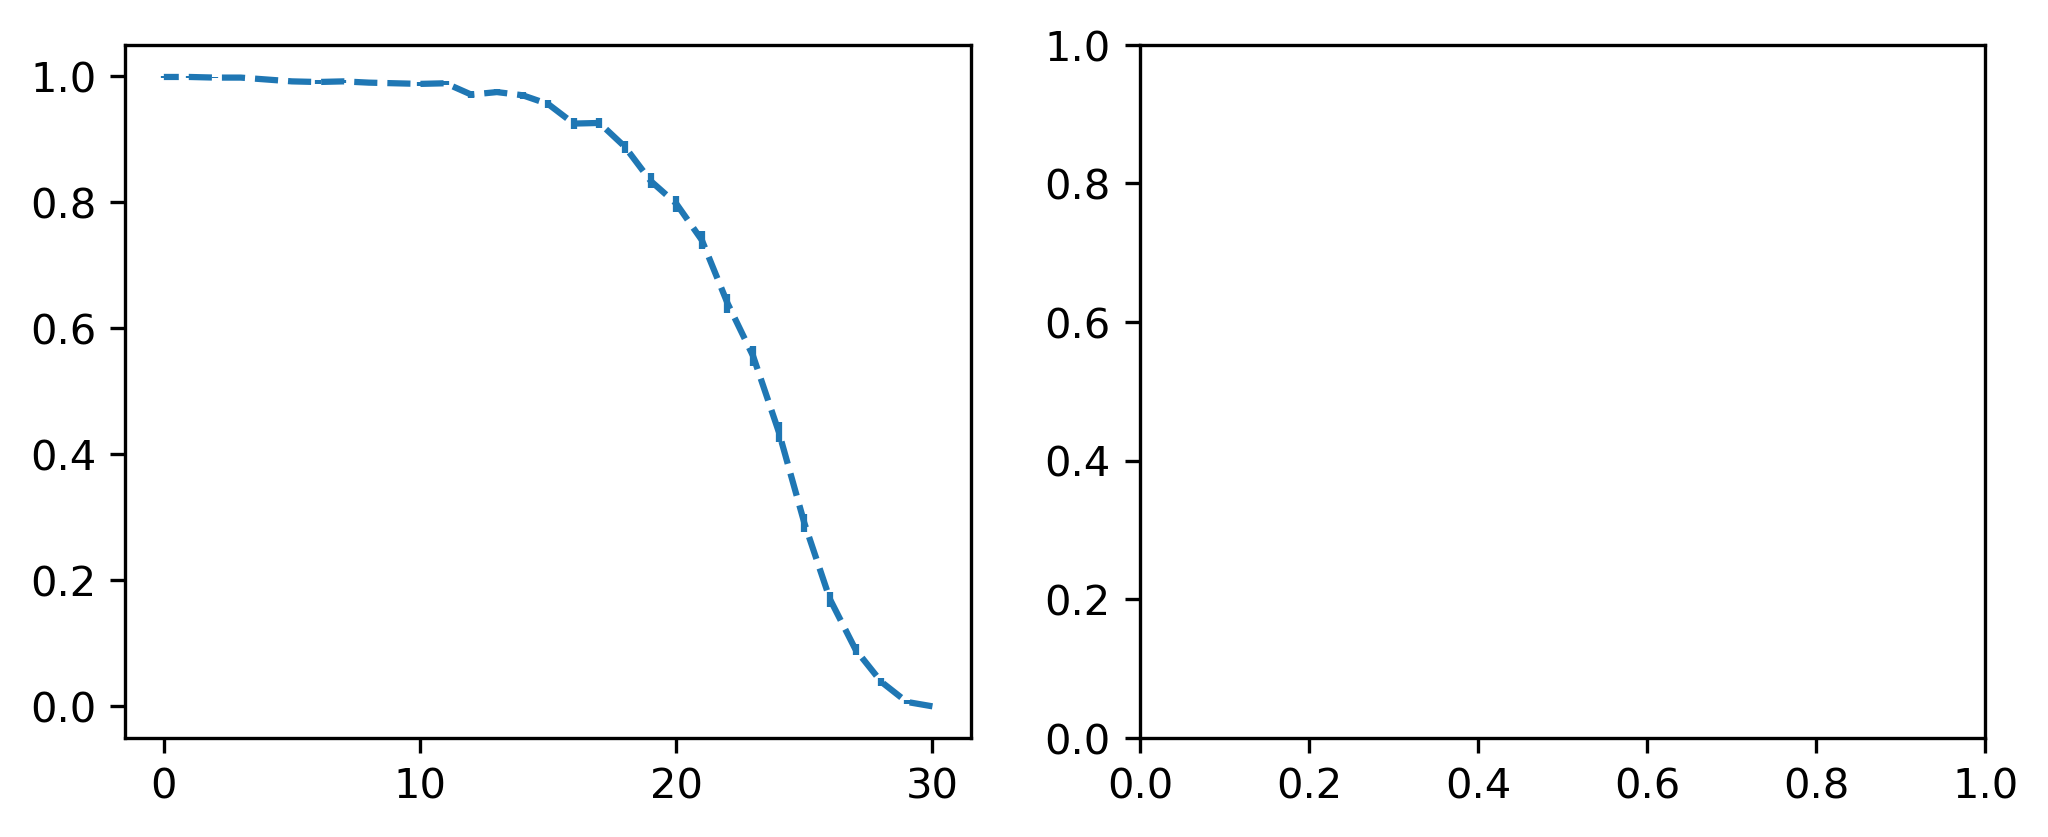

In [29]:
dist_grid = lsh_params['r1'] - t_grid
xlims = (np.min(dist_grid) - 1, np.max(dist_grid) + 1)

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].errorbar(dist_grid, data_succ_prob[0], yerr=data_succ_prob[1], linestyle='--',label="Zeros")
axs[0].errorbar(dist_grid, rand_data_succ_prob[0], yerr=rand_data_succ_prob[1], label="Random points")
axs[0].legend()
# plt.xlim(xlims)
# plt.title("Success probability vs starting distance")
axs[0].set_xlabel("Starting distance")
axs[0].set_ylabel("Success probability")
# save_fig("all-prob-starting-distance")

axs[1].errorbar(dist_grid, data_queries[0], yerr=data_queries[1], linestyle='--', label='Zeros')
axs[1].errorbar(dist_grid, rand_data_queries[0], yerr=rand_data_queries[1], label='Random points')
axs[1].legend()
# plt.xlim(xlims)
# plt.title("Number of queries vs starting distance")
axs[1].set_xlabel("Starting distance")
axs[1].set_ylabel("Number of queries")
fig.tight_layout()
# save_fig("all-queries-starting-distance")
save_fig("all-all-starting-distance")
plt.show()

## All datasets

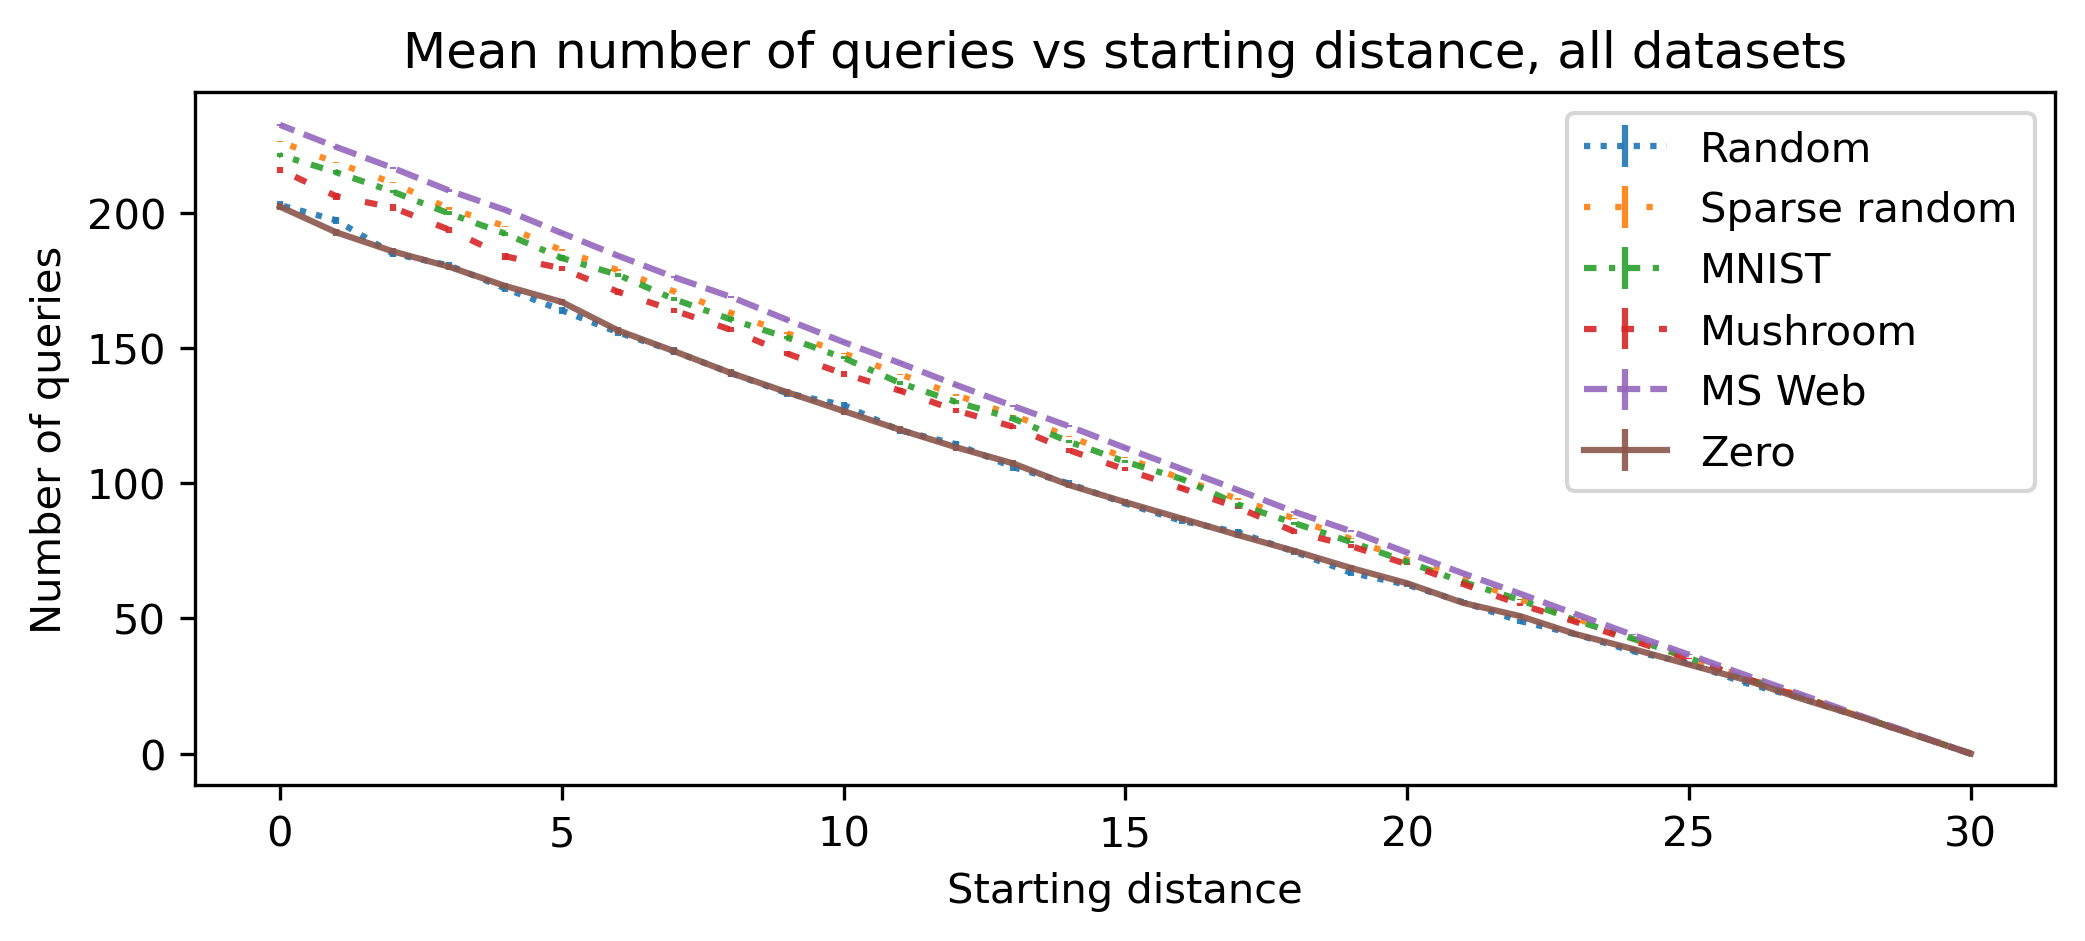

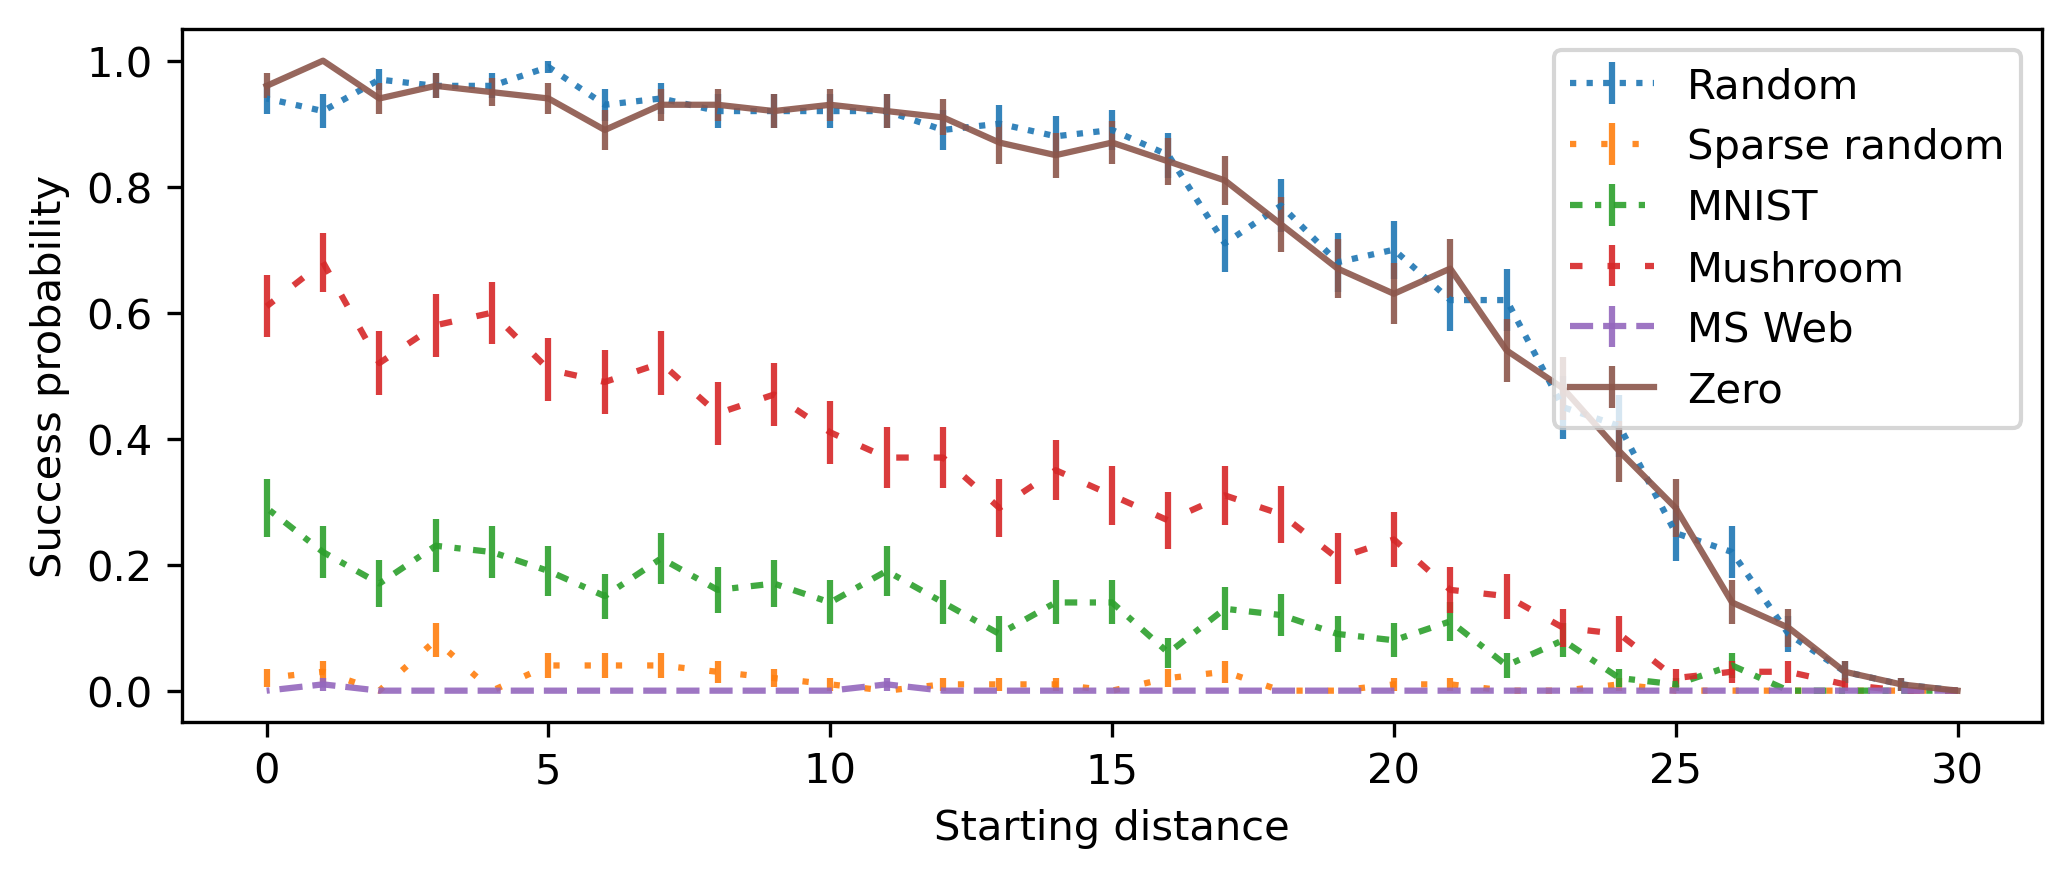

In [280]:
data_list = [
    (rand_data, "Random", 'dotted'),
    (sparse_data, "Sparse random", (0,(1, 4))),
    (mnist_data, "MNIST", (0, (2,2,1,2))),
    (mushroom_data, "Mushroom", (0,(2,4))),
    (msweb_data, "MS Web", 'dashed'),
    (zero_data, "Zero", 'solid'),
]

for data, label, linestyle in data_list:
    plot_data(data, plot_queries=True, label=label, linestyle=linestyle, alpha=0.9)
plt.legend()
# plt.xlim(xlims)
plt.title(f"Mean number of queries vs starting distance, all datasets")
plt.xlabel("Starting distance")
plt.ylabel("Number of queries")
save_fig(f"all-queries-starting-distance")
plt.show()

for data, label, linestyle in data_list:
    plot_data(data, plot_prob=True, label=label, linestyle=linestyle, alpha=0.9)
plt.legend()
# plt.xlim(xlims)
# plt.title(f"Success probability vs starting distance, all datasets")
plt.xlabel("Starting distance")
plt.ylabel("Success probability")
save_fig(f"all-prob-starting-distance")
plt.show()

## Sparsity analysis

In [290]:
env = Environment()

point_params = {
    'n': 8000,
    'd': 300,
    'point_type': "random",
    'sample_probability': 1/500,
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/16,
    'seed_offset': 0,
    'r1': int(point_params['d'] * 0.15),
    'r2': int(point_params['d'] * 0.3)
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 100,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
    'origin': 'random',
}

### Analysing dependance on t

In [297]:
p_grid = [1/2, 1/10, 25/300, 1/100, 1/10000]
sample_prob_res = []

for sample_prob in p_grid:
    cur_point_params = point_params.copy()
    cur_point_params['sample_probability'] = sample_prob
    t_grid = np.arange(0, lsh_params['r1'] + 1, 1)
    new_exp_param = exp_params.copy()
    res = run_basic_grid_experiment(t_grid, 't', env, cur_point_params, lsh_params, new_exp_param, DATA_DIR)
    sample_prob_res.append(res)

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

In [298]:
all_sparse_data = [process_results_with_grid(res, t_grid, lsh_params) for res in sample_prob_res]

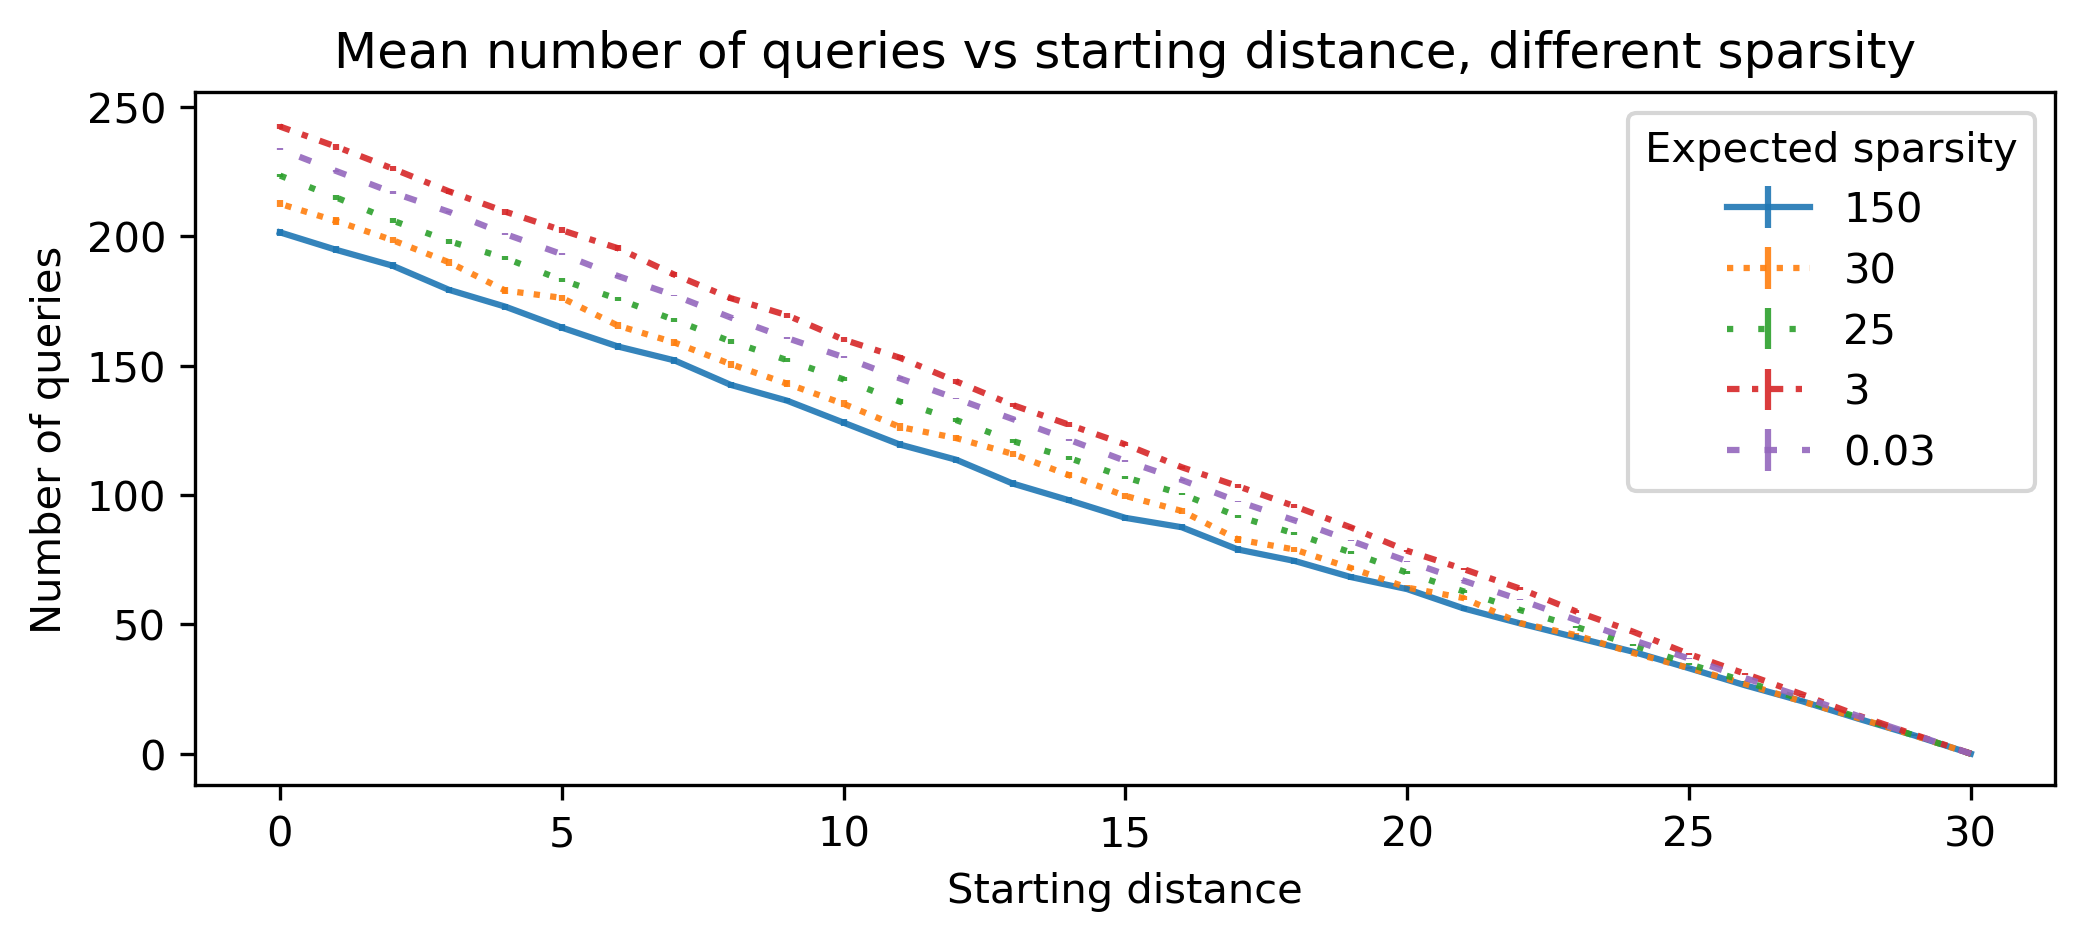

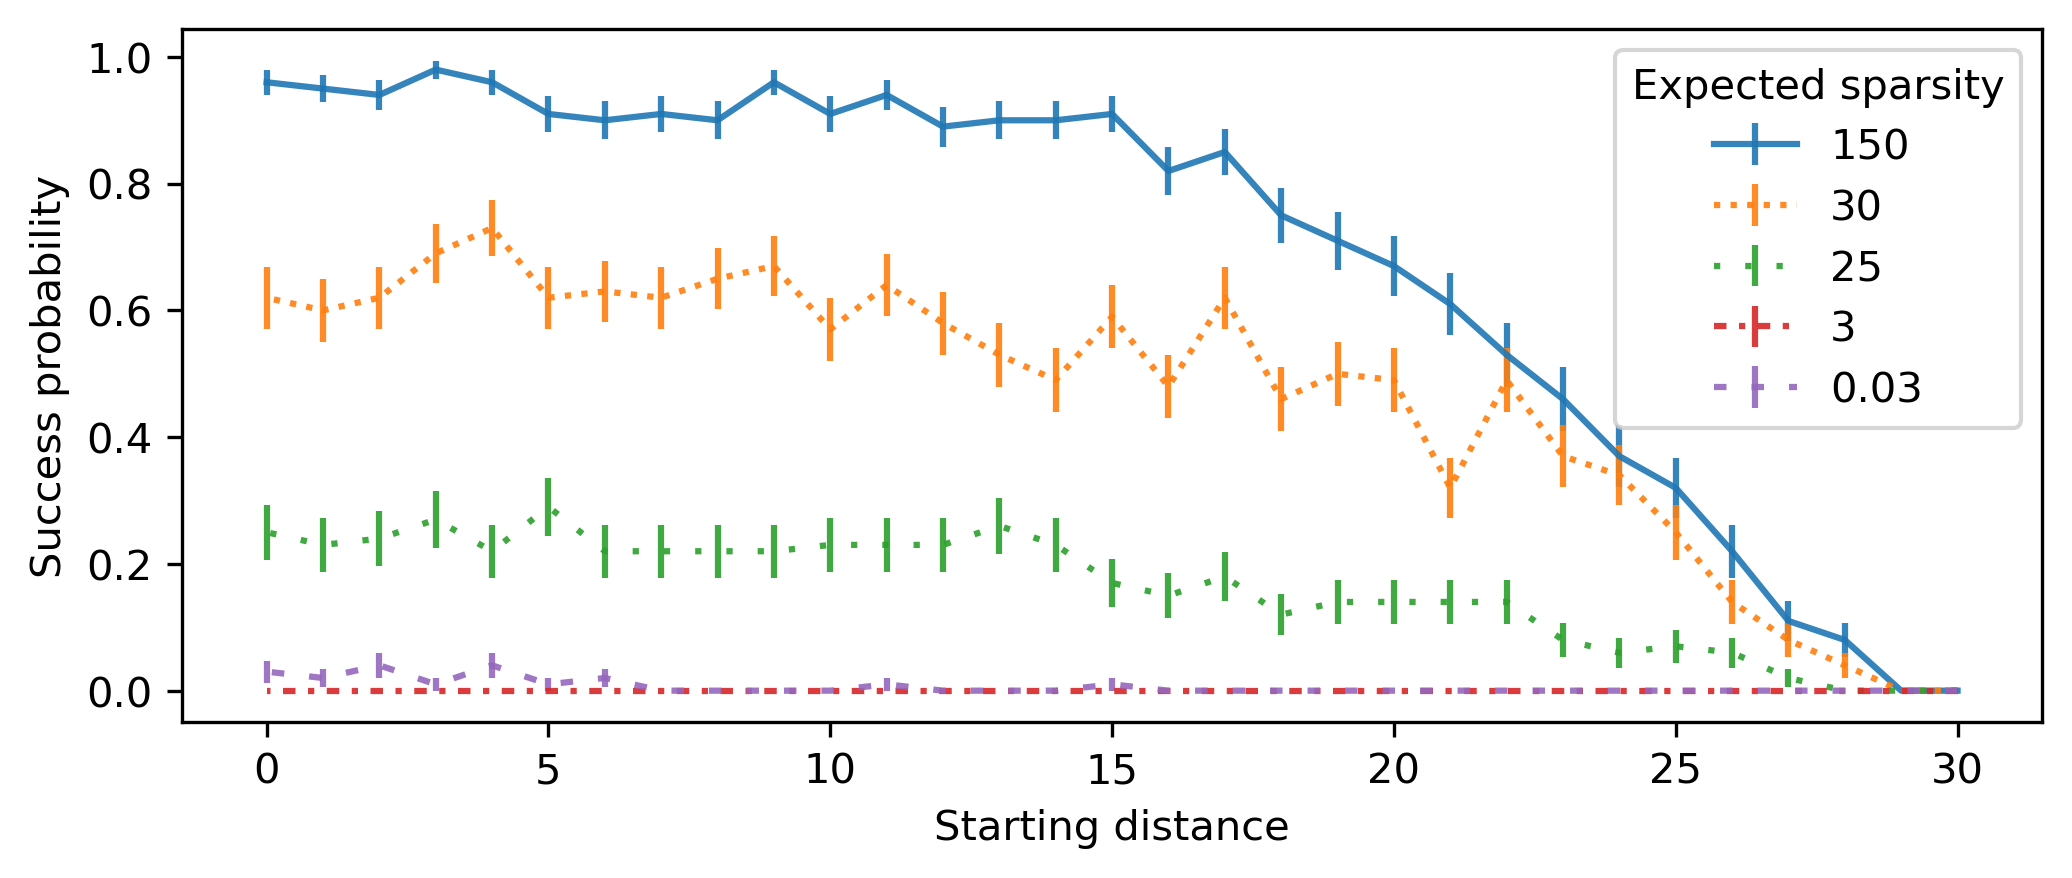

In [299]:
linestyles = [
    'solid',
    'dotted',
    (0,(1, 4)),
    (0, (2,2,1,2)),
    (0,(2,4)),
    'dashed',
]


for data, sample_prob, linestyle in zip(all_sparse_data, p_grid, linestyles):
    plot_data(data, plot_queries=True, label=f"{sample_prob*point_params['d']:0.3g}", linestyle=linestyle, alpha=0.9)
plt.legend(title="Expected sparsity")
# plt.xlim(xlims)
plt.title(f"Mean number of queries vs starting distance, different sparsity")
plt.xlabel("Starting distance")
plt.ylabel("Number of queries")
save_fig(f"all-sparsity-starting-distance")
plt.show()

for data, sample_prob, linestyle in zip(all_sparse_data, p_grid, linestyles):
    plot_data(data, plot_prob=True, label=f"{sample_prob*point_params['d']:0.3g}", linestyle=linestyle, alpha=0.9)
plt.legend(title="Expected sparsity")
# plt.xlim(xlims)
# plt.title(f"Success probability vs starting distance, different sparsity")
plt.xlabel("Starting distance")
plt.ylabel("Success probability")
save_fig(f"all-sparsity-starting-distance")
plt.show()

## Sparsity vs radius

In [300]:
env = Environment()

point_params = {
    'n': 8000,
    'd': 300,
    'point_type': "random",
    'sample_probability': 1/500,
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/16,
    'seed_offset': 0,
    'r1': int(point_params['d'] * 0.15),
    'r2': int(point_params['d'] * 0.3)
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 100,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
    'origin': 'random',
}

In [301]:
p_grid = [1/2, 1/10, 25/300, 1/100, 1/10000]

grid = np.arange(0, lsh_params['r2'], 1)

all_res = []

for sample_prob in p_grid:
    cur_point_params = point_params.copy()
    cur_point_params['sample_probability'] = sample_prob
    res = run_basic_grid_experiment(grid, 'target_distance', env, cur_point_params, lsh_params, exp_params, data_dir=DATA_DIR)
    all_res.append(res)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

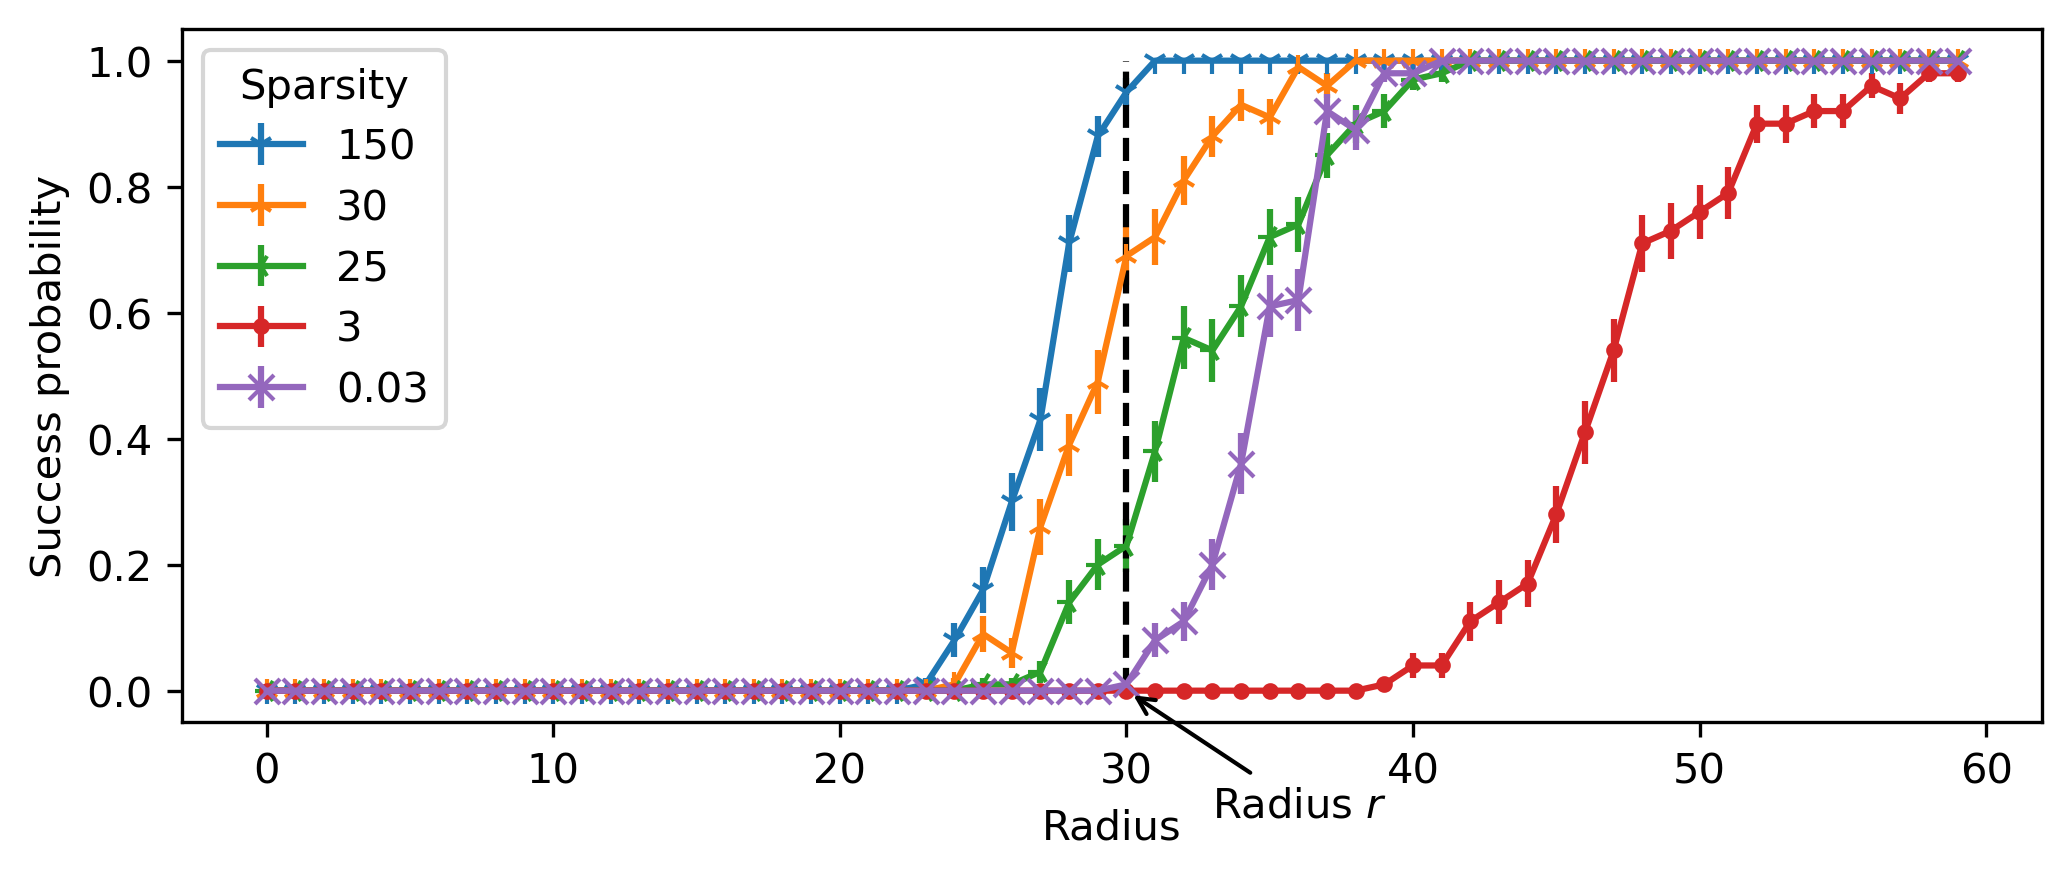

In [302]:
markers = ['1', '2', '3', '.', 'x', '+']
for r_res, prob, mark in zip(all_res, p_grid, markers):
    data_succ_prob, _ = process_results(r_res)
    plt.errorbar(grid, data_succ_prob[0], yerr=data_succ_prob[1], marker=mark, label=f"{prob*point_params['d']:.3g}")

plt.vlines(lsh_params['r1'], 0, 1, linestyles='dashed', color='black')
# plt.title(f"Success probability vs target radius")
plt.legend(title='Sparsity')
# plt.ylim(-0.1, 1.1)
plt.xlabel("Radius")
plt.ylabel("Success probability")
plt.annotate('Radius $r$', xy=(30, 0), xytext=(33, -0.2),
            arrowprops=dict(arrowstyle='->'))

save_fig("sparsity-radius-comparison")
plt.show()


## Random vs isolated start

In [285]:
env = Environment()

point_params_list = [
    {
    'n': 8000,
    'd': 300,
    'point_type': "random",
    'seed_offset': 0
    },
    {
    'n': 8000,
    'd': 300,
    'point_type': "zero",
    'seed_offset': 0
    },
    {
    'n': 8000,
    'd': 300,
    'point_type': "random",
    'sample_probability': 1/15,
    'seed_offset': 0
    },
    {
    'n': 8000,
    'd': 784,
    'point_type': "mnist_binary",
    'seed_offset': 0
    },
    {
    'n': 8000,
    'd': 116,
    'point_type': "mushroom",
    'seed_offset': 0
    },
    {
    'n': 8000,
    'd': 294,
    'point_type': "msweb",
    'seed_offset': 0
    }
]

dataset_names = ['Random', "Zero", "Sparse random", "MNIST", "Mushroom", "MS Web"]

lsh_params = {
    'delta': 1/16,
    'seed_offset': 0,
#     'r1': int(point_params['d'] * 0.15),
#     'r2': int(point_params['d'] * 0.3)
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 100,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
    'origin': 'random',
}

In [286]:
grid = ['random', 'isolated']
all_res_prob = []
all_res_queries = []


for point_params in point_params_list:
    res = run_basic_grid_experiment(grid, 'origin', env, point_params, lsh_params, exp_params, DATA_DIR)
    prob, queries = process_results(res)
    all_res_prob.append(prob)
    all_res_queries.append(queries)

# all_res = list(zip(*all_res))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [287]:
prob_res = [list(zip(*val)) for val in all_res_prob]
prob_res = list(zip(*prob_res))
prob_res = [list(zip(*val)) for val in prob_res]

['Random', 'Zero', 'Sparse random', 'MNIST', 'Mushroom', 'MS Web']
Random
(0.94, 0.023868325657594204)
(0.96, 0.019694638556693237)
(0.02, 0.014070529413628968)
(0.29, 0.04560480215720686)
(0.58, 0.04960449637488583)
(0.0, 0.0)
Isolated
(0.95, 0.021904291355759033)
(0.95, 0.021904291355759036)
(0.91, 0.028762349126466143)
(0.93, 0.02564323999762428)
(0.87, 0.03379976689896311)
(0.33, 0.04725815626252608)


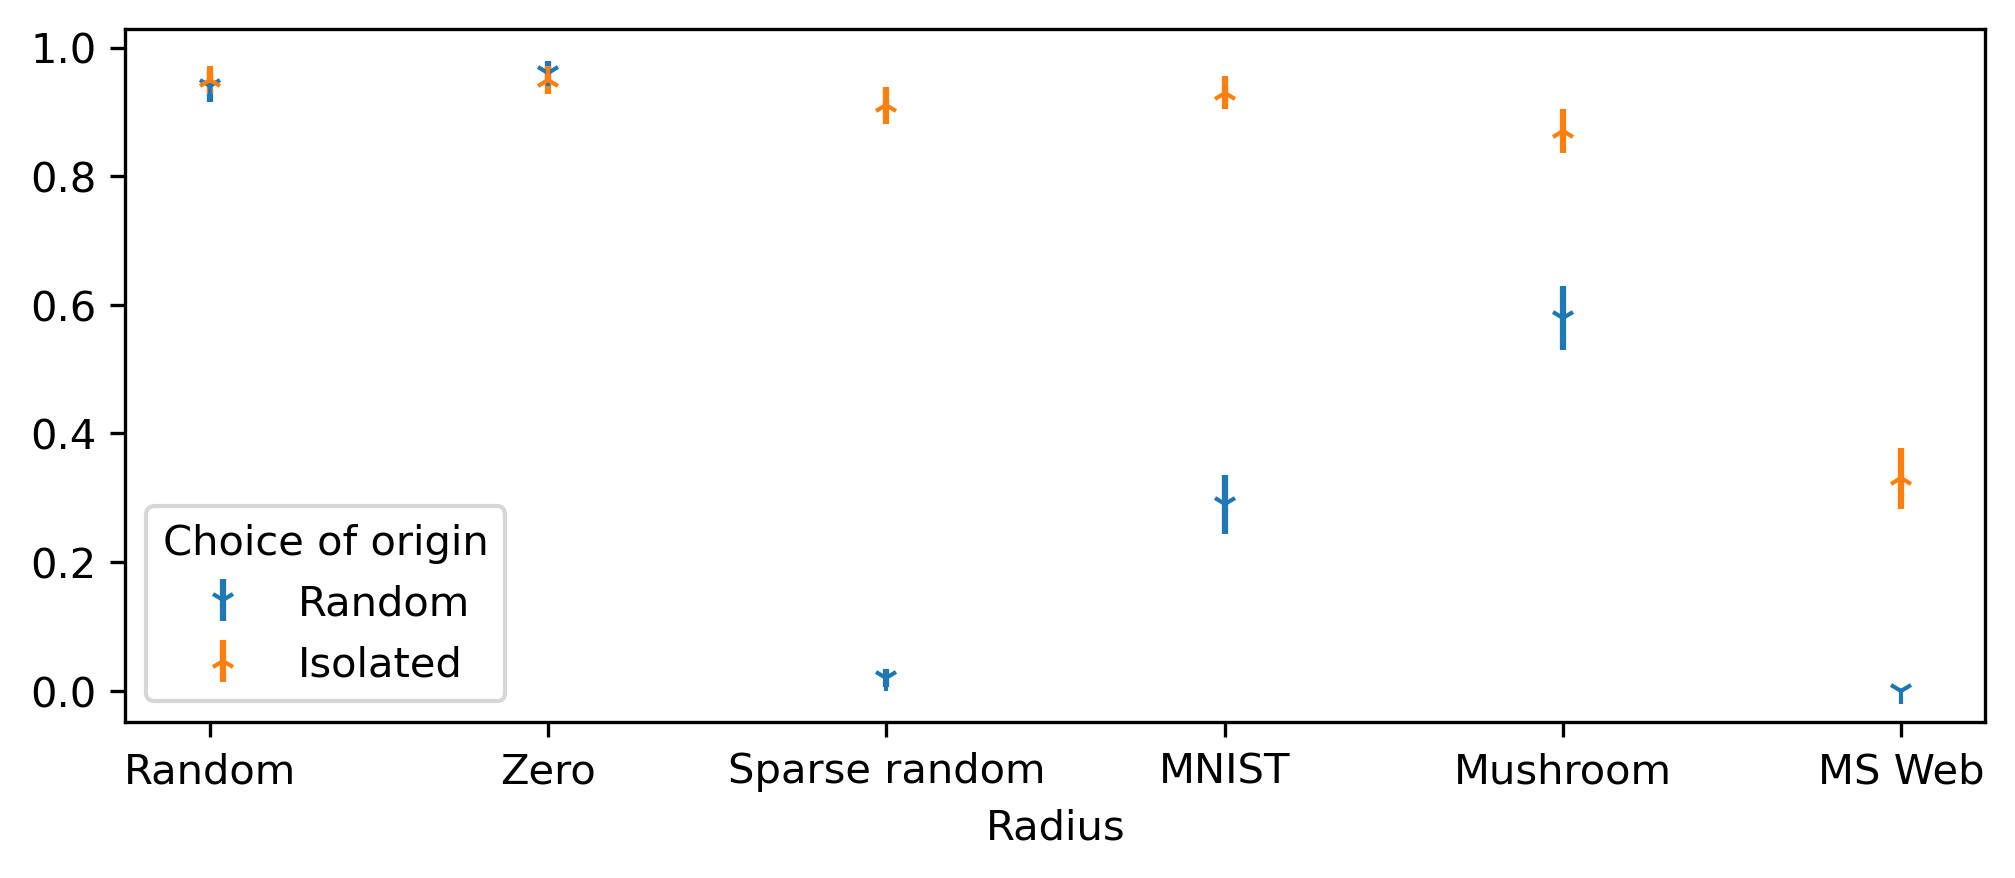

In [288]:
grid_names = ['Random', "Isolated"]
markers = ['1', '2']
t_grid = np.arange(len(dataset_names))

print(dataset_names)
for res, orig, mark in zip(prob_res, grid_names, markers):
    print(orig)
    print(*zip(*res), sep='\n')
    plt.errorbar(t_grid, res[0], yerr=res[1], marker=mark, label=orig, linestyle='none')

# plt.vlines(lsh_params['r1'], 0, 1, linestyles='dashed', color='black')
# plt.title(f"Success probability vs target radius")
plt.legend(title='Choice of origin')
# plt.ylim(-0.1, 1.1)
plt.xticks(t_grid, dataset_names)
plt.xlabel("Radius")
# plt.ylabel("Success probability")
save_fig("random-isolated-comparison")
plt.show()


## Analysing general dependance on radius

In [99]:
env = Environment()

point_params = {
    'n': 1000,
    'd': 300,
    'point_type': "zero",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/5,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 1000,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
}

In [100]:
grid = np.arange(0, lsh_params['r1'], 1)
res = run_basic_grid_experiment(grid, 'target_distance', env, point_params, lsh_params, exp_params, data_dir=DATA_DIR)

  0%|          | 0/30 [00:00<?, ?it/s]

In [101]:
data_succ_prob, data_queries = process_results(res)

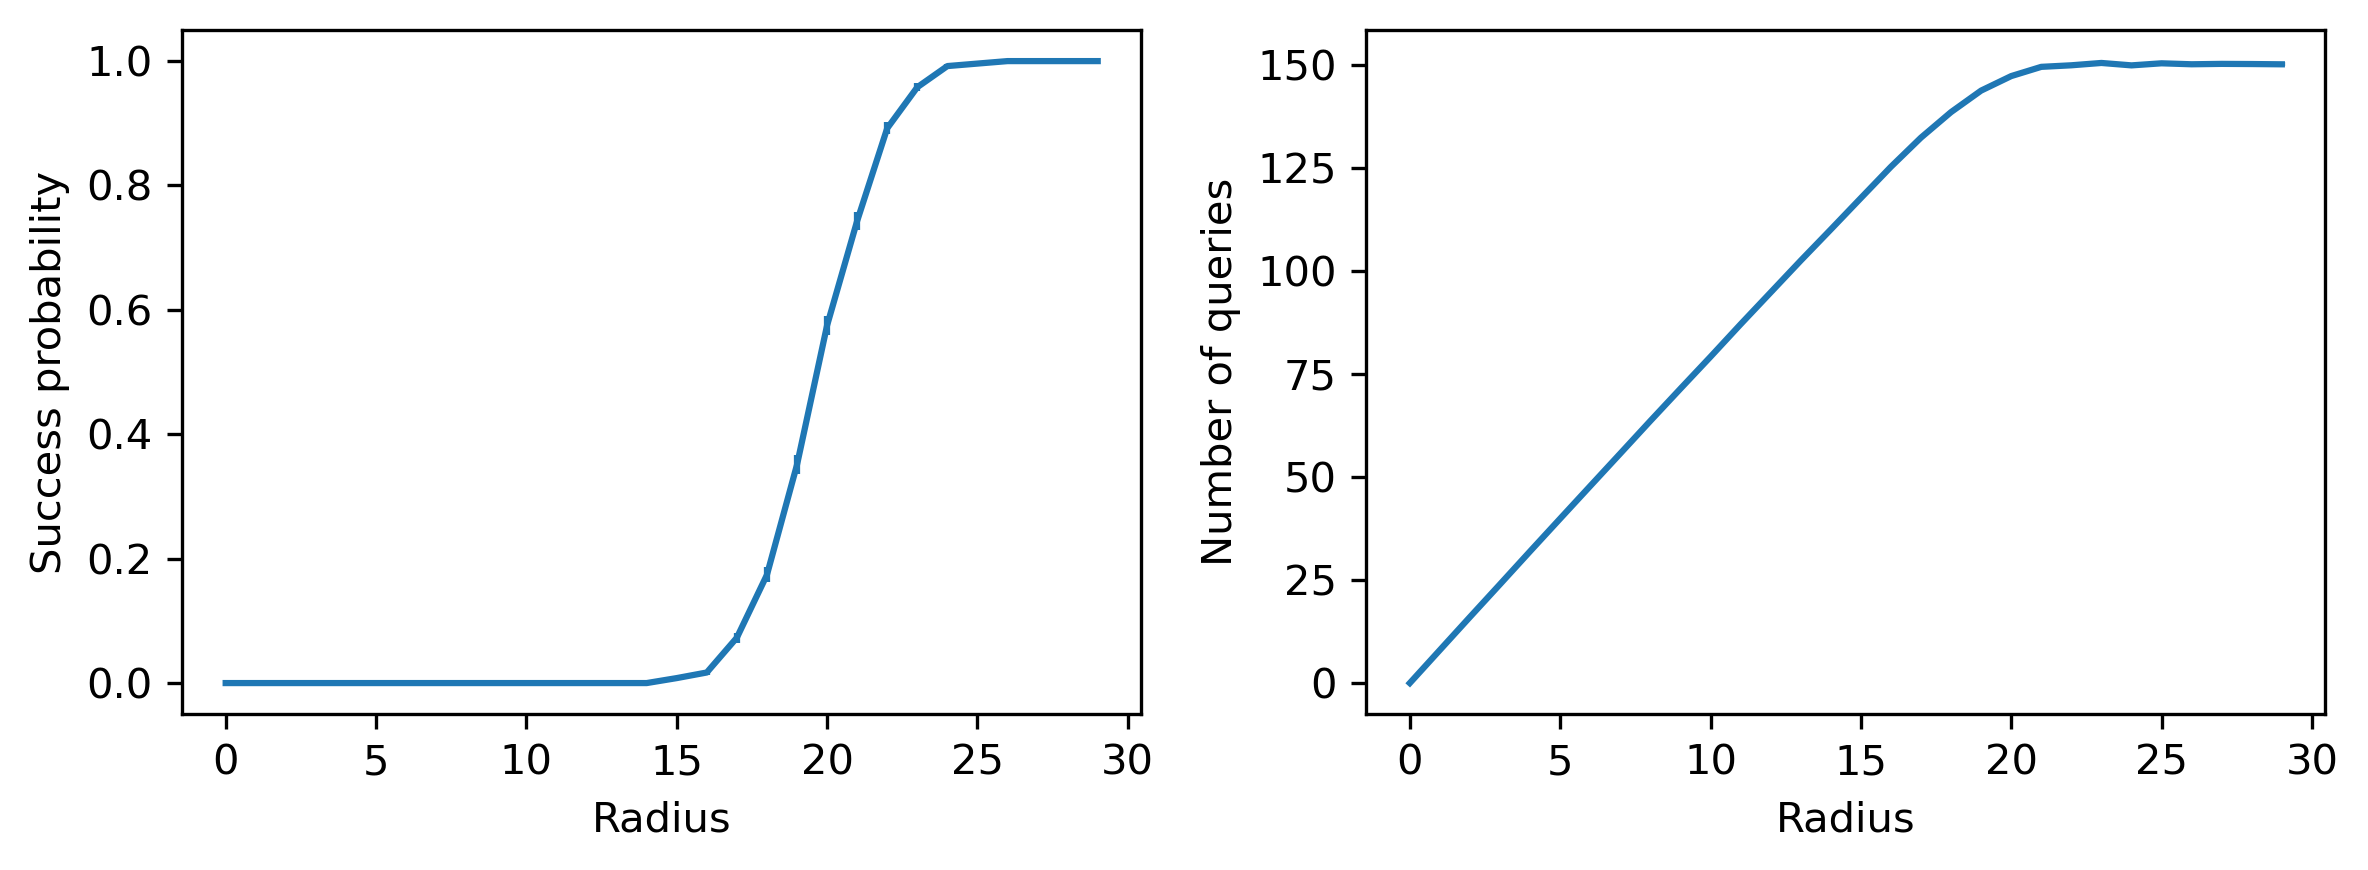

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].errorbar(grid, data_succ_prob[0], yerr=data_succ_prob[1])
# plt.xlim(xlims)
# plt.yscale("log")
axs[0].set_xlabel("Radius")
axs[0].set_ylabel("Success probability")

axs[1].errorbar(grid, data_queries[0], yerr=data_queries[1])
# plt.xlim(xlims)
axs[1].set_xlabel("Radius")
axs[1].set_ylabel("Number of queries")

fig.tight_layout()
# save_fig("all-all-starting-distance")
save_fig("all-radius")
plt.show()

### Search for infliction point

In [303]:
env = Environment()

point_params = {
    'n': 8000,
    'd': 300,
    'point_type': "zero",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/2,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 100,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
}

In [304]:
help_list = np.arange(1, 14, 3)
delta_list = np.exp2(-help_list)

my_rho = np.log(1 - lsh_params['r1']/point_params['d']) / np.log(1 - lsh_params['r2']/point_params['d'])
my_L = int(np.ceil(np.power(point_params['n'], my_rho)))
L_list = help_list * my_L

grid = np.arange(0, lsh_params['r2'], 1)

all_res = []

for dl in delta_list:
    new_lsh_params = lsh_params.copy()
    new_lsh_params['delta'] = dl
    res = run_basic_grid_experiment(grid, 'target_distance', env, point_params, new_lsh_params, exp_params, data_dir=DATA_DIR)
    all_res.append(res)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

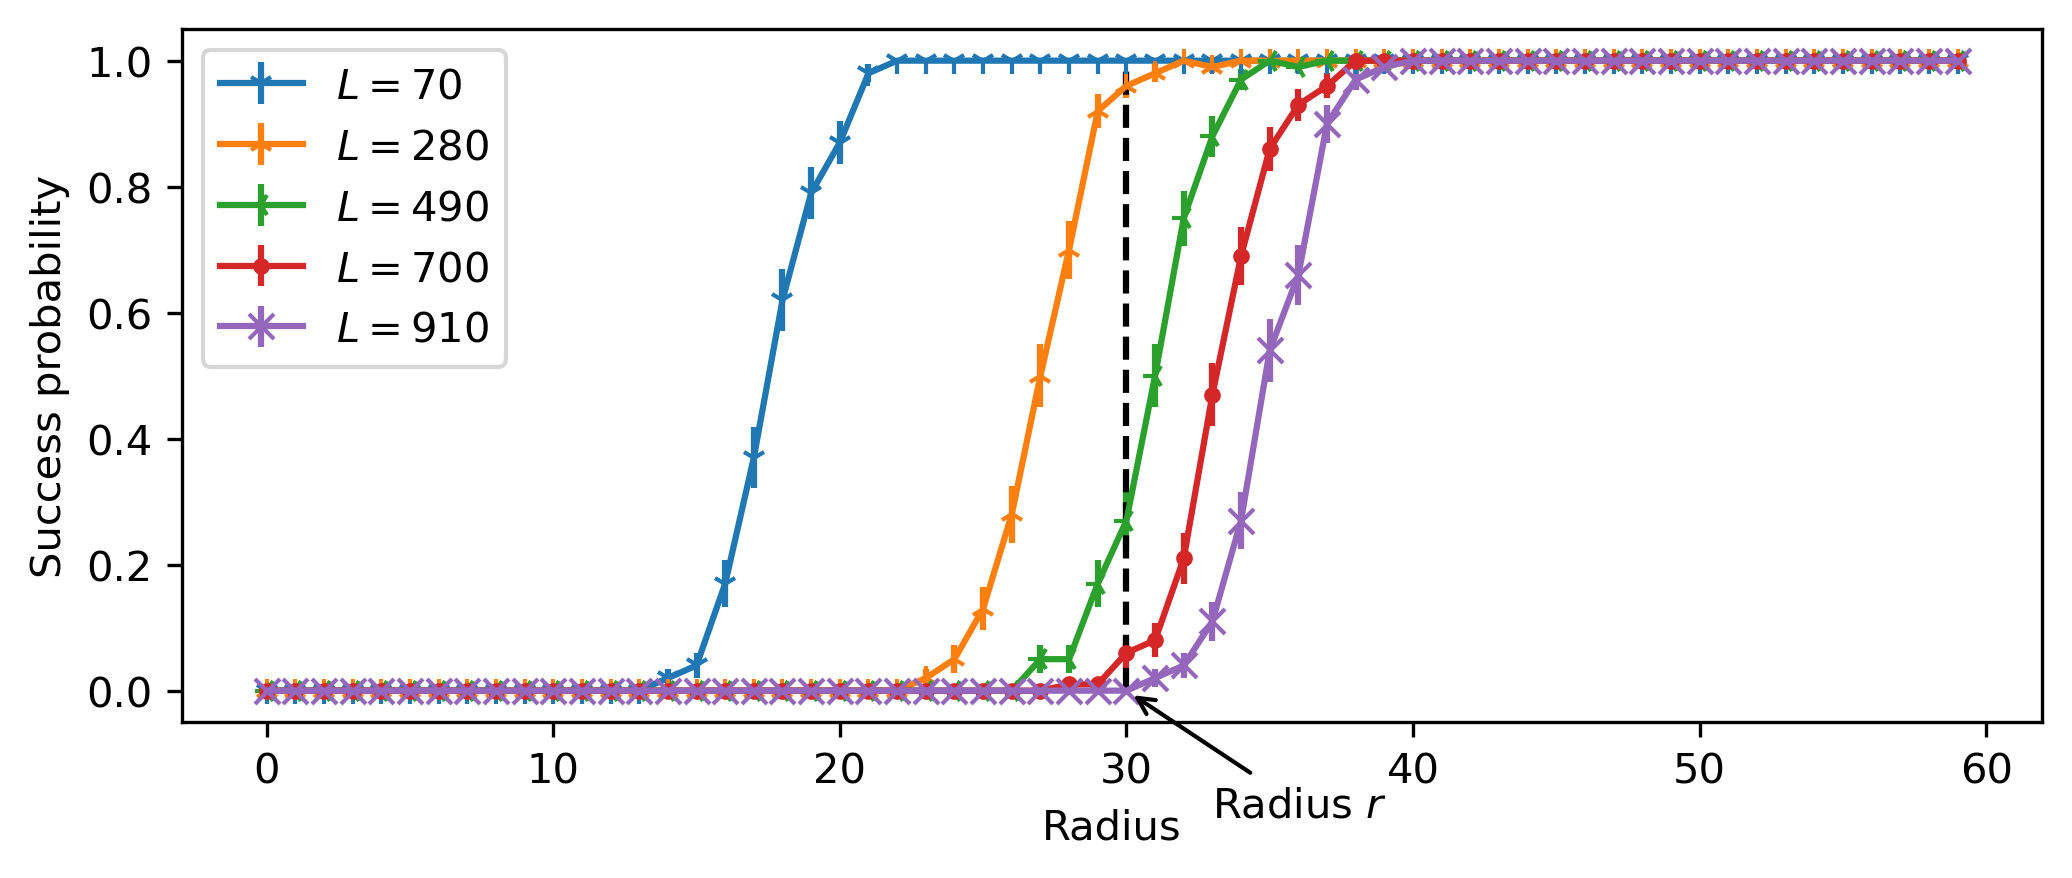

In [305]:
markers = ['1', '2', '3', '.', 'x']
for r_res, dl, mark, cl in zip(all_res, delta_list, markers, L_list):
    data_succ_prob, _ = process_results(r_res)
    plt.errorbar(grid, data_succ_prob[0], yerr=data_succ_prob[1], marker=mark, label=f"$L={cl}$")

plt.vlines(lsh_params['r1'], 0, 1, linestyles='dashed', color='black')
# plt.title(f"Success probability vs target radius")
plt.legend()
# plt.ylim(-0.1, 1.1)
plt.xlabel("Radius")
plt.ylabel("Success probability")
plt.annotate('Radius $r$', xy=(30, 0), xytext=(33, -0.2),
            arrowprops=dict(arrowstyle='->'))
save_fig("delta-comparison")
plt.show()


### Success probability vs number of hash functions

In [25]:
l_list = np.linspace(1, 500, 20, endpoint=True)
points = np.zeros((n, d), dtype=int)
nn_checker = skln.KDTree(points, metric='l1')

l_all_res = []

for cur_l in tqdm(l_list):
    iters_per_point = 300
    cur_res = []
    for i in range(iters_per_point):
        lsh = HammingLSH(points, r1, r2, l=int(cur_l))
        cur_res.append(run_exp_fast(r1))
    l_all_res.append(cur_res)

  0%|          | 0/20 [00:00<?, ?it/s]

In [26]:
failure_prob = []
mean_queries = np.zeros(len(l_all_res))
err_queries = np.zeros(len(l_all_res))
# bars_queries = [np.zeros(len(r_res)), np.zeros(len(r_res))]
for i, v in enumerate(l_all_res):
    f_pr = sum(1 - e[0] for e in v) / len(v)
    failure_prob.append(f_pr)
    queries = [e[1] for e in v]
    mean_queries[i] = np.mean(queries)
#     bars_queries[0][i] = np.percentile(queries, 90)
#     bars_queries[1][i] = np.percentile(queries, 10)
    err_queries[i] = np.std(queries)


# bars_queries[0] -= mean_queries
# bars_queries[1] = mean_queries - bars_queries[1]

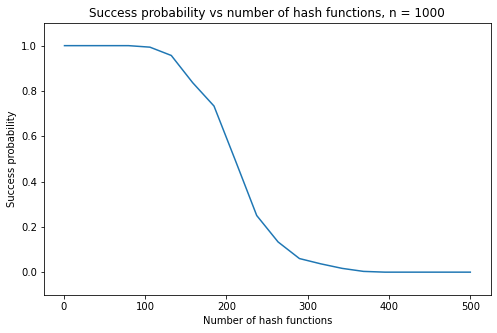

In [33]:
plt.plot(l_list, 1 - np.array(failure_prob))
plt.title(f"Success probability vs number of hash functions, n = {n}")
plt.ylim(-0.1, 1.1)
# plt.yscale("log")
# plt.xscale("log")
plt.xlabel("Number of hash functions")
plt.ylabel("Success probability")
plt.show()

### Number of queries vs $1/\delta$

In [125]:
env = Environment()

point_params = {
    'n': 1000,
    'd': 300,
    'point_type': "zero",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/2,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 1000,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
    'max_queries': 80000,
    'max_resamples': 40000,
}

In [126]:
delta_list = np.logspace(1, 8, 8, endpoint=True, base=1/2)
my_rho = np.log(1 - lsh_params['r1']/point_params['d']) / np.log(1 - lsh_params['r2']/point_params['d'])
my_L = int(np.ceil(np.power(point_params['n'], my_rho)))
L_list = np.arange(1, 9) * my_L

delta_adapt_res = []

# for cur_delta in tqdm(delta_list):
#     iters_per_point = 100
#     cur_res = []
#     for i in range(iters_per_point):
#         lsh = HammingLSH(points, r1, r2, delta=cur_delta)
#         cur_res.append(run_exp_fast(points[0], r1, nn_checker, lsh, max_resamples=30))
#     delta_res.append(cur_res)

for dl in tqdm(delta_list):
    new_lsh_params = lsh_params.copy()
    new_lsh_params['delta'] = dl
    cur_res = run_experiments(env, point_params, new_lsh_params, exp_params, data_dir=DATA_DIR)
    delta_adapt_res.append(cur_res)

  0%|          | 0/8 [00:00<?, ?it/s]

In [127]:
delta_list = np.logspace(1, 8, 8, endpoint=True, base=1/2)
delta_rand_res = []

for dl in tqdm(delta_list):
    new_lsh_params = lsh_params.copy()
    new_lsh_params['delta'] = dl
    new_exp_params = exp_params.copy()
    new_exp_params['alg_type'] = 'random'
    cur_res = run_experiments(env, point_params, new_lsh_params, new_exp_params, data_dir=DATA_DIR)
    delta_rand_res.append(cur_res)

  0%|          | 0/8 [00:00<?, ?it/s]

In [128]:
adapt_succ_prob, adapt_queries = process_results(delta_adapt_res)
rand_succ_prob, rand_queries = process_results(delta_rand_res)

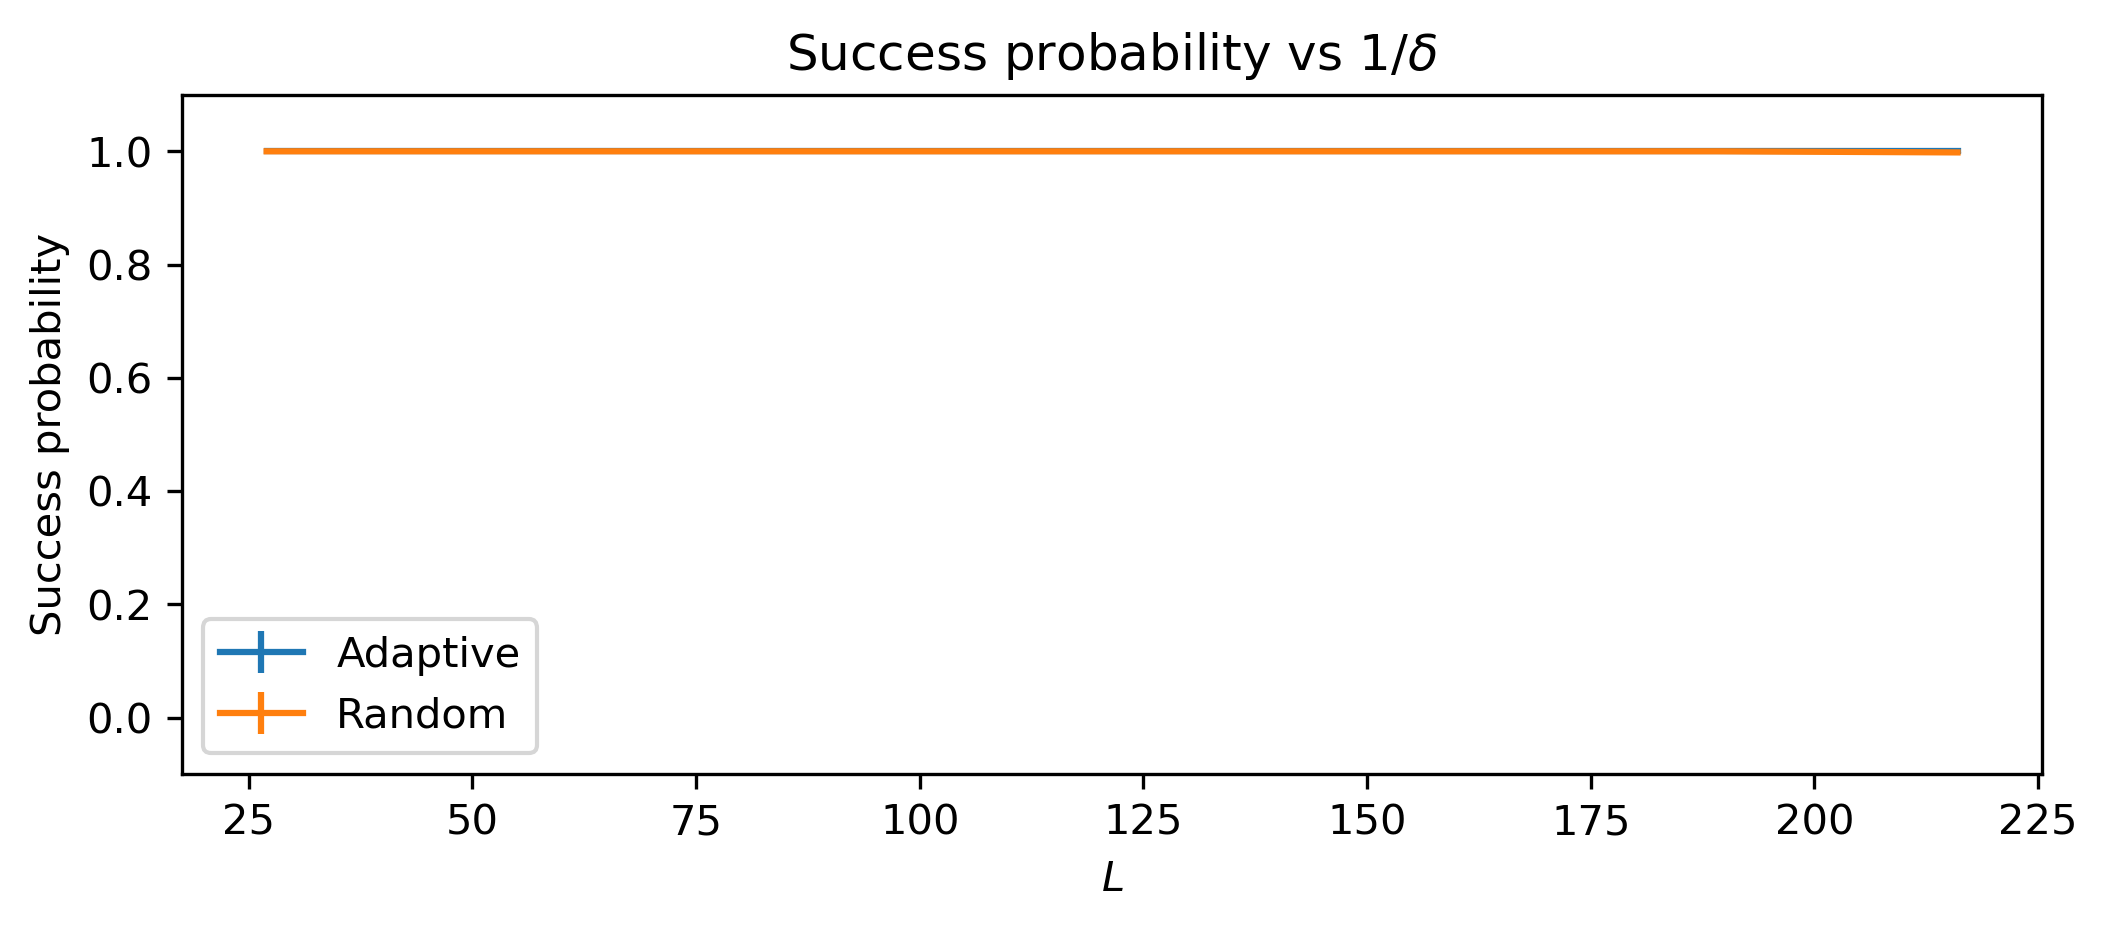

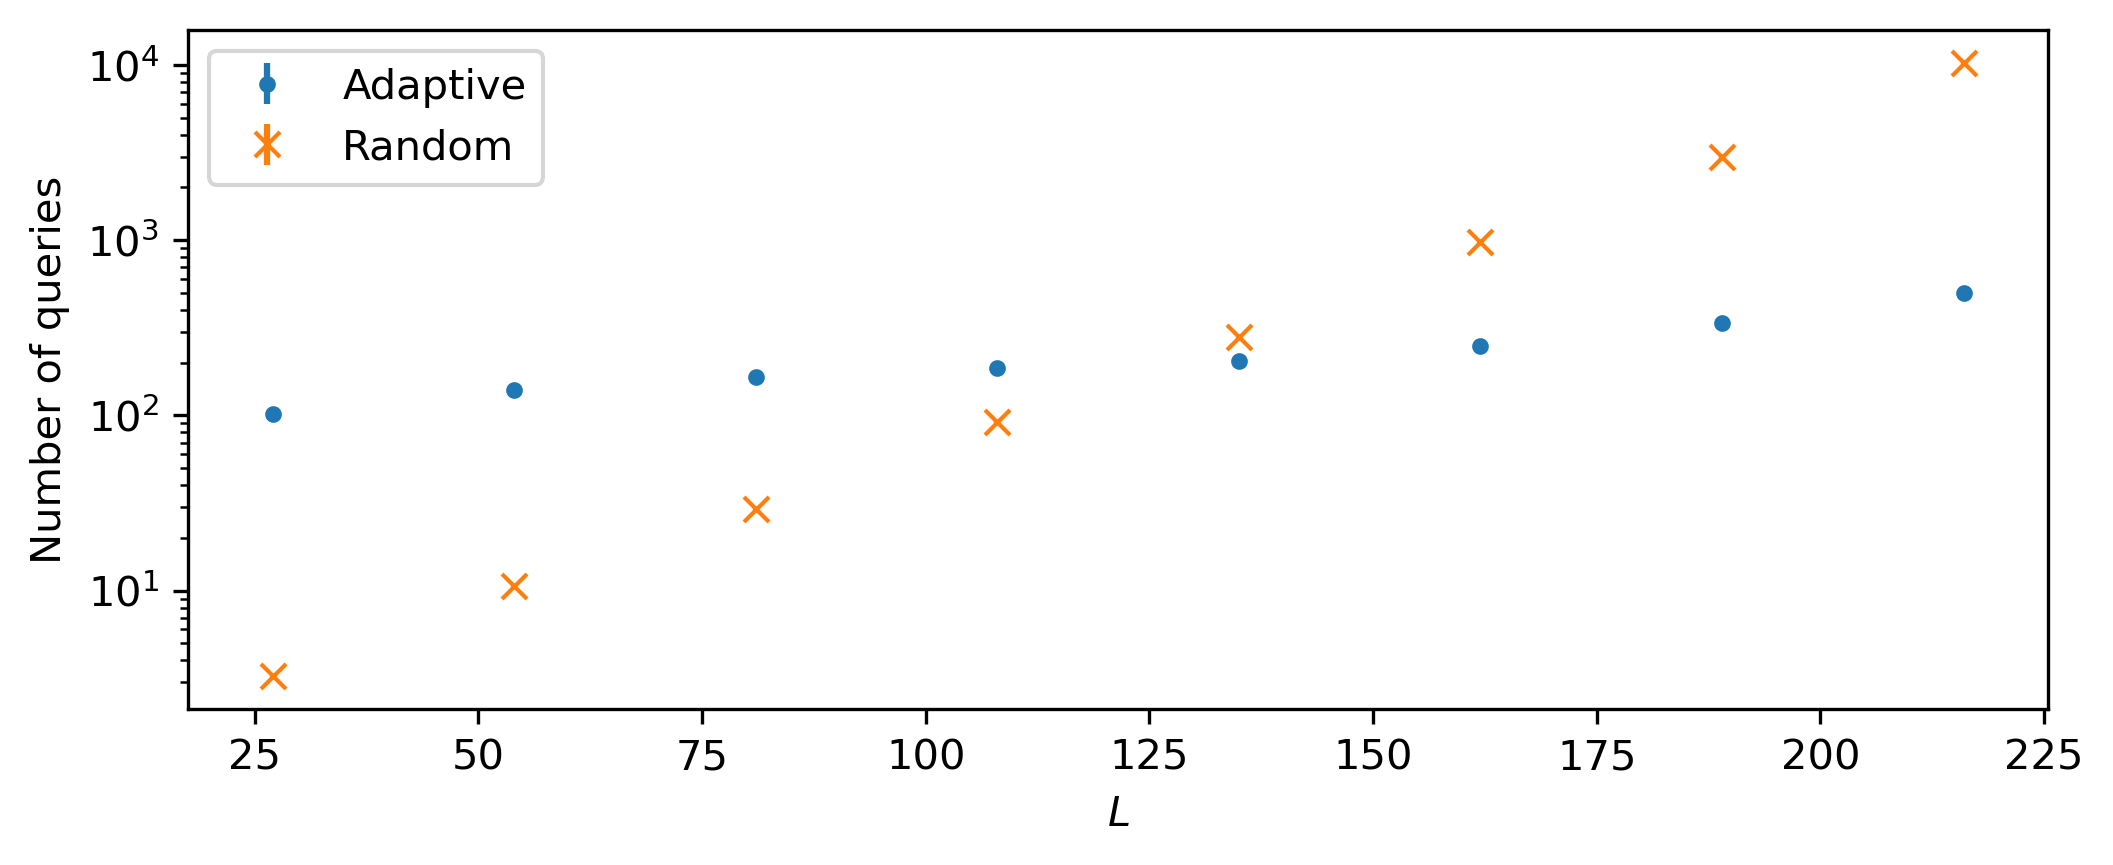

In [129]:
plt.errorbar(L_list, adapt_succ_prob[0], yerr=adapt_succ_prob[1], label="Adaptive")
plt.errorbar(L_list, rand_succ_prob[0], yerr=rand_succ_prob[1], label="Random")
plt.legend()
plt.title(f"Success probability vs $1/\delta$")
plt.ylim(-0.1, 1.1)
# plt.yscale("log")
# plt.xscale("log")
plt.xlabel("$L$")
plt.ylabel("Success probability")
plt.show()

plt.errorbar(L_list, adapt_queries[0], yerr=adapt_queries[1], label="Adaptive", marker='.', linestyle='None')
plt.errorbar(L_list, rand_queries[0], yerr=rand_queries[1], label="Random", marker='x', linestyle='None')
# plt.plot(1 / delta_list, rand_mean_queries / (1 - np.array(rand_failure_prob)), label="Random projected")
plt.legend()
# plt.title(f"Number of queries vs $1/\delta$")
plt.yscale("log")
# plt.xscale("log")
plt.xlabel("$L$")
plt.ylabel("Number of queries")
save_fig("both_queries-delta")
plt.show()

# plt.errorbar(1 / delta_list, mean_queries, yerr=err_queries, label="Adaptive")
# plt.errorbar(1 / delta_list, rand_mean_queries, yerr=rand_err_queries, label="Random")
# plt.plot(1 / delta_list, rand_mean_queries / (1 - np.array(rand_failure_prob)), label="Random projected")
# plt.legend()
# plt.title(f"Number of queries vs $1/\delta$, n = {n}")
# # plt.yscale("log")
# plt.xscale("log")
# plt.xlabel("$1 / \delta$")
# plt.ylabel("Number of queries")
# plt.show()

$X_i$ value of experiment $i$
$$1/n \cdot \sum_{i} X_i$$
error bar $$ 1/\sqrt{n} \cdot Var(X_i)$$

# Size of $G(q,z)$

In [6]:
t = 10

In [7]:
print(r1, r2, t, n, d)

30 60 10 1000 300


In [11]:
points = np.zeros((n, d))

z = np.zeros(d)

In [29]:
grid = np.arange(0, r2)

num_samples = 10
res = []
for dist in tqdm(grid):
    q = np.zeros(d)
    q[:dist] = 1
    cur_res = []
    for i in range(num_samples):
        lsh = HammingLSH(points, r1, r2, delta)
        cur_res.append(lsh.cnt_mutual_buckets(q, z))
    res.append(cur_res)

  0%|          | 0/60 [00:00<?, ?it/s]

In [40]:
frac_res = np.array(res) / lsh._l
means = np.mean(frac_res, axis=1)
err = np.std(frac_res, axis=1)

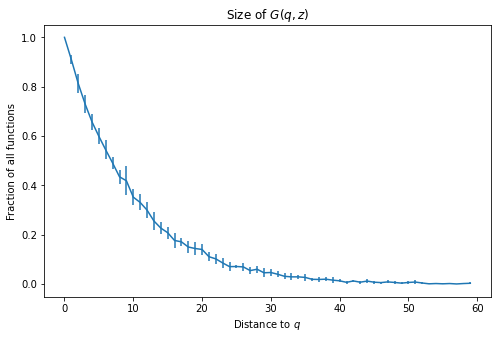

In [42]:
plt.errorbar(grid, means, yerr=err)
# plt.yscale("log")
plt.title("Size of $G(q, z)$")
plt.xlabel("Distance to $q$")
plt.ylabel("Fraction of all functions")
plt.show()

# Random points

### Analysing dependance on radius

In [148]:
env = Environment()

point_params = {
    'n': 1000,
    'd': 300,
    'point_type': "random",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/5,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'change_points': True,
    'iter_num': 1000,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
}

In [149]:
grid = np.arange(0, lsh_params['r1'], 1)
res = run_basic_grid_experiment(grid, 'target_distance', env, point_params, lsh_params, exp_params, data_dir=DATA_DIR)

  0%|          | 0/30 [00:00<?, ?it/s]

In [150]:
data_succ_prob, data_queries = process_results(res)

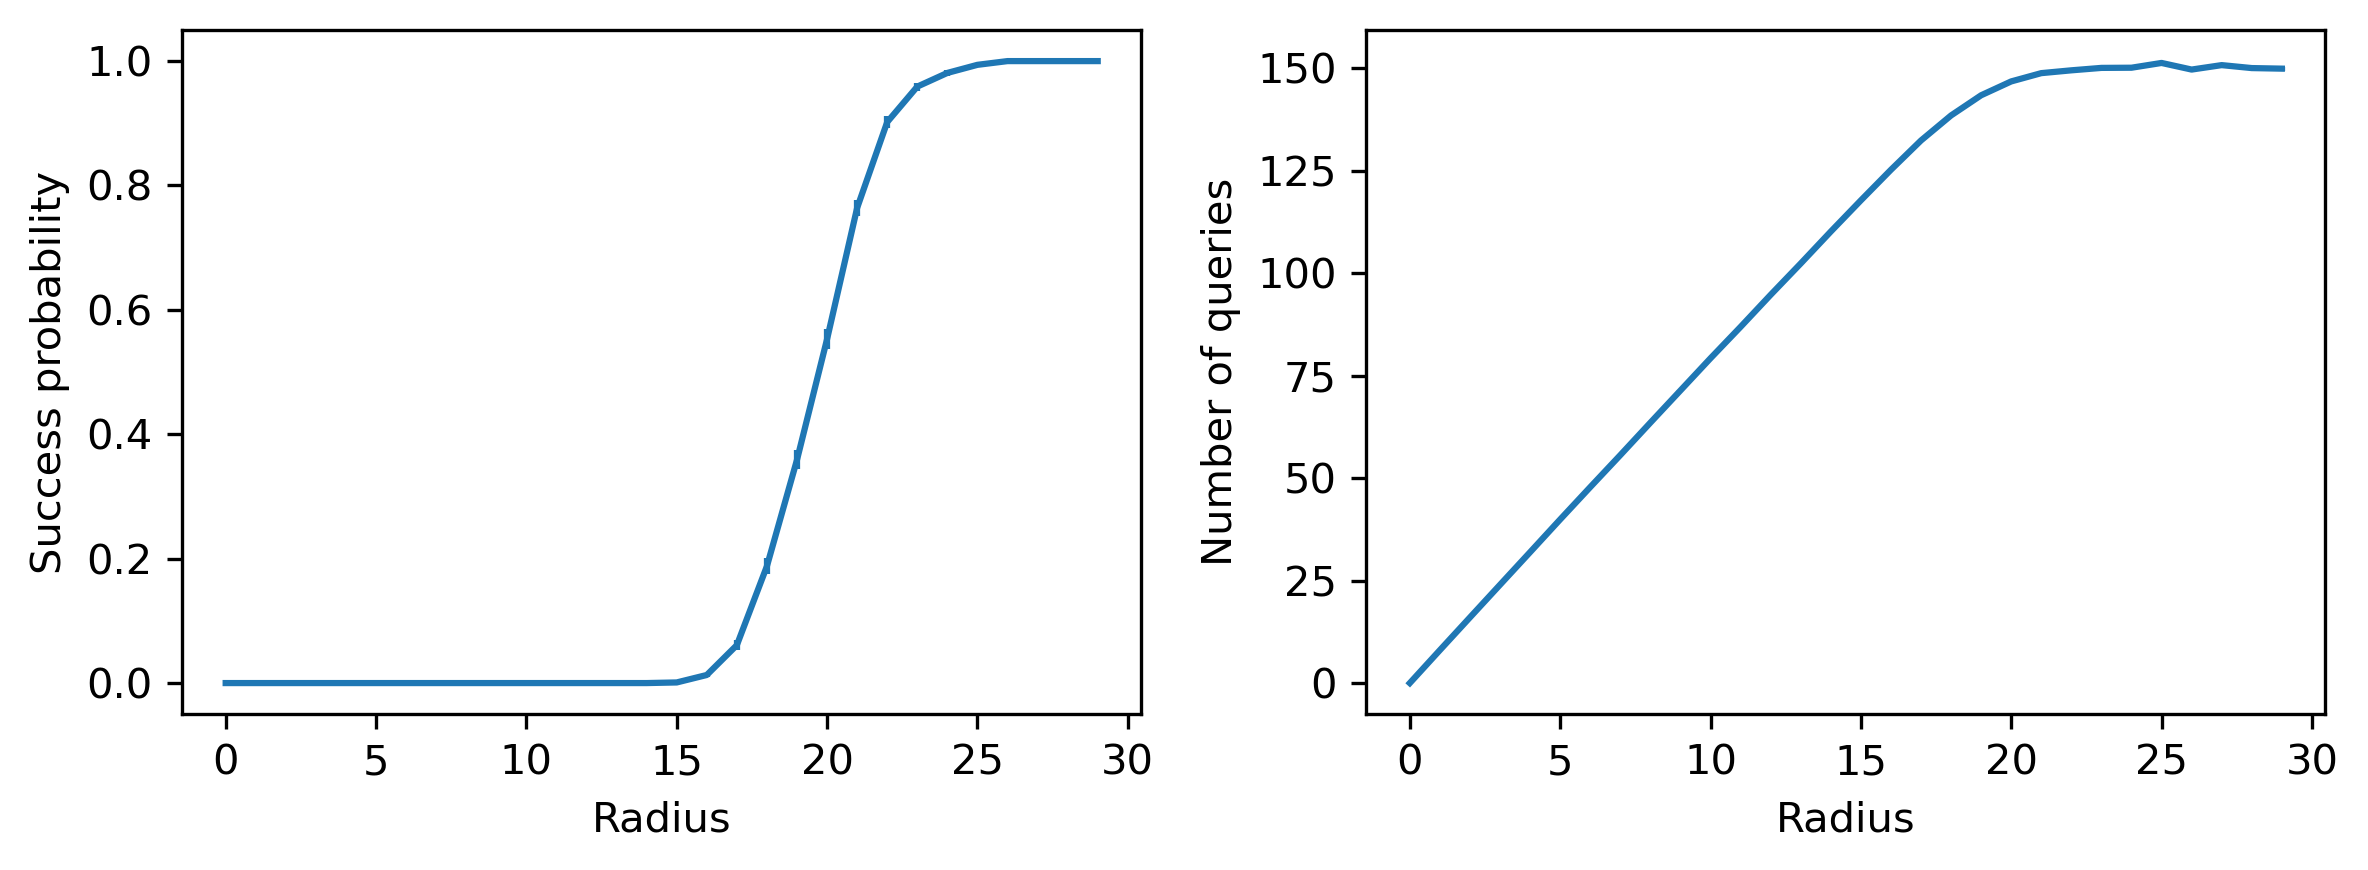

In [151]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].errorbar(grid, data_succ_prob[0], yerr=data_succ_prob[1])
# plt.xlim(xlims)
# plt.yscale("log")
axs[0].set_xlabel("Radius")
axs[0].set_ylabel("Success probability")

axs[1].errorbar(grid, data_queries[0], yerr=data_queries[1])
# plt.xlim(xlims)
axs[1].set_xlabel("Radius")
axs[1].set_ylabel("Number of queries")

fig.tight_layout()
# save_fig("all-all-starting-distance")
save_fig("all-radius-randpoint")
plt.show()

### Search for infliction point

In [59]:
env = Environment()

point_params = {
    'n': 8000,
    'd': 300,
    'point_type': "random",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/2,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'change_points': True,
    'iter_num': 100,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
}

In [60]:
help_list = np.arange(1, 14, 3)
delta_list = np.exp2(-help_list)

my_rho = np.log(1 - lsh_params['r1']/point_params['d']) / np.log(1 - lsh_params['r2']/point_params['d'])
my_L = int(np.ceil(np.power(point_params['n'], my_rho)))
L_list = help_list * my_L

grid = np.arange(0, lsh_params['r2'], 1)

all_res = []

for dl in delta_list:
    new_lsh_params = lsh_params.copy()
    new_lsh_params['delta'] = dl
    res = run_basic_grid_experiment(grid, 'target_distance', env, point_params, new_lsh_params, exp_params, data_dir=DATA_DIR)
    all_res.append(res)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

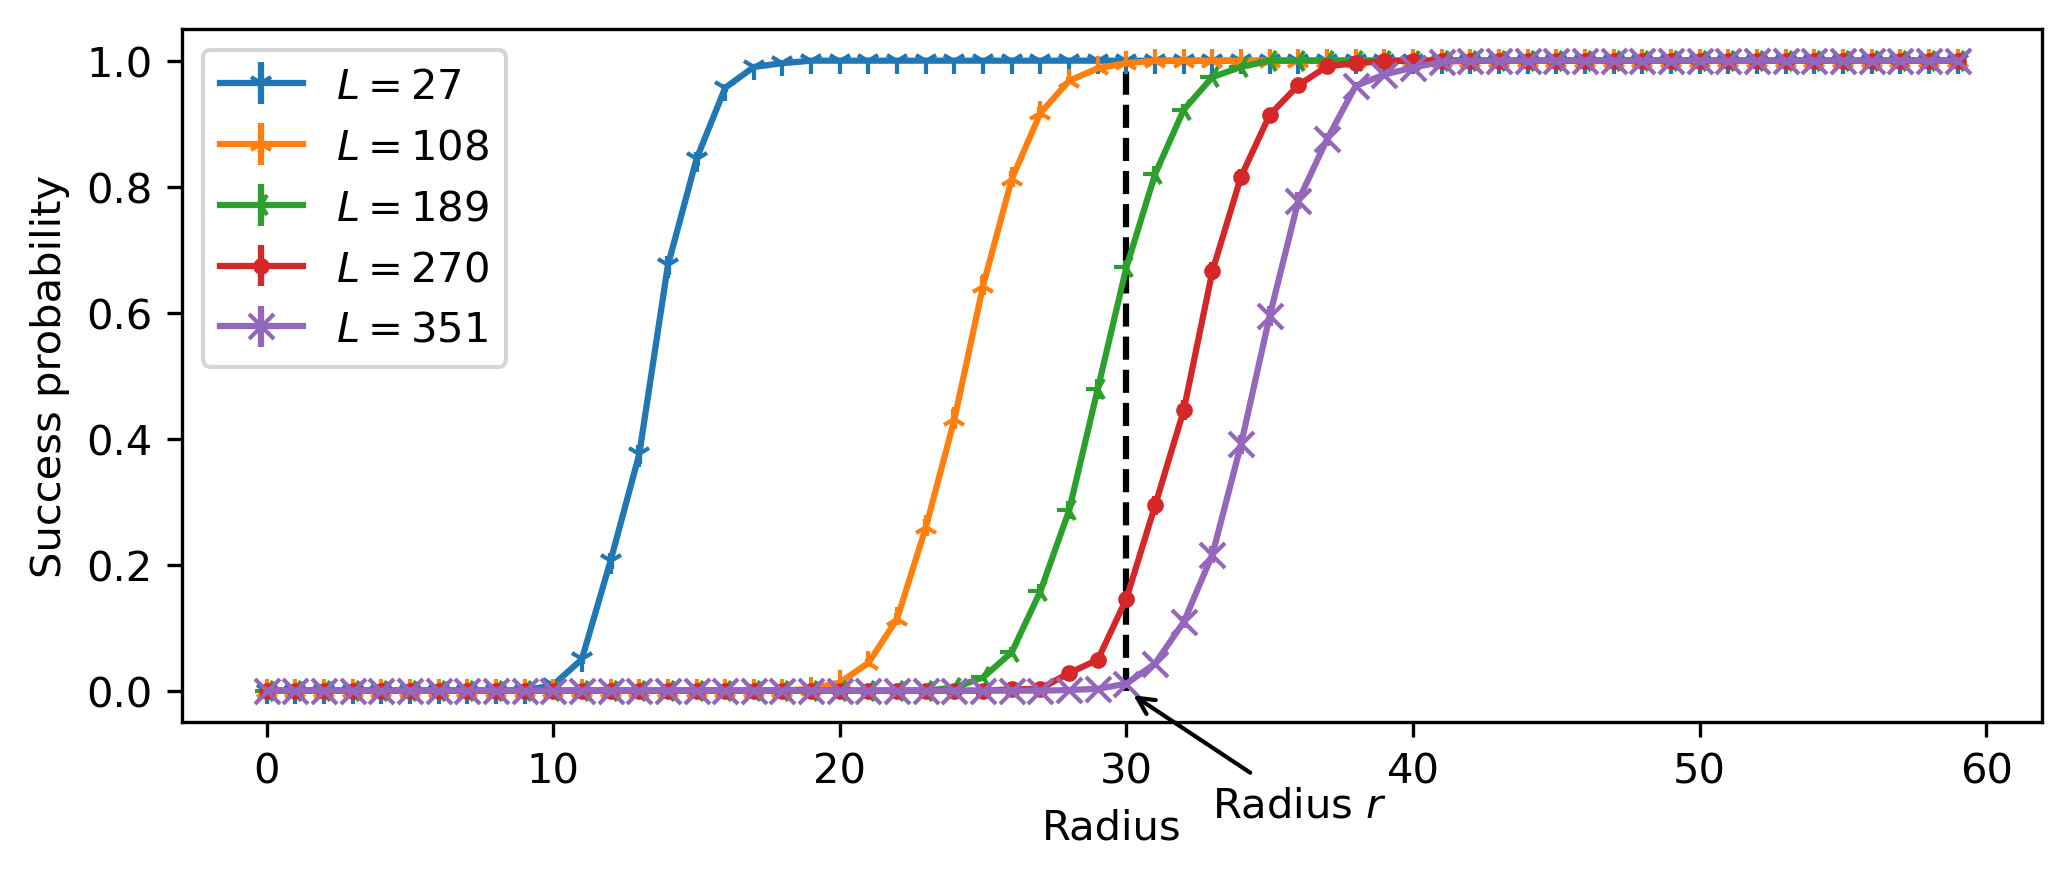

In [61]:
markers = ['1', '2', '3', '.', 'x']
for r_res, dl, mark, cl in zip(all_res, delta_list, markers, L_list):
    data_succ_prob, _ = process_results(r_res)
    plt.errorbar(grid, data_succ_prob[0], yerr=data_succ_prob[1], marker=mark, label=f"$L={cl}$")

plt.vlines(lsh_params['r1'], 0, 1, linestyles='dashed', color='black')
# plt.title(f"Success probability vs target radius")
plt.legend()
# plt.ylim(-0.1, 1.1)
plt.xlabel("Radius")
plt.ylabel("Success probability")
plt.annotate('Radius $r$', xy=(30, 0), xytext=(33, -0.2),
            arrowprops=dict(arrowstyle='->'))
save_fig("delta-comparison-randpoint")
plt.show()


### Number of queries vs $1/\delta$

In [155]:
env = Environment()

point_params = {
    'n': 1000,
    'd': 300,
    'point_type': "random",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/2,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'change_points': True,
    'iter_num': 1000,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
    'max_queries': 80000,
    'max_resamples': 40000,
}

In [156]:
delta_list = np.logspace(1, 8, 8, endpoint=True, base=1/2)
my_rho = np.log(1 - lsh_params['r1']/point_params['d']) / np.log(1 - lsh_params['r2']/point_params['d'])
my_L = int(np.ceil(np.power(point_params['n'], my_rho)))
L_list = np.arange(1, 9) * my_L

delta_adapt_res = []

# for cur_delta in tqdm(delta_list):
#     iters_per_point = 100
#     cur_res = []
#     for i in range(iters_per_point):
#         lsh = HammingLSH(points, r1, r2, delta=cur_delta)
#         cur_res.append(run_exp_fast(points[0], r1, nn_checker, lsh, max_resamples=30))
#     delta_res.append(cur_res)

for dl in tqdm(delta_list):
    new_lsh_params = lsh_params.copy()
    new_lsh_params['delta'] = dl
    cur_res = run_experiments(env, point_params, new_lsh_params, exp_params, data_dir=DATA_DIR)
    delta_adapt_res.append(cur_res)

  0%|          | 0/8 [00:00<?, ?it/s]

In [157]:
delta_list = np.logspace(1, 8, 8, endpoint=True, base=1/2)
delta_rand_res = []

for dl in tqdm(delta_list):
    new_lsh_params = lsh_params.copy()
    new_lsh_params['delta'] = dl
    new_exp_params = exp_params.copy()
    new_exp_params['alg_type'] = 'random'
    cur_res = run_experiments(env, point_params, new_lsh_params, new_exp_params, data_dir=DATA_DIR)
    delta_rand_res.append(cur_res)

  0%|          | 0/8 [00:00<?, ?it/s]

In [158]:
adapt_succ_prob, adapt_queries = process_results(delta_adapt_res)
rand_succ_prob, rand_queries = process_results(delta_rand_res)

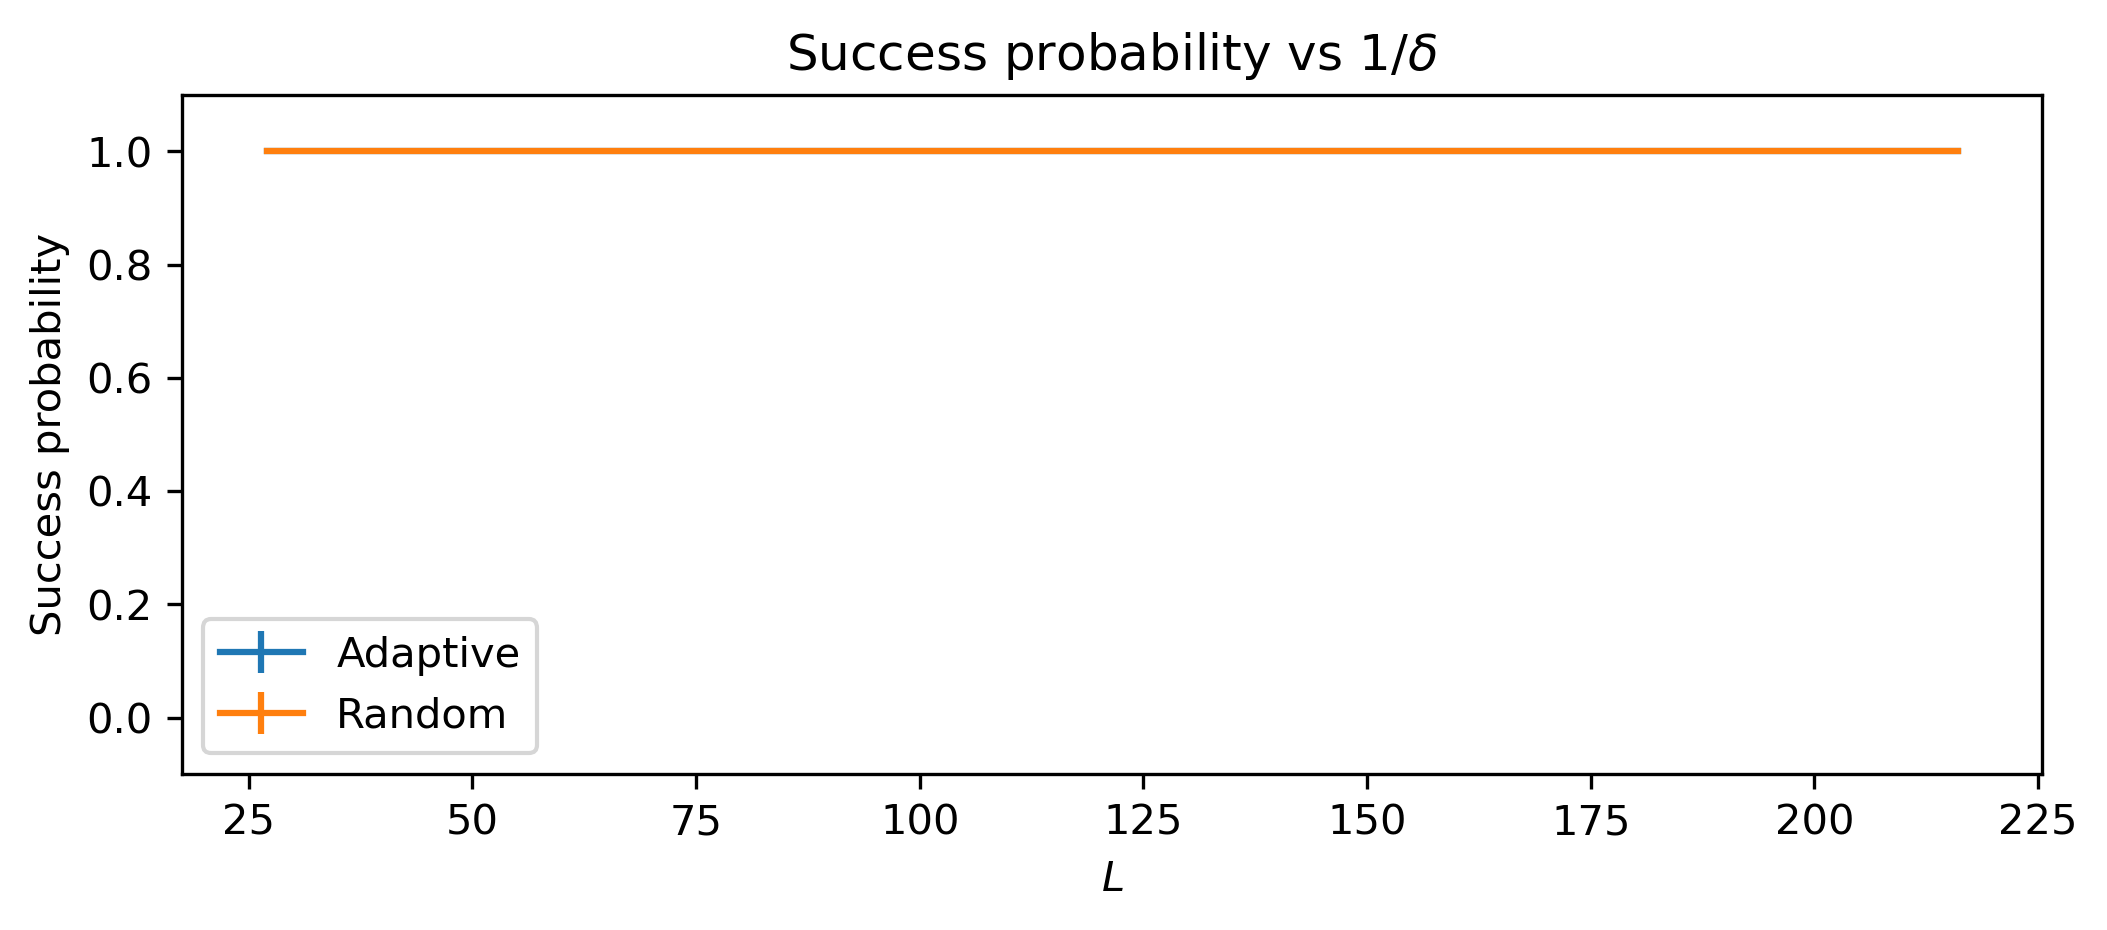

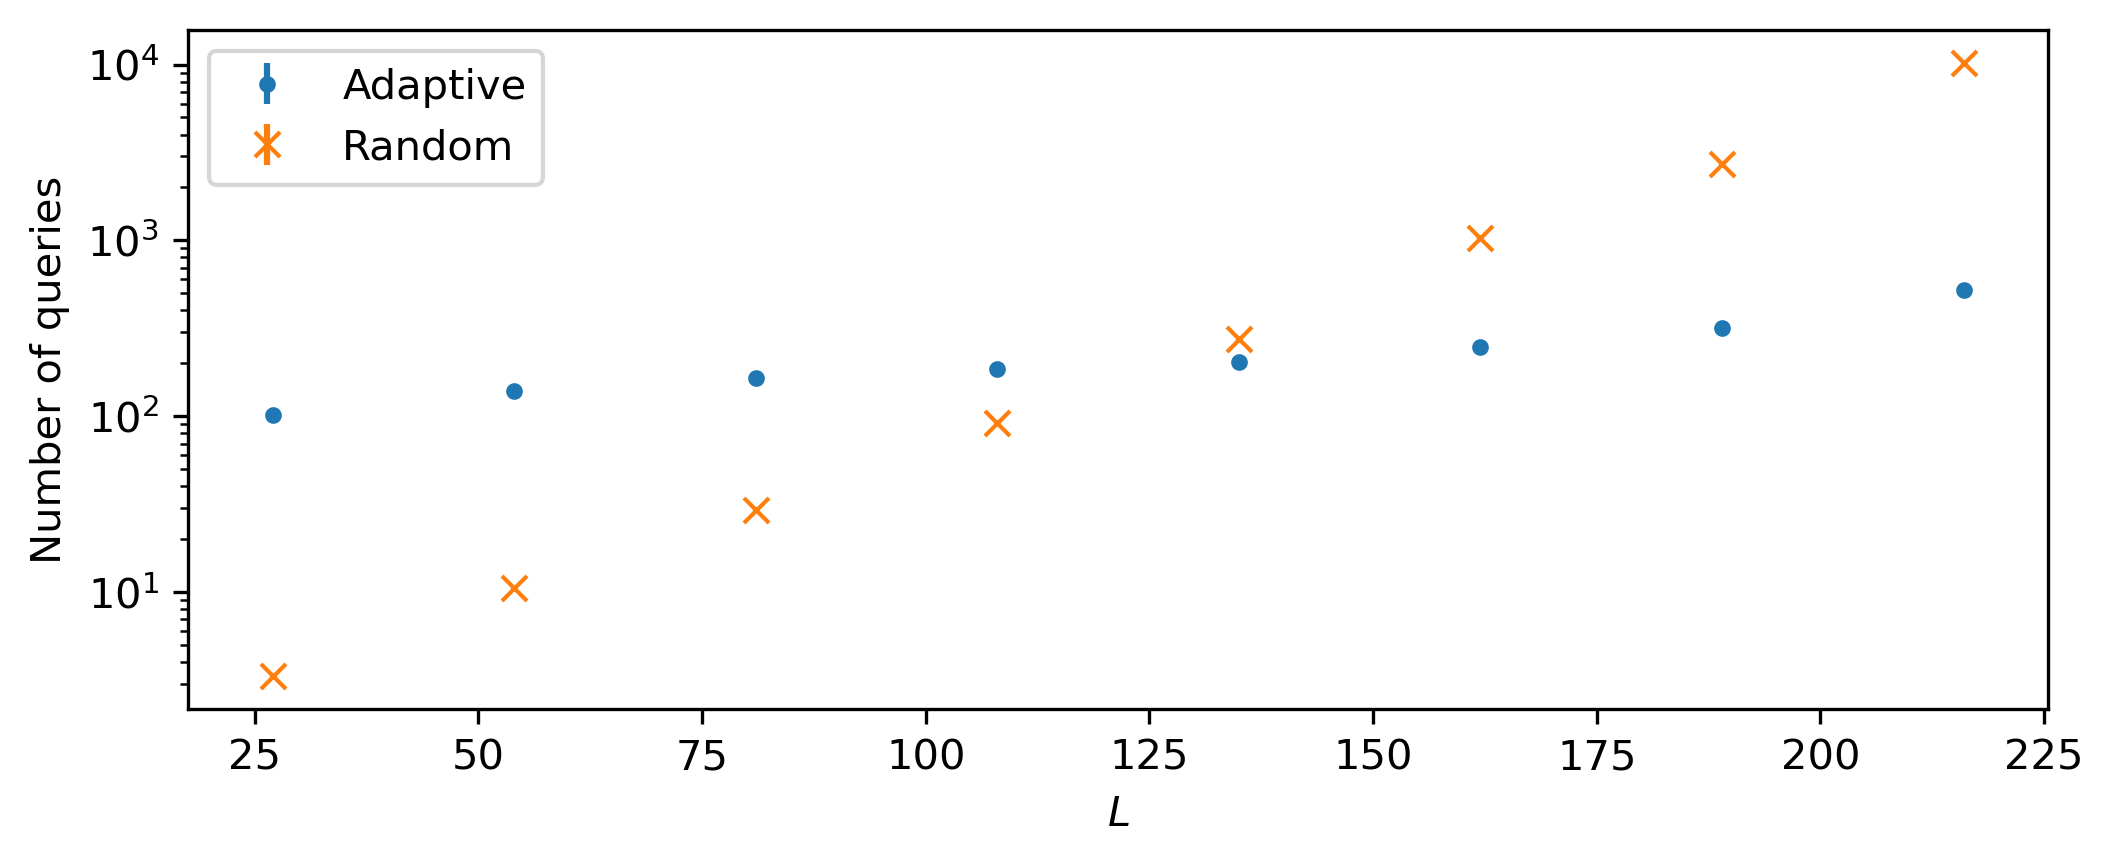

In [159]:
plt.errorbar(L_list, adapt_succ_prob[0], yerr=adapt_succ_prob[1], label="Adaptive")
plt.errorbar(L_list, rand_succ_prob[0], yerr=rand_succ_prob[1], label="Random")
plt.legend()
plt.title(f"Success probability vs $1/\delta$")
plt.ylim(-0.1, 1.1)
# plt.yscale("log")
# plt.xscale("log")
plt.xlabel("$L$")
plt.ylabel("Success probability")
plt.show()

plt.errorbar(L_list, adapt_queries[0], yerr=adapt_queries[1], label="Adaptive", marker='.', linestyle='None')
plt.errorbar(L_list, rand_queries[0], yerr=rand_queries[1], label="Random", marker='x', linestyle='None')
# plt.plot(1 / delta_list, rand_mean_queries / (1 - np.array(rand_failure_prob)), label="Random projected")
plt.legend()
# plt.title(f"Number of queries vs $1/\delta$")
plt.yscale("log")
# plt.xscale("log")
plt.xlabel("$L$")
plt.ylabel("Number of queries")
save_fig("both_queries-delta-randpoint")
plt.show()

# plt.errorbar(1 / delta_list, mean_queries, yerr=err_queries, label="Adaptive")
# plt.errorbar(1 / delta_list, rand_mean_queries, yerr=rand_err_queries, label="Random")
# plt.plot(1 / delta_list, rand_mean_queries / (1 - np.array(rand_failure_prob)), label="Random projected")
# plt.legend()
# plt.title(f"Number of queries vs $1/\delta$, n = {n}")
# # plt.yscale("log")
# plt.xscale("log")
# plt.xlabel("$1 / \delta$")
# plt.ylabel("Number of queries")
# plt.show()

In [ ]:
x = np.arange(100)
plt.plot()